In [1]:
import os
import math
import pandas as pd
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
# rcParams['figure.figsize'] = 7,7 
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
# from heatmap import heatmap, corrplot
# sns.set(color_codes=True, font_scale=1.2)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
path = '../GITS/iot_network_traffic'
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.csv' in file:
            files.append(os.path.join(r, file))

for f in files:
    print(f)

../GITS/iot_network_traffic\csv\ext_features_900_amazon_echo.csv
../GITS/iot_network_traffic\csv\ext_features_900_blink_remote.csv
../GITS/iot_network_traffic\csv\ext_features_900_dlink_cam1.csv
../GITS/iot_network_traffic\csv\ext_features_900_dlink_cam2.csv
../GITS/iot_network_traffic\csv\ext_features_900_dlink_socket.csv
../GITS/iot_network_traffic\csv\ext_features_900_google_chromecast.csv
../GITS/iot_network_traffic\csv\ext_features_900_google_home.csv
../GITS/iot_network_traffic\csv\ext_features_900_mi_bulb.csv
../GITS/iot_network_traffic\csv\ext_features_900_oittm_socket.csv
../GITS/iot_network_traffic\csv\ext_features_900_philips_bulb.csv
../GITS/iot_network_traffic\csv\ext_features_900_samsung_things.csv
../GITS/iot_network_traffic\csv\ext_features_900_tplink_bulb.csv
../GITS/iot_network_traffic\csv\ext_features_900_tplink_cam1.csv
../GITS/iot_network_traffic\csv\ext_features_900_tplink_cam2.csv
../GITS/iot_network_traffic\csv\ext_features_900_tplink_socket.csv
../GITS/iot_netw

In [3]:
data = []
for i in files:
    data.append(pd.read_csv(i))
for i in data:
#     print(len(i), len(i.columns))
    if 'Unnamed: 0' in str(i.columns):
        del i['Unnamed: 0']
        
    if 'sess_id' in str(i.columns):
        del i['sess_id']
# l = 0
# for i in data:
#     l += len(i)
#     print(len(i), len(i.columns))
    
# print(l)
pd_data = pd.concat(data, ignore_index=True)
pd_data
# for index, row in pd_data.iterrows():
#     print(row['mqtt_topic'], type(row['mqtt_topic']))
#     if type(row['mqtt_topic']) != str and math.isnan(row['mqtt_topic']):
#         row['mqtt_topic'] = 'none'
#     print(row['mqtt_topic'], type(row['mqtt_topic']))
#     print(row['mqtt_topic'])

pd_data = pd_data.replace([float('nan')],'none')
# for index, row in pd_data.iterrows():
#     print(row['mqtt_topic'], type(row['mqtt_topic']))

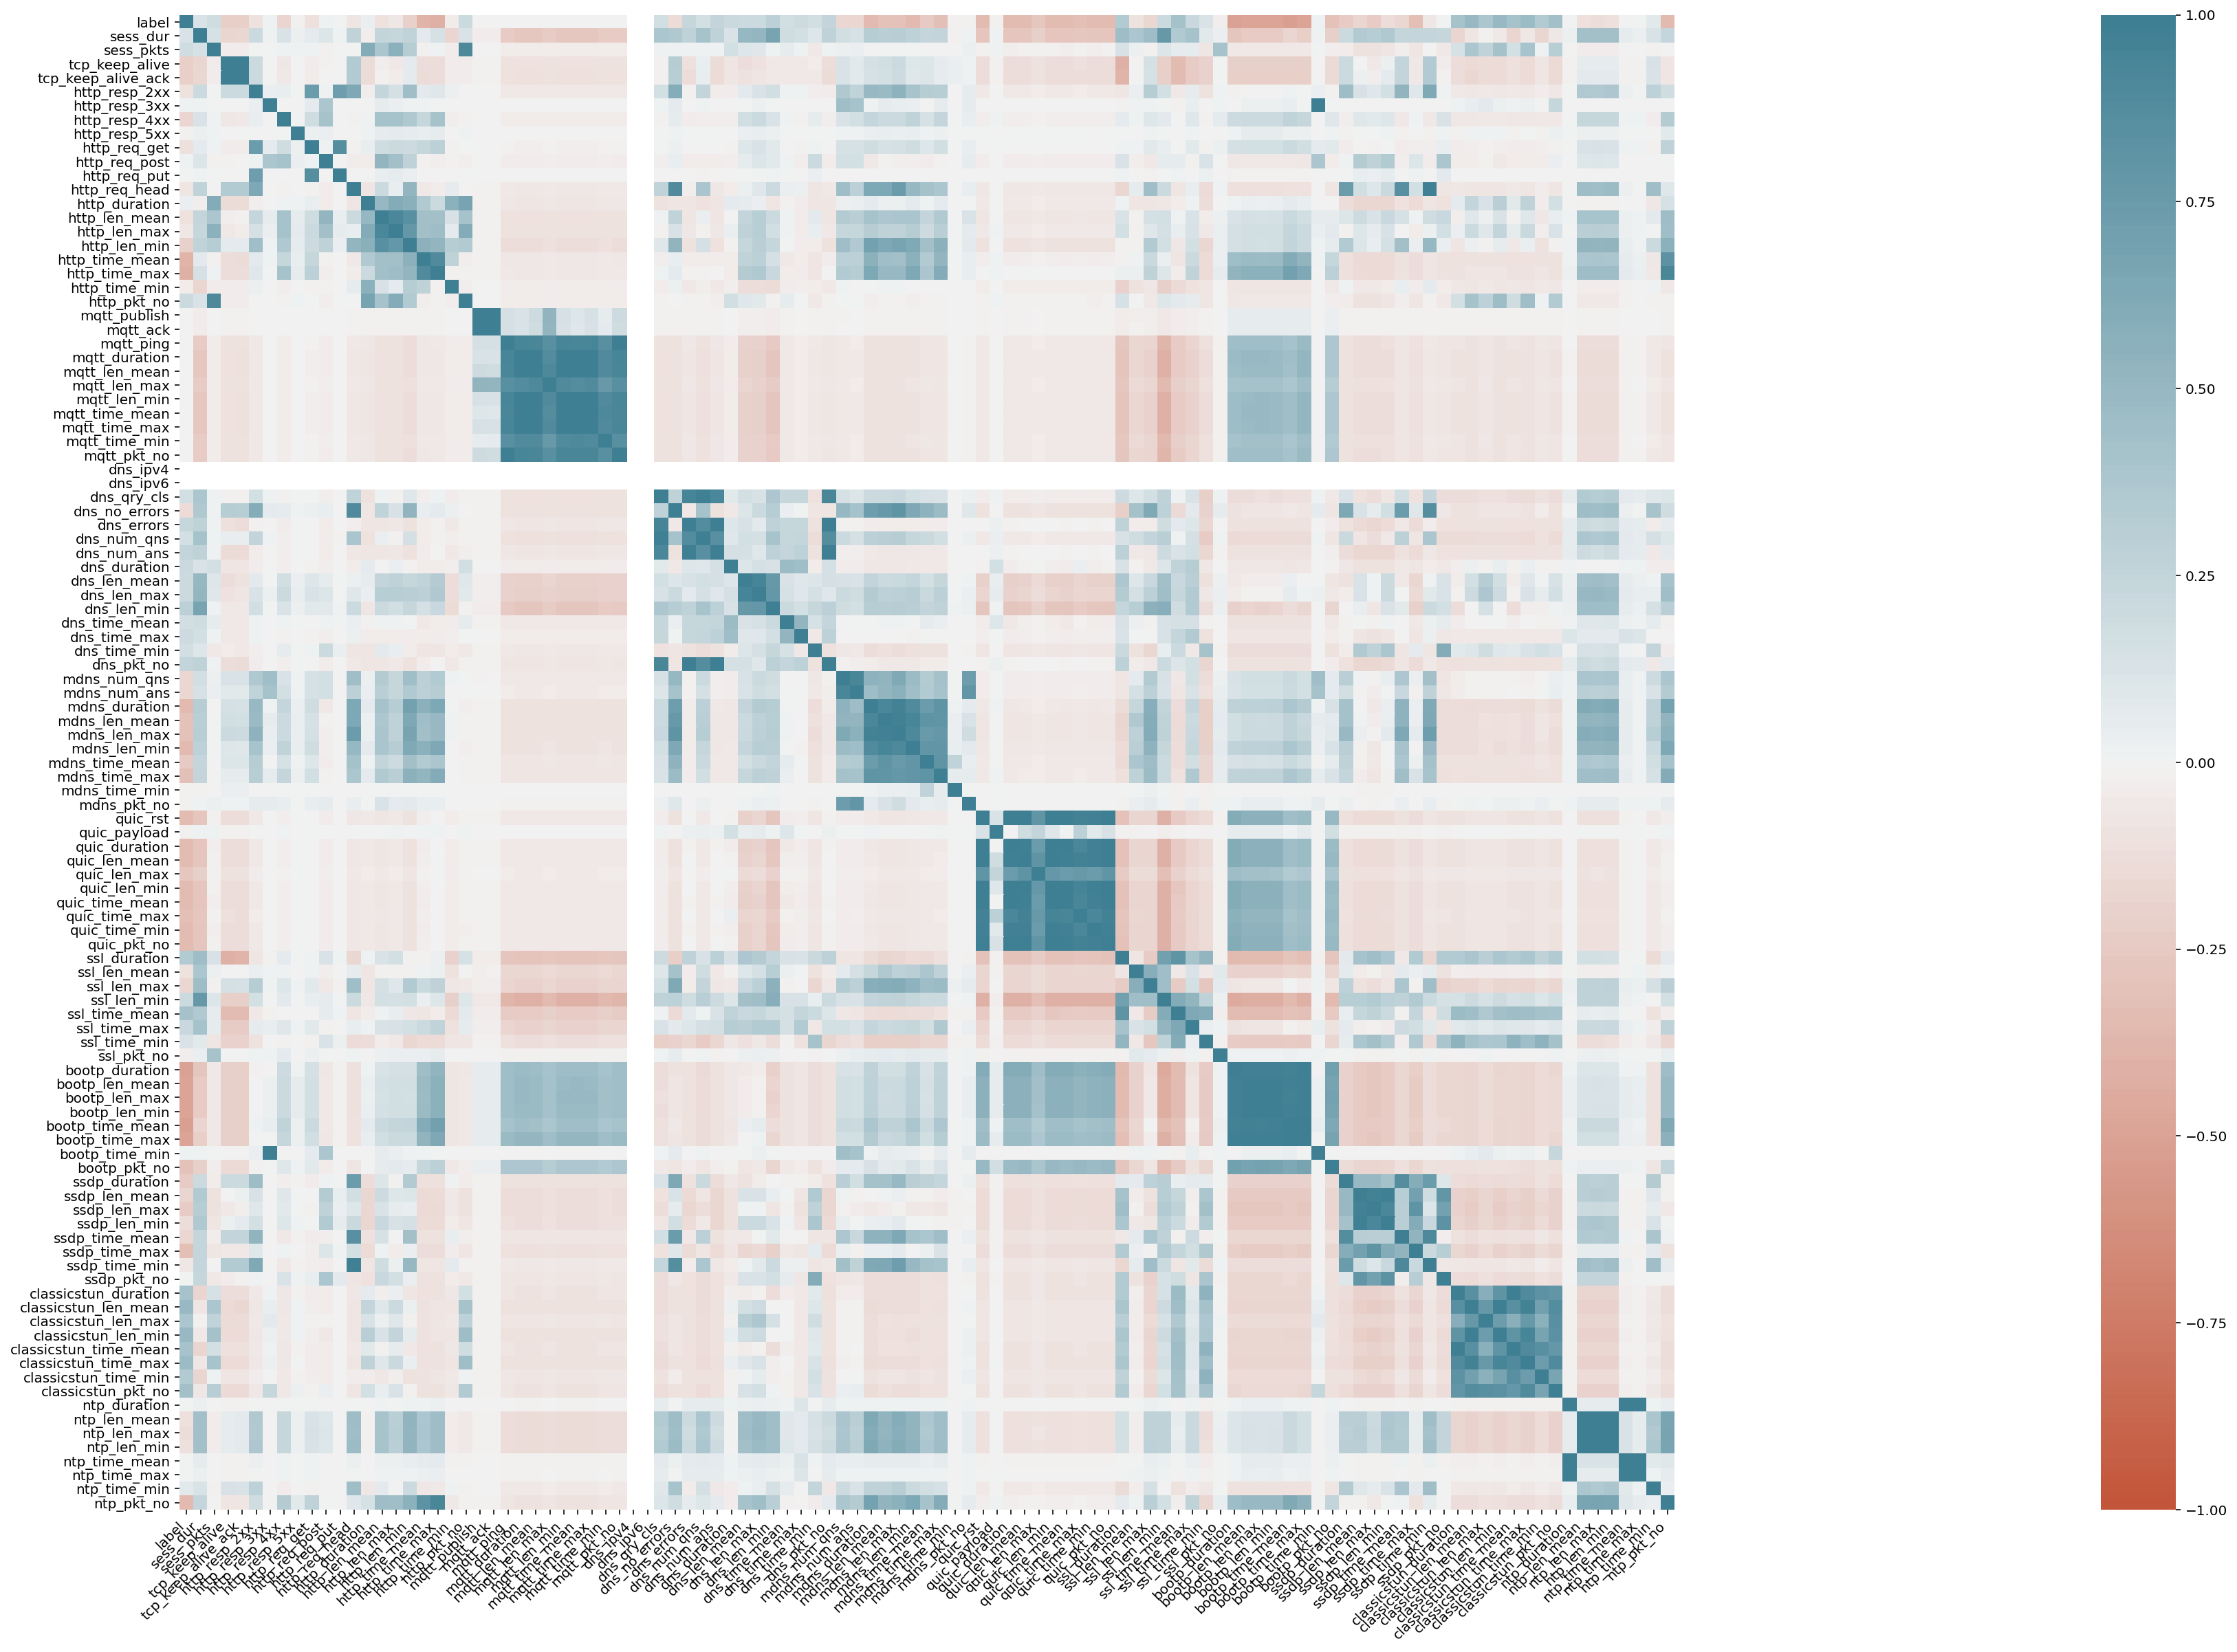

In [4]:
corr = pd_data.corr()
plt.figure(figsize = (111,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [5]:
dns_queries_transform = preprocessing.LabelEncoder()
dns_queries_transform.fit(pd_data['dns_qry_name'])
# le.transform([])
pd_data['dns_qry_name'] = dns_queries_transform.transform(pd_data['dns_qry_name'])

http_uri_transform = preprocessing.LabelEncoder()
http_uri_transform.fit(pd_data['http_uri'])
# le.transform([])
pd_data['http_uri'] = list(http_uri_transform.transform(pd_data['http_uri']))

http_usr_agent_transform = preprocessing.LabelEncoder()
http_usr_agent_transform.fit(pd_data['http_usr_agent'])
# le.transform([])
pd_data['http_usr_agent'] = list(http_usr_agent_transform.transform(pd_data['http_usr_agent']))

mqtt_topic_transform = preprocessing.LabelEncoder()
mqtt_topic_transform.fit(pd_data['mqtt_topic'])
# mqtt_topic_transform.fit(['none', 'nan', 'smart/device/in/022002635ccf7f69e30b'])
# le.transform([])
pd_data['mqtt_topic'] = list(mqtt_topic_transform.transform(pd_data['mqtt_topic']))

mdns_qry_name_transform = preprocessing.LabelEncoder()
mdns_qry_name_transform.fit(pd_data['mdns_qry_name'])
# le.transform([])
pd_data['mdns_qry_name'] = list(mdns_qry_name_transform.transform(pd_data['mdns_qry_name']))

In [6]:
pd_data.sample(frac=1).reset_index(drop=True)

,label,sess_dur,sess_pkts,tcp_keep_alive,tcp_keep_alive_ack,http_resp_2xx,http_resp_3xx,http_resp_4xx,http_resp_5xx,http_req_get,...,classicstun_time_min,classicstun_pkt_no,ntp_duration,ntp_len_mean,ntp_len_max,ntp_len_min,ntp_time_mean,ntp_time_max,ntp_time_min,ntp_pkt_no
0,5,0.000000,350,175.0,174.0,0,0,0,0,0,...,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
1,11,854.464624,3954,0.0,0.0,0,0,0,0,0,...,0.0,0,0.069851,90.0,90.0,90.0,0.034926,0.069767,0.000084,3
2,1,752.912834,712,0.0,0.0,3,0,2,0,4,...,0.0,0,0.136122,90.0,90.0,90.0,0.068061,0.218490,0.000000,14
3,8,220.048998,436,0.0,0.0,0,0,0,0,0,...,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
4,5,0.000000,370,185.0,185.0,0,0,0,0,0,...,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,10,844.835896,179,0.0,0.0,0,0,0,0,0,...,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
7580,5,477.750817,396,185.0,185.0,0,0,0,0,0,...,0.0,0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0
7581,7,874.361796,986,93.0,93.0,14,0,0,0,0,...,0.0,0,0.050873,90.0,90.0,90.0,0.050873,0.051003,0.050743,4
7582,9,883.243707,1016,23.0,23.0,1,0,1,0,0,...,0.0,0,0.000000,90.0,90.0,90.0,0.000000,0.000000,0.000000,2


In [7]:
X = pd_data.loc[:, pd_data.columns != 'label']
y = pd_data['label']
len(X.columns)

111

In [8]:
X_train, X_test, y_train, y_test = train_test_split(pd_data.loc[:, pd_data.columns != 'label'], pd_data['label'], test_size=0.3)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
y_train

(5308, 111) (5308,)
(2276, 111) (2276,)


2259     5
4241     9
5557    11
1185     3
3802     8
        ..
6434    13
5277    11
806      2
4322     9
1614     4
Name: label, Length: 5308, dtype: int64

In [9]:
def train_test(clf, X_train, y_train, X_test, y_test):
#     clf = RandomForestClassifier(n_estimators=100)

    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    f1s = f1_score(y_test, y_pred, average='macro')
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
#     print("F1 Score: ", f1s)
#     print("Accuracy:", acc)
#     print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    return [f1s, acc, precision, recall]

In [10]:
clf = RandomForestClassifier(n_estimators=100)
print(clf)
l = train_test(clf, X_train, y_train, X_test, y_test)
print(l)
scores = cross_val_score(clf, X, y, cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

RandomForestClassifier()
[0.9736713098906254, 0.976274165202109, 0.9773218129775507, 0.9721349264938903]
0.96 accuracy with a standard deviation of 0.02


In [12]:
# clf = svm.SVC(kernel='rbf', random_state = 10)
clf = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo')
print(clf)
l1 = train_test(clf, X_train, y_train, X_test, y_test)
print(l1)
# scores = cross_val_score(clf, X, y, cv=5)
# print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

SVC(C=1, decision_function_shape='ovo', kernel='linear')
[0.9598029578765863, 0.9648506151142355, 0.9664803213030376, 0.9593624717177125]


In [11]:
clf = GaussianNB()
print(clf)
l2 = train_test(clf, X_train, y_train, X_test, y_test)
print(l2)
scores = cross_val_score(clf, X, y, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

GaussianNB()
[0.8692692842937084, 0.8787346221441125, 0.9089970603195796, 0.8855614590265336]
0.83 accuracy with a standard deviation of 0.06


In [16]:
xvals = [l[0], l1[0], l2[0]]
yvals = [l[1], l1[1], l2[1]]
zvals = [l[2], l1[2], l2[2]]
wvals = [l[3], l1[3], l2[3]]
xvals

[0.9736713098906254, 0.9598029578765863, 0.8692692842937084]

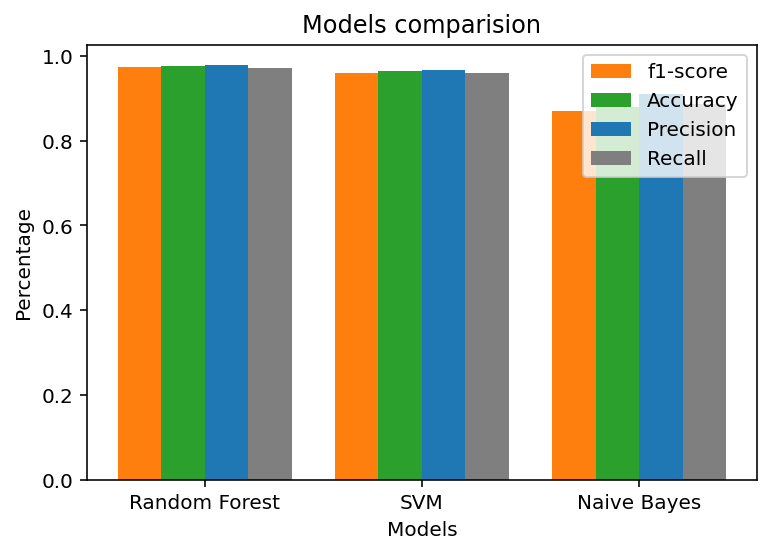

In [35]:
names = ['Random Forest', 'SVM', 'Naive Bayes']
ind = np.arange(3) 
width = 0.2
  
# xvals = [8, 9, 2]
bar1 = plt.bar(ind, xvals, width, color = 'tab:orange')
  
# yvals = [10, 20, 30]
bar2 = plt.bar(ind+width, yvals, width, color='tab:green')
  
# zvals = [11, 12, 13]
bar3 = plt.bar(ind+width*2, zvals, width, color = 'tab:blue')

# zvals = [11, 12, 13]
bar4 = plt.bar(ind+width*3, wvals, width, color = 'tab:gray')
  
plt.xlabel("Models")
plt.ylabel('Percentage')
plt.title("Models comparision")
  
plt.xticks(ind+3*width/2, names)
plt.legend( (bar1, bar2, bar3, bar4), ['f1-score', 'Accuracy', 'Precision', 'Recall'])
plt.show()

In [31]:
plt.savefig('foo.png', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

In [55]:
from itertools import combinations

In [56]:
lables = list(pd_data.columns)
lables.pop(0)
lables

['sess_dur',
 'sess_pkts',
 'tcp_keep_alive',
 'tcp_keep_alive_ack',
 'http_resp_2xx',
 'http_resp_3xx',
 'http_resp_4xx',
 'http_resp_5xx',
 'http_req_get',
 'http_req_post',
 'http_req_put',
 'http_req_head',
 'http_uri',
 'http_usr_agent',
 'http_duration',
 'http_len_mean',
 'http_len_max',
 'http_len_min',
 'http_time_mean',
 'http_time_max',
 'http_time_min',
 'http_pkt_no',
 'mqtt_topic',
 'mqtt_publish',
 'mqtt_ack',
 'mqtt_ping',
 'mqtt_duration',
 'mqtt_len_mean',
 'mqtt_len_max',
 'mqtt_len_min',
 'mqtt_time_mean',
 'mqtt_time_max',
 'mqtt_time_min',
 'mqtt_pkt_no',
 'dns_qry_name',
 'dns_ipv4',
 'dns_ipv6',
 'dns_qry_cls',
 'dns_no_errors',
 'dns_errors',
 'dns_num_qns',
 'dns_num_ans',
 'dns_duration',
 'dns_len_mean',
 'dns_len_max',
 'dns_len_min',
 'dns_time_mean',
 'dns_time_max',
 'dns_time_min',
 'dns_pkt_no',
 'mdns_qry_name',
 'mdns_num_qns',
 'mdns_num_ans',
 'mdns_duration',
 'mdns_len_mean',
 'mdns_len_max',
 'mdns_len_min',
 'mdns_time_mean',
 'mdns_time_max',


In [57]:
fv = ['sess', 'tcp', 'http', 'mqtt', 'dns', 'mdns', 'quic', 'ssl', 'bootp', 'ssdp', 'classicstun', 'ntp']

In [59]:
comb_fv = []
l = [1, 2, 3]
for i in range(1, len(fv) + 1):
    [ comb_fv.append(j) for j in list(combinations(fv, i))]
#     comb_fv.append(list(combinations(l, i)))

len(comb_fv)
# list(comb_fv[3])
# comb_fv

[('sess',),
 ('tcp',),
 ('http',),
 ('mqtt',),
 ('dns',),
 ('mdns',),
 ('quic',),
 ('ssl',),
 ('bootp',),
 ('ssdp',),
 ('classicstun',),
 ('ntp',),
 ('sess', 'tcp'),
 ('sess', 'http'),
 ('sess', 'mqtt'),
 ('sess', 'dns'),
 ('sess', 'mdns'),
 ('sess', 'quic'),
 ('sess', 'ssl'),
 ('sess', 'bootp'),
 ('sess', 'ssdp'),
 ('sess', 'classicstun'),
 ('sess', 'ntp'),
 ('tcp', 'http'),
 ('tcp', 'mqtt'),
 ('tcp', 'dns'),
 ('tcp', 'mdns'),
 ('tcp', 'quic'),
 ('tcp', 'ssl'),
 ('tcp', 'bootp'),
 ('tcp', 'ssdp'),
 ('tcp', 'classicstun'),
 ('tcp', 'ntp'),
 ('http', 'mqtt'),
 ('http', 'dns'),
 ('http', 'mdns'),
 ('http', 'quic'),
 ('http', 'ssl'),
 ('http', 'bootp'),
 ('http', 'ssdp'),
 ('http', 'classicstun'),
 ('http', 'ntp'),
 ('mqtt', 'dns'),
 ('mqtt', 'mdns'),
 ('mqtt', 'quic'),
 ('mqtt', 'ssl'),
 ('mqtt', 'bootp'),
 ('mqtt', 'ssdp'),
 ('mqtt', 'classicstun'),
 ('mqtt', 'ntp'),
 ('dns', 'mdns'),
 ('dns', 'quic'),
 ('dns', 'ssl'),
 ('dns', 'bootp'),
 ('dns', 'ssdp'),
 ('dns', 'classicstun'),
 ('dns

In [89]:
scores = []
print("F1\t\tAcc\t\tprecision\t\trecall")
for i in comb_fv:
    temp = [j for j in lables if j.split("_")[0] in i]
    X_train, X_test, y_train, y_test = train_test_split(pd_data[temp], pd_data['label'], test_size=0.3)
    clf = RandomForestClassifier(n_estimators=100)
    l = train_test(clf, X_train, y_train, X_test, y_test)
    scores.append(l)
    print(l)
#     break
# for i in lables:
#     m = i.split("_")[0]
#     if m in comb_fv[23]:
#         temp.append(i)

F1		Acc		precision		recall
[0.83010425492038, 0.827768014059754, 0.8337160297698852, 0.8277282802137442]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.24242106702950206, 0.3405096660808436, 0.29012181924730523, 0.2845682623002498]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.22915191266313856, 0.31766256590509667, 0.4488016610152833, 0.2497361757293409]
[0.08056244830438379, 0.15905096660808435, 0.07442289935364728, 0.13333333333333333]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5928265173227193, 0.6445518453427065, 0.6631173719358737, 0.598022235079484]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.18091385995172962, 0.2491212653778559, 0.2574226844320802, 0.21194273562694615]
[0.08153430826394728, 0.17398945518453426, 0.11762872556979304, 0.1307775256305023]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7708406498470927, 0.7987697715289982, 0.8305138795288687, 0.7893302420313955]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2220081171147809, 0.28163444639718804, 0.30786957232043816, 0.26911937045231826]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.26884716227978456, 0.3541300527240773, 0.3413141923436041, 0.31061002963496664]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.15100350382314348, 0.24648506151142355, 0.1748759399733976, 0.19448852076466816]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2690447126510333, 0.3290861159929701, 0.5407342181212871, 0.28203914385016815]
[0.8926084948217841, 0.9015817223198594, 0.8934375455020576, 0.8940340296598348]
[0.8909921732307586, 0.898506151142355, 0.893876384772535, 0.8907302613574067]
[0.8409139160074112, 0.8405096660808435, 0.8427143585152707, 0.8402263776983455]
[0.9578239715621208, 0.9591388400702988, 0.9603580155895091, 0.9559905682828116]
[0.8940543333871671, 0.9011423550087874, 0.8950625388616459, 0.8944982295928491]
[0.8386044214811874, 0.8387521968365553, 0.8409707160830425, 0.8373920217033607]
[0.9588777441526163, 0.9639718804920914, 0.9634358295885465, 0.9576073758042537]
[0.8558051992376318, 0.8523725834797891, 0.857707204811696, 0.8554285268899755]
[0.9210253519356201, 0.9270650263620387, 0.9207926839660174, 0.9224779971169812]
[0.8618784020082093, 0.8572056239015817, 0.8650664793248007, 0.8619687049435403]
[0.8867150141634195, 0.8949912126537786, 0.8910052114156527, 0.8849165735068797]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3843006347404533, 0.47451669595782076, 0.5267991540075452, 0.4145923216628421]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.305456545228065, 0.3866432337434095, 0.34697328357950125, 0.3488316073319081]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6512675816218721, 0.6924428822495606, 0.7182477280412204, 0.6605489235584332]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3341642787574497, 0.4283831282952548, 0.4048855570914395, 0.3748412506407195]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3041900287301224, 0.38708260105448156, 0.4088963162877777, 0.3471585267822792]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8094077305177663, 0.8449033391915641, 0.8319372297804049, 0.8344100901075133]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4530893934420334, 0.5096660808435852, 0.6003526676333466, 0.48638660113153154]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.39505636771490404, 0.45166959578207383, 0.4334169123839147, 0.4395362775899146]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3841141855331202, 0.47539543057996486, 0.46309071444465477, 0.4166265722504259]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4041555144008973, 0.4538664323374341, 0.6323178248919403, 0.4205555348677292]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2883766846700625, 0.35281195079086114, 0.5457544280902134, 0.30951132234793116]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6199082028354131, 0.679261862917399, 0.8487721736868526, 0.6260060544462882]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2597634873296844, 0.3185413005272408, 0.5002007191774008, 0.2719601513833497]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2969725612330342, 0.36687170474516695, 0.5406799821359876, 0.3160200447228804]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.756849145536234, 0.8071177504393673, 0.772346383010544, 0.7857728721839784]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.37028711310685714, 0.4367311072056239, 0.6658085552546453, 0.38946841328409704]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3889766799005601, 0.44595782073813706, 0.5353813463127427, 0.4183621450827816]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.31580135281660826, 0.4108084358523726, 0.49809421327112646, 0.34027101093974627]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3429636540323672, 0.4094903339191564, 0.6602985841948549, 0.33992084392838284]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6499660802701318, 0.6717926186291739, 0.7246912148532092, 0.6537142508555129]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.23716622608237234, 0.28910369068541303, 0.32752835905284106, 0.26827859315204644]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.14741012911381401, 0.22012302284710017, 0.17138637711684884, 0.19884665367121507]
[0.8370961357026663, 0.8369947275922671, 0.8895098188097438, 0.8551618226762484]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.22344212654347687, 0.28910369068541303, 0.32551020408163267, 0.2702031494924591]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3363910953493716, 0.4068541300527241, 0.4083880047294681, 0.3776973703802972]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2123274196905189, 0.29173989455184535, 0.24044326821637746, 0.25318149566975345]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3355591554286124, 0.3866432337434095, 0.5830694937222506, 0.34254414801383365]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5932420005090616, 0.6217047451669596, 0.7217998986283463, 0.599406400713215]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6529177756709272, 0.6845342706502636, 0.719664140692577, 0.6564159724076577]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7722224218033065, 0.8040421792618629, 0.8006009213221771, 0.7922262455296584]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7270244661314643, 0.7530755711775043, 0.7988213299356679, 0.7250310600862827]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7338302664424146, 0.7460456942003515, 0.8702224511581682, 0.7330210104801161]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6359200681309961, 0.6972759226713533, 0.732343092370649, 0.6547107223188893]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5970620187175015, 0.6379613356766256, 0.821693642986016, 0.6013111778131646]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.24748355616440554, 0.3062390158172232, 0.3363308423182797, 0.27651896897480316]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7472987903984013, 0.7926186291739895, 0.7676724437928252, 0.768196549937396]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3193128646451376, 0.37038664323374343, 0.4743371953149731, 0.3451549461579903]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.37852406768800356, 0.4270650263620387, 0.46079003417660747, 0.4067214724305887]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3112964721114718, 0.37346221441124783, 0.37533656668975557, 0.3329852536844442]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.30503425814747775, 0.34402460456942, 0.5909485149726514, 0.3043641787412698]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8181914088552508, 0.851493848857645, 0.8503553640187302, 0.8349949798861227]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2221666433736444, 0.28910369068541303, 0.33371732299279855, 0.27067829180364317]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3323397293717432, 0.4015817223198594, 0.39198952771862683, 0.3733357671520459]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.21254213699118207, 0.2961335676625659, 0.24468289595580486, 0.2530681030054035]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3450901636925042, 0.38884007029876977, 0.5550234418890689, 0.345164683230678]
[0.892564388620595, 0.9002636203866432, 0.9164574688681969, 0.9026075778907489]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7667280128716567, 0.7798769771528998, 0.8179181737482266, 0.7865875390657112]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7826197335815087, 0.7899824253075571, 0.848080183419066, 0.8003753846719053]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7664315166856202, 0.7992091388400703, 0.7943517037337529, 0.7842292489227626]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47583255586540624, 0.5149384885764499, 0.6073918853780709, 0.5099477752836066]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3510619538818273, 0.4068541300527241, 0.3676493151822637, 0.39123449067750943]
[0.4069353873907928, 0.44815465729349735, 0.6779971191460011, 0.40909799437661126]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.41153782573003245, 0.4890158172231986, 0.5094936785141796, 0.4411173876546979]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4122705424291271, 0.46177504393673113, 0.7008005527253355, 0.42849381028747147]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4054772190123112, 0.46748681898066785, 0.6400832106271293, 0.4068099578032482]
[0.9227114349310208, 0.9279437609841827, 0.9235373929239878, 0.92249202647204]
[0.9049826126688404, 0.9125659050966608, 0.9057003204339694, 0.9045892167571902]
[0.965826680883325, 0.9657293497363796, 0.9661475437031577, 0.9656572151718144]
[0.9112646685663012, 0.9169595782073814, 0.9104291718093426, 0.9123193724491597]
[0.9005241561257831, 0.9042179261862917, 0.9034114508056894, 0.8999926161844876]
[0.9537293448271995, 0.9582601054481547, 0.9568260298160943, 0.9526300185019827]
[0.918075391230128, 0.9261862917398945, 0.9193644509384308, 0.9182970305868919]
[0.9372486093630913, 0.9424428822495606, 0.9393571424443935, 0.9365350879795157]
[0.9128598985912428, 0.9182776801405975, 0.9142350594576937, 0.9124029864395028]
[0.908946121752946, 0.9138840070298769, 0.9113932174197747, 0.9074434237418464]
[0.8960260493480138, 0.9024604569420035, 0.8993353397792851, 0.8949735817576474]
[0.9629997334437831, 0.964411247

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.44539698416315027, 0.5030755711775043, 0.6151446265617867, 0.4728975475626878]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6853776350829838, 0.7429701230228472, 0.7709032292869609, 0.698222072309824]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3858640627359822, 0.46045694200351495, 0.5492157262181119, 0.41625182382104103]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45520290942170233, 0.538664323374341, 0.6377553170085961, 0.47852020242293564]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8281719676612492, 0.8774165202108963, 0.8410510903850972, 0.851634592414415]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5196320766135644, 0.5861159929701231, 0.7240347630522161, 0.5476846793604313]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5203956294933012, 0.5689806678383128, 0.5680594178972563, 0.5507904901633521]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47033562121934414, 0.5694200351493849, 0.6108408828067144, 0.5038019093337079]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.46522484848482865, 0.5241652021089631, 0.7567463039931025, 0.4642928553327469]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7279502104171605, 0.7526362038664324, 0.7962021135188465, 0.7330504376140022]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3976513484175926, 0.476713532513181, 0.4598776687185413, 0.43352521988904374]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.37374423316616295, 0.44947275922671354, 0.4498100592615307, 0.41532387799225096]
[0.8866883595205627, 0.9011423550087874, 0.9019053094389295, 0.9035247386640853]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4560720791464031, 0.5224077328646749, 0.5806057639481954, 0.4910112105829903]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45998606429956546, 0.4991212653778559, 0.46509620124526957, 0.5054991290582797]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45827894670752284, 0.538664323374341, 0.5275273853713135, 0.4888091399240786]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.46804097077283857, 0.5065905096660809, 0.6682918950812893, 0.48169694005202784]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6537000432038469, 0.6977152899824253, 0.718944305540923, 0.6630478506172928]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.713229164662818, 0.7363796133567663, 0.7828480788126847, 0.7218147536494678]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8369784937887966, 0.8642355008787346, 0.8591295734747828, 0.8544237167497359]
[0.7929393369459291, 0.8005272407732865, 0.8588044950836142, 0.7953272204859357]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7914051859989761, 0.8075571177504394, 0.862746037567307, 0.7923866079091618]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6952830892876615, 0.7552724077328646, 0.7215364141785214, 0.7170511960239884]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6520452940984196, 0.6818980667838312, 0.7841295611228045, 0.6577219460376885]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.39975068118168616, 0.4837434094903339, 0.4627989246427824, 0.4330764015481479]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8003121060963931, 0.8427065026362038, 0.8120131106558363, 0.8229939956762772]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.465871246251683, 0.5210896309314587, 0.5299630676162213, 0.5012614459341179]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4689443858940875, 0.5268014059753954, 0.5184445763950576, 0.5051209783665352]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47235960170750413, 0.5597539543057997, 0.5093720521065817, 0.5011820444437041]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.41814485707552596, 0.484182776801406, 0.6264612527253323, 0.4310289557769645]
[0.8732689971619852, 0.8862038664323374, 0.8953665008730596, 0.8952220143098982]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4530504382184569, 0.515817223198594, 0.5926332768268314, 0.4865587984727751]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.465792830101759, 0.5166959578207382, 0.5346509253701107, 0.5013209776905394]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4469612310687983, 0.5338312829525483, 0.5522908411296131, 0.47910658974961745]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4702618374575803, 0.5197715289982425, 0.7346588485334311, 0.4799477831483094]
[0.9186880015705551, 0.9442003514938488, 0.9233772704590338, 0.9258867790511742]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.809093815000784, 0.8427065026362038, 0.8273167259654239, 0.8312953132889246]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8208646371559849, 0.8541300527240774, 0.8550120403140823, 0.8437920592219899]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8253532746685879, 0.8532513181019332, 0.8482029185271691, 0.8462964134031261]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.608811890420087, 0.6458699472759226, 0.783232711008781, 0.6374406982593369]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5933493192187957, 0.6621265377855887, 0.6898665367251484, 0.6182413873034113]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5380580718326573, 0.577768014059754, 0.7615354137333391, 0.545364425414643]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5362384414204413, 0.6010544815465729, 0.5785820939371373, 0.5681352845723863]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5492603186361149, 0.5755711775043937, 0.684187627324242, 0.5629781778178562]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5394694592924764, 0.5940246045694201, 0.6992490798511527, 0.5433459691183286]
[0.690714726106015, 0.7324253075571178, 0.8596862861274207, 0.6975350201214592]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3333776222004127, 0.38093145869947276, 0.5714710752465293, 0.3389071105177616]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.36689408832755865, 0.4213532513181019, 0.6004309744513809, 0.3865177015499666]
[0.8469381202542748, 0.8545694200351494, 0.8889547434833341, 0.8657784387024401]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3621807920232179, 0.4310193321616872, 0.5958144329058493, 0.3815455632786024]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.46146728919261604, 0.5109841827768014, 0.6021586689853852, 0.4896339038211738]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3845231278445035, 0.45210896309314585, 0.5200095507248226, 0.40731540402667343]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3963468750534263, 0.45606326889279436, 0.7296292491914769, 0.3948510728272431]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6219087860986486, 0.6805799648506151, 0.7452329104665872, 0.631469915257372]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.686795880793812, 0.7258347978910369, 0.8443932952091172, 0.6923107601632604]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8128768498672476, 0.8260105448154658, 0.8641100444494719, 0.8293885686239916]
[0.7406962363556497, 0.7807557117750439, 0.9203021316417314, 0.7447245728068257]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7415301323810048, 0.7671353251318102, 0.7863812269927413, 0.7505247454352589]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6372440330253092, 0.710896309314587, 0.754835982584181, 0.6627779266340651]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.637153044818817, 0.6682776801405975, 0.8177005611741416, 0.6454111708989304]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3346951028282174, 0.3927943760984183, 0.5771434727764988, 0.34235125791941884]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7497813044281094, 0.8009666080843585, 0.7657796105422154, 0.7828741885127309]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3996341866817127, 0.43321616871704743, 0.6029515592557644, 0.4090752172389173]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4373244869627066, 0.4806678383128295, 0.5337572290431789, 0.45832953674553395]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3619371232230052, 0.4235500878734622, 0.571546558671805, 0.3762289956835569]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.38015054074922094, 0.4116871704745167, 0.6955506224635816, 0.36526038419975587]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8257412861476172, 0.859402460456942, 0.8341373497869357, 0.8455338244068514]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.36344092299521297, 0.4310193321616872, 0.5946628990998513, 0.3818738557453353]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47058746507619614, 0.5364674868189807, 0.6025203572366693, 0.4976052765296534]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3881570460749612, 0.46968365553602814, 0.5536231565945922, 0.4082925745336192]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4079341154619061, 0.46660808435852374, 0.7785609550501871, 0.40264531495544864]
[0.9059961415714892, 0.9173989455184535, 0.9144659135625496, 0.9171748073059152]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7574488976266083, 0.8053602811950791, 0.7761426676293187, 0.7854068426950906]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7876100220214266, 0.812829525483304, 0.8511555991175511, 0.8086102998087389]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7655085761899758, 0.8110720562390158, 0.7826454348920101, 0.7922896548834683]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5346994400825759, 0.5812829525483304, 0.6984079902965512, 0.5614409034918181]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45174294141860166, 0.5114235500878734, 0.8020283911359427, 0.4703396040881402]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4820761082348255, 0.5123022847100176, 0.7895848979914146, 0.47688541655975736]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.48551201237505826, 0.570738137082601, 0.572077003274138, 0.5187382792130246]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.49130212651856303, 0.5443760984182777, 0.6998058363605636, 0.4930469235028142]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4296243454692206, 0.492091388400703, 0.6163428771829893, 0.43257639184534347]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6601158816299963, 0.6766256590509666, 0.7994211421591649, 0.6628996228479693]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7281470764998008, 0.7552724077328646, 0.7953833445742557, 0.7264743181529826]
[0.8484938608696545, 0.8510544815465729, 0.9348351289494894, 0.8588716753710728]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7267483422489962, 0.7548330404217927, 0.7952895337098724, 0.7246262280416644]
[0.8242146360664097, 0.7917398945518453, 0.9239347612125353, 0.8173068158168758]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6904192553684293, 0.7398945518453427, 0.7190228213641258, 0.711004705365713]
[0.6705762580143168, 0.6647627416520211, 0.8521724779732743, 0.6696019581098728]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.31798157181143594, 0.3427065026362039, 0.40196728475048055, 0.34864718025062674]
[0.8377474240978083, 0.8268892794376098, 0.9111317259637672, 0.8557982116055939]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3152240989457577, 0.3545694200351494, 0.5723734150615224, 0.34235664745786215]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4513048441236806, 0.48637961335676627, 0.5292946684269101, 0.47899175108877207]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.37614495781213025, 0.4156414762741652, 0.45124295013457927, 0.39753836883412225]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3758739485922848, 0.40026362038664326, 0.6755275679742581, 0.3758770813313979]
[0.8866164857313529, 0.8971880492091389, 0.8975846393554243, 0.9016037003615782]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.2246610038832095, 0.29393673110720564, 0.3352496824227324, 0.27238662083996984]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.40792040049222245, 0.46748681898066785, 0.5100906169327222, 0.4456611317497346]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.27748170350847307, 0.3427065026362039, 0.3047012884953903, 0.32061780045773164]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.41025748685468266, 0.45166959578207383, 0.6039318269813132, 0.41088391019238063]
[0.8969429463603384, 0.9033391915641477, 0.9290110427801602, 0.9093842453583598]
[0.8401458238997889, 0.8409490333919156, 0.9036953735708579, 0.8574840979054433]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8320990902079319, 0.8519332161687171, 0.8715642898804838, 0.8480778845967467]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8211220666032031, 0.8383128295254832, 0.8490242957217642, 0.8418163033719934]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4853563770657972, 0.5369068541300527, 0.6552223135940672, 0.5163809558395026]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.36101793560927053, 0.4235500878734622, 0.4478156516163762, 0.3964391217262352]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4059245251859916, 0.44639718804920914, 0.780657791162961, 0.41113367981152554]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47716745353460915, 0.5298769771528998, 0.5863848309880137, 0.5063466960394708]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4946755581333631, 0.515817223198594, 0.7778658811479348, 0.5062647686751582]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47588324277508914, 0.5193321616871704, 0.6412955627329617, 0.47520461889139654]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6522813650985114, 0.6840949033391915, 0.7199798786529157, 0.6552792893606516]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.775999848697239, 0.7983304042179262, 0.8359777677524869, 0.7924218475079791]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.725085806800154, 0.7552724077328646, 0.7937437720819663, 0.7246007634426964]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7300896170177733, 0.7376977152899824, 0.8685976555373108, 0.7307836980799379]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6301733380700681, 0.695518453427065, 0.6641909868182515, 0.6506039208536907]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5809042340213111, 0.6300527240773286, 0.7480569741154832, 0.5827851377726887]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8489158241199751, 0.8637961335676626, 0.8772466768010722, 0.8564819072214991]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7202284852172416, 0.7376977152899824, 0.7851485191106068, 0.7208916194445418]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7917589401162882, 0.788664323374341, 0.8664871064870939, 0.7870441181635404]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7053035295269561, 0.7680140597539543, 0.7261514956984387, 0.72022128540837]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6585968290622621, 0.6854130052724078, 0.8233126062848939, 0.6588322905227043]
[0.926820879575872, 0.9187170474516696, 0.9494185722410954, 0.9281429910575644]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7967708487870482, 0.8022847100175747, 0.8529946576121865, 0.8102489493101165]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7801907044744962, 0.8062390158172232, 0.8763901434529617, 0.7944289567709609]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7781178394244893, 0.8036028119507909, 0.8358821422898391, 0.7949024401000374]
[0.8679746238314385, 0.8488576449912126, 0.9337199073930065, 0.8636255629027887]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7603076091295901, 0.789103690685413, 0.7935965889023603, 0.7744668236789284]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7273175294307465, 0.7385764499121266, 0.7937623591086606, 0.7270200147666326]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7731863252041418, 0.7939367311072056, 0.8698067941402111, 0.7877458810634673]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7229372251306807, 0.7394551845342706, 0.8514443061676166, 0.7259076183230972]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6362361583248037, 0.6933216168717048, 0.7877462937245545, 0.6544165777650862]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8159537218694439, 0.8449033391915641, 0.8345906957463634, 0.8337184075472032]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3190097792615271, 0.3563268892794376, 0.44498554867770596, 0.3454374357933115]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4500424253174379, 0.4916520210896309, 0.543698296836983, 0.47137812929397077]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.38237180260568665, 0.4279437609841828, 0.45208899494802957, 0.39869233899612533]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3839563826676175, 0.4125659050966608, 0.5986462590479881, 0.3719912109331486]
[0.8951185349040334, 0.9011423550087874, 0.920621624995986, 0.9036576349675877]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.746468230545439, 0.7877855887521968, 0.7771796610621065, 0.7736615773973842]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7805733793999744, 0.7904217926186292, 0.8562496626803376, 0.7958137346671668]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7677509425717832, 0.7807557117750439, 0.8268897322748339, 0.7872540285722934]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5210947116773607, 0.5557996485061512, 0.6337435897435898, 0.5435707169017194]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4530590246417194, 0.4964850615114236, 0.5831290346520954, 0.4713621084089284]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.446774361424985, 0.46748681898066785, 0.6677649487685332, 0.43774517073019115]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5157956659957562, 0.5654657293497364, 0.573546445564212, 0.5363857567503131]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45536833830259105, 0.48154657293497366, 0.6922290271160454, 0.4567881443502306]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4470299805786394, 0.4872583479789104, 0.5763075149312421, 0.43552147194592]
[0.8954614302139273, 0.898506151142355, 0.9179814577846063, 0.9033698569263802]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8161003464527418, 0.8506151142355008, 0.8416360312405946, 0.8368397381907955]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8274205642235977, 0.8479789103690686, 0.8647291723328746, 0.8426983047037936]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8298794956551614, 0.8484182776801406, 0.8532590348864973, 0.8437987020457733]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.48587747604306963, 0.5584358523725835, 0.6111630369026013, 0.5175369918834964]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3621286386579824, 0.422231985940246, 0.45102629429230673, 0.39869944883097613]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4062894800616378, 0.4446397188049209, 0.5852558264506035, 0.4083430600787244]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47268450160787306, 0.5333919156414763, 0.5086230361283911, 0.5022574659241323]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4967788532999933, 0.531195079086116, 0.6624451738737454, 0.5023493233414429]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4736598648477786, 0.5294376098418277, 0.7091967774279262, 0.4727381434512323]
[0.898090655803191, 0.9072934973637962, 0.9167370612479308, 0.9084207124277558]
[0.9090370001282791, 0.9077328646748682, 0.9405062857004237, 0.9137291271346045]
[0.9170457220437545, 0.9195957820738138, 0.9418847086406104, 0.9190355723899291]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7551079172463492, 0.7934973637961336, 0.7995360644833461, 0.7781300673400222]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7601151914071025, 0.789103690685413, 0.7902913577569557, 0.7832732986445398]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7686832267043306, 0.81195079086116, 0.8005862345570528, 0.7887712744584905]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6209122415495554, 0.6594903339191565, 0.7359749273561095, 0.6417190419881109]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5604570174500179, 0.5869947275922671, 0.7417211053767508, 0.5670837669162115]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5405721544318385, 0.5878734622144113, 0.7661294643815805, 0.5386909448748792]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5486707793617962, 0.5896309314586995, 0.7105295663771148, 0.5573907792503885]
[0.9141436634249217, 0.9191564147627417, 0.9146111986728712, 0.9140531185065631]
[0.9643337883394678, 0.9648506151142355, 0.9650535967112875, 0.9640808855814847]
[0.9246050955497009, 0.9314586994727593, 0.9257630653282791, 0.924930428879831]
[0.9167145028578286, 0.9235500878734623, 0.9173240177937682, 0.9170219615249257]
[0.9589466517415774, 0.9600175746924429, 0.9661673736318364, 0.9572172884206243]
[0.9247892777582651, 0.9318980667838312, 0.9261294967443796, 0.923961078058362]
[0.9493633360518593, 0.95298769771529, 0.9502107261375141, 0.9489114383375782]
[0.9399795909399219, 0.9437609841827768, 0.9452338480497128, 0.9381584629115446]
[0.9152961316247032, 0.9195957820738138, 0.9166959670379176, 0.9144296066644414]
[0.9624168155728474, 0.9648506151142355, 0.964838038264999, 0.960819210745552]
[0.9130682925593485, 0.9204745166959578, 0.9149722263143709, 0.912007753676361]
[0.8979602239414377, 0.905975395430

[0.9709432518825615, 0.9723198594024605, 0.976945211359519, 0.9683715303529585]
[0.9565424076201309, 0.9586994727592267, 0.9652931715214625, 0.9545047483206527]
[0.9388607962285749, 0.945518453427065, 0.9404807932191704, 0.9379718533782957]
[0.8884109846910817, 0.882688927943761, 0.8934593992306883, 0.8869752143573366]
[0.9005474030935601, 0.9042179261862917, 0.9024391119514262, 0.8991485012818938]
[0.934859334719998, 0.9402460456942003, 0.9365807830409542, 0.9347523126617548]
[0.9344674946531312, 0.9398066783831283, 0.9350263828630385, 0.9344774231808477]
[0.9096466845229483, 0.9160808435852372, 0.9184474875727205, 0.9060025088031246]
[0.9558244926165202, 0.9586994727592267, 0.9581693119488772, 0.9545308833833065]
[0.9705819813289468, 0.9705623901581723, 0.9740198807909964, 0.9692207311847497]
[0.9634999082474529, 0.9657293497363796, 0.9653414702267342, 0.9625216830635187]
[0.9711609156771811, 0.9705623901581723, 0.9716751624542026, 0.9710267344527461]
[0.9685407076367982, 0.970123022

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45685602503794187, 0.5268014059753954, 0.5431186986203256, 0.48350634794324787]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5172229712131171, 0.5909490333919156, 0.7020722898324476, 0.542605036391159]
[0.9002142886428085, 0.9239894551845342, 0.9090909908238801, 0.9134060153158233]
[0.5241549983611906, 0.5883128295254832, 0.7486211051874005, 0.54865282514655]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5896767721419731, 0.6436731107205624, 0.6378767907596755, 0.6167586631830627]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5480010472438717, 0.6362038664323374, 0.7056629115417096, 0.5756366331208653]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5247525068379134, 0.5645869947275922, 0.7871288330518376, 0.5242857463001136]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6840462910378757, 0.7429701230228472, 0.8201625998106274, 0.6966956978764277]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7493347532306708, 0.789103690685413, 0.8285645190227229, 0.7592268954159647]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.850415722081382, 0.8857644991212654, 0.8689398890261235, 0.869668019869477]
[0.806756242147957, 0.8211775043936731, 0.8960178753790431, 0.8179942312656895]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8184517843784729, 0.8383128295254832, 0.863641086884551, 0.823978359818039]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7067507195569074, 0.773286467486819, 0.7874747321867578, 0.731896215598087]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6733478535975478, 0.7337434094903339, 0.7887635557327533, 0.6868887326241394]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4574304251266828, 0.5430579964850615, 0.565042910042569, 0.4885393671238527]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8219091546673793, 0.8708260105448155, 0.8279169558118605, 0.8477168018228891]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5277963072707158, 0.6028119507908611, 0.7588945789009145, 0.5524472343105864]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5266087300158789, 0.6019332161687171, 0.5690979058643709, 0.5587955377587356]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47571670341641603, 0.562390158172232, 0.5456001336071181, 0.5053806623022892]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.475817279081438, 0.5377855887521968, 0.7407701685994302, 0.47569639865876684]
[0.9024514343245322, 0.930140597539543, 0.9311467004734395, 0.9207037737598464]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5158629360544248, 0.5839191564147628, 0.685658709723819, 0.5417436370540483]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5966798784655992, 0.6537785588752196, 0.644763423860281, 0.6207534024500982]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.544474586943236, 0.6335676625659051, 0.7073437281838567, 0.5704292785256391]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5308034341382225, 0.5975395430579965, 0.7403232978039206, 0.5338980019127008]
[0.9481538279625837, 0.9477152899824253, 0.9491390066115236, 0.9494032723031284]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8262845788156772, 0.8730228471001757, 0.8379849749071417, 0.8491538349104055]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8397908459651374, 0.8778558875219684, 0.8569706573668301, 0.8585654049952601]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8473286738282646, 0.8835676625659051, 0.8626320014306117, 0.8656621319253658]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6605728841427384, 0.6968365553602812, 0.7846641462058919, 0.6849493809757856]
[0.6118607944946642, 0.6928822495606327, 0.8851657331617743, 0.6377607245544886]
[0.5947205506623888, 0.6278558875219684, 0.8135949156880071, 0.5915575440656934]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.616930213797074, 0.6788224956063269, 0.644201159567194, 0.647836208918065]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.618414505416512, 0.6445518453427065, 0.7676415671203638, 0.616218422484761]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5551494053216951, 0.6265377855887522, 0.7389088374158487, 0.5661959067755473]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7110760782096402, 0.7407732864674869, 0.7730640779594056, 0.718029126825425]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7830003035285585, 0.7983304042179262, 0.8569663701715925, 0.7860682245783693]
[0.9182959143319243, 0.921353251318102, 0.9420058321062095, 0.9224834704154057]
[0.7929662699396118, 0.7983304042179262, 0.8562052004801096, 0.7973497812878357]
[0.8634453708570057, 0.843585237258348, 0.9262878105671706, 0.860305577772444]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7606498473680829, 0.8022847100175747, 0.7882431640619278, 0.7815241733186064]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7227434952297723, 0.7376977152899824, 0.8508235104483928, 0.7289478303872934]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4689869001836769, 0.5281195079086116, 0.5959330339463931, 0.5055785135781621]
[0.8857695773637058, 0.8963093145869947, 0.9047945133062784, 0.9016338773332214]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.46829069205026314, 0.5294376098418277, 0.5826461047864496, 0.5046806373407152]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5428398739144988, 0.5883128295254832, 0.6282428746338705, 0.5797623945733217]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5365957775425723, 0.593585237258348, 0.5732191626359976, 0.5677842521242756]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.484166508822257, 0.5285588752196837, 0.6655347864364287, 0.49541143999794807]
[0.9182825566991322, 0.9314586994727593, 0.9335879762370183, 0.9268943609751006]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45845306899887706, 0.5241652021089631, 0.6683828274306879, 0.4928664798734532]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5292936823730217, 0.570738137082601, 0.5700400120728523, 0.5704505750009871]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5259649766332537, 0.6010544815465729, 0.6206970268309376, 0.553530925950199]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5416701919681977, 0.5742530755711776, 0.7130950889860416, 0.5460812176505597]
[0.9186749911436575, 0.9406854130052724, 0.9281072564836865, 0.92815686043674]
[0.8946872671908833, 0.9033391915641477, 0.9164410124068028, 0.9041078123508827]
[0.9088124391708551, 0.913444639718805, 0.9354167773738384, 0.9167011012379078]
[0.9065729280315558, 0.9090509666080844, 0.9302102417393634, 0.9134348267442943]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6060176741605197, 0.6423550087873462, 0.6855481815170553, 0.6374653850925939]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5980847138413631, 0.6630052724077329, 0.7193140047746187, 0.6206457906725585]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5482964364627306, 0.5922671353251318, 0.7415097894456337, 0.5538484737536249]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.60399745366321, 0.6520210896309314, 0.7129032779462331, 0.6309885164814699]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6160837825305905, 0.6392794376098418, 0.7768950936568626, 0.6262466115780786]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6172339020348653, 0.6586115992970123, 0.7766211435305096, 0.6204027288635892]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.718760463073452, 0.7429701230228472, 0.7857546169932342, 0.7293654853414004]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.836053744880996, 0.8563268892794376, 0.8532367912144735, 0.8501715173670927]
[0.7892229550374642, 0.7860281195079086, 0.853516731555443, 0.7967706708659381]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7910751902420742, 0.7939367311072056, 0.8551907404987799, 0.7923684174015065]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6885172472378439, 0.7508787346221442, 0.7146833292449437, 0.7132640389139346]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.651677109681309, 0.7078207381370826, 0.74767684999649, 0.6599284972401768]
[0.914480319606919, 0.9116871704745168, 0.9381806545375483, 0.9215350688608596]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7831556513448324, 0.7913005272407733, 0.855329595289062, 0.7876745500738037]
[0.8540472271344214, 0.8396309314586995, 0.9278228132753933, 0.852097505189003]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.751487190653165, 0.7974516695957821, 0.7811423781951418, 0.7752579603263006]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7072968878636294, 0.7297891036906854, 0.8444689847440721, 0.7169342732483408]
[0.9509323396056929, 0.9578207381370826, 0.9671845151738073, 0.9512094089146039]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8526290800908368, 0.8800527240773286, 0.8668605609699317, 0.8681171688972059]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8356478363999025, 0.8567662565905096, 0.8652748549447866, 0.8548650157715448]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8371541801406879, 0.8598418277680141, 0.8601440119013916, 0.8525018150344184]
[0.9057016244601684, 0.9007029876977153, 0.9481394993894995, 0.89596605865413]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8326232528366865, 0.8550087873462214, 0.8558691207349082, 0.8500257447813303]
[0.791957352232723, 0.8079964850615114, 0.8917004116403188, 0.7950889582781399]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8320167224785372, 0.8532513181019332, 0.8641092471220227, 0.8464626420784904]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7959167843677762, 0.8040421792618629, 0.8640114202833689, 0.7967629868417574]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6988005195272764, 0.7653778558875219, 0.7541419573461072, 0.7231645025213831]
[0.8817715925913401, 0.8998242530755711, 0.892933013069023, 0.8985475872888916]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4642429090058953, 0.5131810193321616, 0.5995727470228961, 0.5011690425924075]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5468129208152761, 0.6006151142355008, 0.6240397223979252, 0.5811568461695635]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5289469594134296, 0.6023725834797891, 0.564847531770653, 0.5542122292588413]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4873592906890264, 0.5377855887521968, 0.7309563056942738, 0.4968323512640732]
[0.9130908593898109, 0.9367311072056239, 0.9200712207567281, 0.9233831406124191]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.810587279824701, 0.8501757469244289, 0.8262758308438194, 0.8348616274638023]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.825798362002396, 0.8567662565905096, 0.8581172931690347, 0.8467102737469359]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.822964813557537, 0.8585237258347979, 0.8455698967665886, 0.8424217546531766]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.607500941409017, 0.6449912126537786, 0.7616644373217603, 0.6427522468977451]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6108720914427186, 0.6603690685413005, 0.748570727754794, 0.6352338467297101]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5570264871233047, 0.5953427065026362, 0.7979352575762649, 0.5603584371240959]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6142626264382084, 0.6665202108963093, 0.6520459082505907, 0.6446073980927335]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5513818125414542, 0.5751318101933216, 0.7114768056276951, 0.5656771263135549]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5519878791294471, 0.5992970123022847, 0.6994526970113939, 0.5582588434532381]
[0.919478343553587, 0.9446397188049209, 0.9320131429147983, 0.9282075461287821]
[0.886469857105418, 0.9037785588752196, 0.9061183760485333, 0.9053956204243865]
[0.8942866366115091, 0.9020210896309314, 0.9406332404685345, 0.9091553622978238]
[0.910390637043637, 0.9121265377855887, 0.9282712102928465, 0.9181634659053904]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6103654384108502, 0.6335676625659051, 0.701668971554956, 0.6419951824975213]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5855024953887877, 0.6480667838312829, 0.6272364813395458, 0.6114843551717841]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5510173469580344, 0.5808435852372583, 0.76532738733148, 0.556365782970733]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6008918766921857, 0.6489455184534271, 0.6606238119205196, 0.6283552738181973]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6290563790318096, 0.640597539543058, 0.809067943736704, 0.6361990099666719]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6129192934751048, 0.6542179261862917, 0.7750210079367018, 0.6144694703323208]
[0.9171107682235539, 0.9358523725834798, 0.9319874946686147, 0.9269543432832467]
[0.9353829196413646, 0.9494727592267135, 0.9576369844827002, 0.9387076278605833]
[0.9332837806038217, 0.95298769771529, 0.9514769782823959, 0.9364098490436549]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8226289515375631, 0.8541300527240774, 0.8537698043484144, 0.843265329239302]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8200726106065092, 0.8479789103690686, 0.8531204183527675, 0.8453822908802444]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8308714146006335, 0.8558875219683656, 0.8592337270004757, 0.8502555880014223]
[0.7463915510070915, 0.7710896309314587, 0.8443809662782513, 0.7662342653199707]
[0.6840977155713115, 0.6928822495606327, 0.8847886021014527, 0.6878873305951717]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6781178570240104, 0.7179261862917399, 0.8265991295930629, 0.680001575970418]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6963748648198961, 0.7174868189806678, 0.7817702143546458, 0.696249582263629]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6896826756316125, 0.7253954305799648, 0.8385462788280599, 0.6952009402947135]
[0.7486275022665309, 0.7728471001757469, 0.8675884072653125, 0.7555399977003265]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8422844574122059, 0.8681898066783831, 0.8562992487198273, 0.8566854636436089]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7496474067787521, 0.7772407732864675, 0.8391666566014109, 0.7533945680344787]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8159432560989789, 0.8159050966608085, 0.8635589241151346, 0.8172132661113082]
[0.7128825960526995, 0.7618629173989455, 0.8999665804833538, 0.7322374336385973]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6867811631074432, 0.7126537785588752, 0.8257964483180833, 0.6945358809479691]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.40100751216269187, 0.4389279437609842, 0.5708926103155212, 0.4069020399590526]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8357185273646477, 0.8659929701230229, 0.8542394143888767, 0.8558236634155881]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4024617556930439, 0.44112478031634444, 0.6085321979296906, 0.4117775227770331]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4938408295864741, 0.5342706502636204, 0.5900959361335408, 0.5128597895601071]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4169407627335207, 0.4718804920913884, 0.6086548769307772, 0.42910387501884195]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.43590359237344223, 0.46177504393673113, 0.7488806312565863, 0.42003102984641083]
[0.9077589387950514, 0.9244288224956063, 0.9257105068658341, 0.9147714263393116]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.35854820744355176, 0.4147627416520211, 0.6035595970724709, 0.37842564834649733]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5346761056736243, 0.5878734622144113, 0.669905390614052, 0.5601520201359773]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4550159760524909, 0.5298769771528998, 0.6302254253042955, 0.4748781367916411]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.465577568839057, 0.5074692442882249, 0.671042245305886, 0.46519365940217283]
[0.9050873144072099, 0.9182776801405975, 0.9244314311357996, 0.9157932829012321]
[0.8546859851654023, 0.8545694200351494, 0.8991233237914925, 0.8713844703311525]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8420753063331458, 0.8708260105448155, 0.8698386874832045, 0.8594114106233889]
[0.8594072264522605, 0.8659929701230229, 0.9176043229882128, 0.8743549364922775]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5411566735683953, 0.6006151142355008, 0.7397756126365516, 0.5656013001792629]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.44152671117337783, 0.5140597539543058, 0.6230162951774341, 0.4652549385335591]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4814123803821964, 0.5193321616871704, 0.8228623319274069, 0.4760392872262778]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5566400151384469, 0.6225834797891037, 0.6618779911794689, 0.5863618688638244]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5502055657437531, 0.5773286467486819, 0.7775513087338838, 0.5504807599996842]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.48962647603777687, 0.5320738137082601, 0.7300559120971911, 0.49233155811316076]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6792745680316997, 0.7236379613356766, 0.7686320396982549, 0.6861909474893337]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7894055399547018, 0.835676625659051, 0.8043248368584505, 0.8098765328796586]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7567503875409977, 0.7855887521968365, 0.8649608844597358, 0.759887297206851]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7657398846148066, 0.7671353251318102, 0.8579896368409741, 0.7697302447490889]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6626127141856194, 0.7117750439367311, 0.7499144708180886, 0.68234082902515]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6147659148593385, 0.6687170474516696, 0.7349264468826929, 0.6249707224911354]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8645430947590208, 0.8923550087873462, 0.8789530462529742, 0.8740792413585687]
[0.7515165580906473, 0.7772407732864675, 0.8751730682057415, 0.7567335008282617]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8169558228447582, 0.8273286467486819, 0.8680661989701146, 0.8159757298452318]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.713971672029209, 0.7820738137082601, 0.7874895349539721, 0.7321586256494652]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6887224282906791, 0.7447275922671354, 0.8006030929341321, 0.6923240255080074]
[0.9371957472127919, 0.9424428822495606, 0.9578361031755763, 0.9365375198168034]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.786493363355172, 0.8242530755711776, 0.8668124956556924, 0.805611715235163]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7867711649891238, 0.8295254833040422, 0.8656258437187904, 0.8073599110201466]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8075553271890585, 0.8220562390158173, 0.8601513667697243, 0.8247948961630356]
[0.8952481356710382, 0.8888400702987698, 0.9424393053337405, 0.8887078852316965]
[0.7862588483847843, 0.8308435852372583, 0.9031386272994489, 0.7972134322902243]
[0.7466650539627423, 0.7759226713532513, 0.9242780113061367, 0.7509974184351129]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7819541166513628, 0.8163444639718805, 0.7942481104398366, 0.7964697219156122]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7626687722378188, 0.7447275922671354, 0.8549403839352604, 0.7649641451407071]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6640233093443921, 0.7157293497363796, 0.8210082338081726, 0.6826830171088909]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8309297064196726, 0.8774165202108963, 0.8397525388481206, 0.8497245405319964]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.40541818589862877, 0.44024604569420034, 0.6570072889191413, 0.41267275268976117]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5010193940449619, 0.5439367311072056, 0.6104567046396859, 0.5176705272794849]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.42172683107095416, 0.4811072056239016, 0.5740599288891407, 0.43272586514871975]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.44921013576614316, 0.4797891036906854, 0.6742232461951105, 0.4330388657530406]
[0.9145751338236396, 0.9389279437609842, 0.941663287830775, 0.923114274156278]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7715921222183734, 0.8057996485061512, 0.8286729073041492, 0.8005609619326658]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7900873217284368, 0.812829525483304, 0.85788879747626, 0.8087577520676094]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7702428063807473, 0.8163444639718805, 0.7829828237308842, 0.7912805776598879]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5747444562692106, 0.6089630931458699, 0.7450224362284189, 0.588296486864299]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4917094973962628, 0.5202108963093146, 0.7668323572940612, 0.5022847590564196]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5072364026670653, 0.5219683655536028, 0.799428115249686, 0.4945044966634141]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5258771737718606, 0.5878734622144113, 0.5786722550653018, 0.5480781709763929]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.527472304292372, 0.5483304042179262, 0.725494774020003, 0.5175050641539541]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.466429026821502, 0.5118629173989455, 0.7050131744999518, 0.4637673251219287]
[0.9083064065992619, 0.9248681898066784, 0.9196731680398166, 0.9156464516109473]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8318475522045061, 0.8774165202108963, 0.8467281621886885, 0.8538146356460853]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8436411268162919, 0.8774165202108963, 0.8660525763293464, 0.8574900560991139]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8481039757704122, 0.8866432337434095, 0.8633954281325559, 0.8635369733379233]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5382856761088861, 0.601493848857645, 0.6764193620560817, 0.5617700551798168]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.46184484423621097, 0.5241652021089631, 0.7464055488763252, 0.47747812301223436]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.466502369463834, 0.5096660808435852, 0.7489021051163983, 0.4661579149873033]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5594284322267448, 0.6221441124780316, 0.6304467804500066, 0.5924945177536626]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5533846460078163, 0.5918277680140598, 0.7981196367463823, 0.5511475893354352]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5045210754510837, 0.5812829525483304, 0.7437598580532377, 0.5080377595465515]
[0.9096588411796644, 0.9195957820738138, 0.9415465027530937, 0.9205871948588722]
[0.9205869085112967, 0.9358523725834798, 0.9499557681251046, 0.9260835060474676]
[0.9216641514765875, 0.9253075571177505, 0.9400233857780176, 0.9266737537132764]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7754519787292631, 0.8181019332161688, 0.8013301641606383, 0.7973954106367049]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7938766611924505, 0.8167838312829525, 0.838331941939377, 0.811522445410415]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.78222201709724, 0.8229349736379613, 0.795692120993712, 0.8009586502773377]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6332725168750752, 0.6999121265377856, 0.7485397236794157, 0.6569391719702576]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.622090657516511, 0.6379613356766256, 0.8534726750096401, 0.6185145704895952]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5707439238948058, 0.6274165202108963, 0.7603521055485083, 0.5702170796742521]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5761778012243651, 0.6300527240773286, 0.7127025354134182, 0.5847949041737189]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7283075896887699, 0.7363796133567663, 0.7964980964470122, 0.7291097211454548]
[0.8727662454335939, 0.8510544815465729, 0.9354154089378649, 0.8780099847064133]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7235035536814809, 0.742091388400703, 0.7982408661343204, 0.7236874362965086]
[0.7931342882480006, 0.7877855887521968, 0.9266333240879548, 0.7895391578487782]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6982101737168631, 0.7376977152899824, 0.7244254944676157, 0.718969016889782]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6555732532764819, 0.6849736379613357, 0.8549386790086072, 0.6597665478837136]
[0.9189649956138362, 0.9147627416520211, 0.9485216045997605, 0.9179961007474561]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7252942683767489, 0.7407732864674869, 0.7974089573148719, 0.7251497407461659]
[0.8676792670216594, 0.8536906854130053, 0.9317689440307652, 0.8578737165778618]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7692851394454311, 0.8005272407732865, 0.8000304484266946, 0.7795432915211826]
[0.7214936291690761, 0.7412126537785588, 0.9156907576193951, 0.7213167331751092]
[0.9185694017420298, 0.9182776801405975, 0.9396187174519469, 0.9200232274975929]
[0.8673306272113164, 0.8484182776801406, 0.924663364374528, 0.8752015202347715]
[0.850167471355112, 0.859402460456942, 0.9422136671172179, 0.8597704063846601]
[0.8624722444167843, 0.8457820738137083, 0.9204066931308584, 0.8725214459162988]
[0.8618837023461027, 0.8418277680140598, 0.9286207183528613, 0.8534230959044387]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7613747516007182, 0.788664323374341, 0.7917345323761982, 0.7737545968688315]
[0.729114301640654, 0.742091388400703, 0.9307017314551722, 0.7266695777211213]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8420605519440989, 0.8466608084358523, 0.8697434088096264, 0.8501060236920258]
[0.8082348417645263, 0.7798769771528998, 0.923439330990547, 0.8032899250588322]
[0.7138223923734521, 0.7324253075571178, 0.8536710656755558, 0.7293842464193324]
[0.8911556626499152, 0.8980667838312829, 0.9169836364529154, 0.9034972168519266]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.3178373709460663, 0.3615992970123023, 0.4711923657411655, 0.3466393974524537]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5178071558694468, 0.5369068541300527, 0.6072361743904297, 0.5400969500995797]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.44729705281841664, 0.4969244288224956, 0.5097171593166324, 0.4696902177505973]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4517066749640198, 0.46353251318101935, 0.7265485595800513, 0.44546140043981963]
[0.8976208986307023, 0.9024604569420035, 0.9249416107706413, 0.9050309560718796]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.817735244859809, 0.8334797891036907, 0.8309912109958261, 0.8366142737691287]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.830199386333346, 0.8431458699472759, 0.8676948845267441, 0.8454652143507277]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8290132843912056, 0.8396309314586995, 0.8465156682618287, 0.8432801617466533]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5258339747110201, 0.5514059753954306, 0.6359199345588646, 0.5482787873316823]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45504714112617156, 0.4916520210896309, 0.5201471007262396, 0.47391985086854815]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4454385276355474, 0.47144112478031636, 0.7794381584448317, 0.437566076235979]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5867402750425773, 0.6054481546572935, 0.654634663582032, 0.6038875938422166]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5320485580911081, 0.54701230228471, 0.768714769877005, 0.5330940573332021]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5169319739727101, 0.5351493848857645, 0.7043890871037191, 0.5070257376881736]
[0.8927906458179872, 0.8993848857644992, 0.9158892872748395, 0.9009791248511146]
[0.8921117461842828, 0.8976274165202109, 0.9062017050156519, 0.9009363281971025]
[0.9052462959606394, 0.9086115992970123, 0.9538779522315018, 0.9111542813653302]
[0.9114560897343846, 0.9191564147627417, 0.9420680798308005, 0.9142500932516331]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.47923394761138804, 0.5307557117750439, 0.6319903270410371, 0.5132703197201636]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.36287228193842663, 0.4204745166959578, 0.4543979064341055, 0.3978745484400657]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.42322303105691095, 0.4710017574692443, 0.7055482226273581, 0.4215511387856165]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5498808331130977, 0.6019332161687171, 0.6586888026063282, 0.5757315625001328]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5676871294459482, 0.6019332161687171, 0.7743832093619718, 0.5704575289725019]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5388469508827824, 0.562390158172232, 0.7027327203354738, 0.5372918076854545]
[0.8857997959033327, 0.8976274165202109, 0.9059445265585617, 0.8995367719290532]
[0.9063241095524912, 0.9068541300527241, 0.9384775170802571, 0.911251754384767]
[0.9056950447087337, 0.9099297012302284, 0.9277336459777472, 0.9108034221483285]
[0.8521814054773789, 0.8405096660808435, 0.9221510224764741, 0.8629142368938846]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8299539883443087, 0.8396309314586995, 0.8556788671073944, 0.8440068425052666]
[0.8643147405790577, 0.851493848857645, 0.9189160371499828, 0.8714628154543385]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6218979627793136, 0.6753075571177505, 0.7861809795143129, 0.6448793142383927]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5754077891528193, 0.5847978910369068, 0.7866618881222178, 0.579253346975376]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.544922737986035, 0.5764499121265377, 0.7723646994915719, 0.5402004064942522]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6300684057118999, 0.6502636203866432, 0.7891363307421868, 0.6320924997323359]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8430881620179282, 0.8620386643233744, 0.8663294388105105, 0.8526736773460784]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7254786838425253, 0.7442882249560633, 0.7905394811819666, 0.7254546566435536]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7816798709814001, 0.7851493848857645, 0.8532767271709674, 0.7779458561320571]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6990434222866654, 0.7530755711775043, 0.7253223863807633, 0.7147528885976926]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6517495550643876, 0.6832161687170475, 0.8170875911622472, 0.6520554998402844]
[0.9241444185360996, 0.914323374340949, 0.9499071174792005, 0.925359834093115]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7806863407680745, 0.8088752196836555, 0.8372368421052632, 0.7971748280958809]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7940040353832403, 0.8053602811950791, 0.8528075811926689, 0.8088921644513722]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7701933629924038, 0.7983304042179262, 0.7999604067259753, 0.786649054951242]
[0.8746396821406781, 0.8528119507908611, 0.9362917660733123, 0.8638145197510788]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7638533215869359, 0.7908611599297012, 0.7974930381467942, 0.7769080342981777]
[0.7166466799809155, 0.7355008787346221, 0.9182516492418172, 0.7190168907647838]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7711459522446751, 0.789103690685413, 0.8677094110731164, 0.7828997699529552]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7239847975959168, 0.7289103690685413, 0.861661066409939, 0.7253239716361315]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.622959479027065, 0.6757469244288224, 0.7920962591335802, 0.647193546825845]
[0.9196788298335595, 0.9156414762741653, 0.9486382800742866, 0.9214558901810276]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8416093086466768, 0.8532513181019332, 0.8714485438437725, 0.8511312375589658]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8379432762537147, 0.8664323374340949, 0.8687628232272069, 0.8479240114837593]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8456909917083518, 0.8642355008787346, 0.8649831138692163, 0.8552017061376965]
[0.8699620923365045, 0.8536906854130053, 0.9381621488414658, 0.8595076369842973]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7665335397650843, 0.796572934973638, 0.795721744855108, 0.7805267343905241]
[0.7276382300667096, 0.7385764499121266, 0.925460522663638, 0.7286012848248347]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8315703117893212, 0.8396309314586995, 0.8563966503694335, 0.8411531483772117]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7980349049468551, 0.7992091388400703, 0.8614942484163767, 0.7925170104982607]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6963266767297841, 0.7328646748681898, 0.7269345527993936, 0.7110092765208117]
[0.9244945984969578, 0.9182776801405975, 0.9442480375457677, 0.9240773395093727]
[0.9228925072817192, 0.9169595782073814, 0.952062545937091, 0.9231539472160628]
[0.9234574103077375, 0.9226713532513181, 0.9528313089541934, 0.9234465398536896]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7953212349669101, 0.804481546572935, 0.854188418159915, 0.8095817698444705]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.790671736198486, 0.7974516695957821, 0.8547571145846445, 0.804003768233159]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7799763168132452, 0.8097539543057997, 0.8687561867664262, 0.7940088679413633]
[0.9219678269728651, 0.9130052724077329, 0.9507272307337785, 0.9176816724950864]
[0.8727274461695053, 0.8550087873462214, 0.9355633270933243, 0.8620610441459557]
[0.7703816637433519, 0.8014059753954306, 0.9015385629761943, 0.7832265531698968]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7763572088649019, 0.8005272407732865, 0.8680332148920643, 0.788715881779131]
[0.8933209860437983, 0.8963093145869947, 0.915977833705657, 0.9044106378962256]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8195922150255736, 0.8501757469244289, 0.8391720432709655, 0.8360347579573042]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8276715817933606, 0.8510544815465729, 0.8700728500096427, 0.8452651777118565]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8321735032334083, 0.8501757469244289, 0.8506327742408545, 0.843205210472376]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5183244006688377, 0.5478910369068541, 0.667727764260611, 0.5424298381786284]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.45044922818293026, 0.5004393673110721, 0.5752276250244556, 0.47071378291775223]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4452209304607689, 0.46704745166959577, 0.704073631677028, 0.4374900650145115]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5857735583596655, 0.6379613356766256, 0.6556602435815575, 0.6017570752872002]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5369299741718441, 0.5426186291739895, 0.7942114217835049, 0.5321044703163944]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5133778806786986, 0.5408611599297012, 0.6401748177835813, 0.5016547350789223]
[0.8959121998119994, 0.9020210896309314, 0.9251206069587526, 0.9062461256697198]
[0.9076621499692886, 0.9147627416520211, 0.9418968805283083, 0.9131836156637811]
[0.90468413588079, 0.906414762741652, 0.9249466992791084, 0.9080756679629264]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7870529774040783, 0.7934973637961336, 0.8574261623499265, 0.8037448723318538]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7792116808391759, 0.7934973637961336, 0.8457020473158445, 0.7973445204160844]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7750073656623516, 0.804481546572935, 0.7982315586997647, 0.7952691931263245]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6532064259075394, 0.6770650263620387, 0.7207757491459234, 0.6641704754922972]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6071084369282326, 0.6120386643233744, 0.8202023038364656, 0.6004548337190158]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5860742484403596, 0.5918277680140598, 0.7731503660162282, 0.5725327118991045]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5868770330086143, 0.6129173989455184, 0.7118657516075388, 0.5811301513957401]
[0.8929550905607505, 0.9007029876977153, 0.9149209378790383, 0.9025732612397209]
[0.8981813882227966, 0.9033391915641477, 0.9406277999032323, 0.9059055854807334]
[0.9143708268087901, 0.913444639718805, 0.9381358225759803, 0.9174377335874662]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8294449637709277, 0.8633567662565905, 0.8607927661390083, 0.8416024508371531]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8327339772290524, 0.8633567662565905, 0.8591596063212615, 0.8454167887294426]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8488990509075661, 0.8712653778558875, 0.8742370603793096, 0.8579298004739003]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6222013540194645, 0.6744288224956063, 0.7867565748484372, 0.6469193227765005]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5700785001828937, 0.5839191564147628, 0.8598854956410467, 0.5732024100719176]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5338360147994147, 0.5654657293497364, 0.6972839231219425, 0.5361398135917175]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6300768011935739, 0.6678383128295254, 0.7213579341528094, 0.6321429846368873]
[0.9135856875679297, 0.9156414762741653, 0.9457762073887136, 0.919418235158446]
[0.9121588350760276, 0.914323374340949, 0.9426489443724669, 0.9154572847414361]
[0.9264418664292717, 0.9275043936731108, 0.9501118514464009, 0.9227251936479615]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7764871906195505, 0.8079964850615114, 0.8020717377427211, 0.7916172366780256]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.700449327904979, 0.7196836555360281, 0.7896316062955123, 0.6981463691036195]
[0.9664408807501214, 0.9661687170474517, 0.9691004657441923, 0.965367188046481]
[0.9159264954434139, 0.921353251318102, 0.9184552109729179, 0.9158168158049799]
[0.9257721691428331, 0.9288224956063269, 0.9299916992541526, 0.92368320841606]
[0.9595160902707229, 0.9626537785588752, 0.9645364742278028, 0.9580855563721967]
[0.9220355722704373, 0.9275043936731108, 0.9250550096867772, 0.9209921818582898]
[0.9539461468986233, 0.9543057996485061, 0.955206448705683, 0.9532895072626378]
[0.9352692431548901, 0.9393673110720563, 0.9413026515364806, 0.934039610154892]
[0.921028222260496, 0.9239894551845342, 0.9238705471062776, 0.9188903881594958]
[0.9662136052988898, 0.968365553602812, 0.9678798659636236, 0.9651746123597887]
[0.9652822495222549, 0.9670474516695958, 0.9666664077728111, 0.9650338059335233]
[0.9689869658670986, 0.9740773286467487, 0.9723184138209577, 0.9672486800104888]
[0.9661822430434015, 0.96924428822495

[0.9661723744261023, 0.9696836555360281, 0.9719124293384591, 0.9638536327288988]
[0.972917049081168, 0.9749560632688928, 0.9772175279746432, 0.9708003087264242]
[0.9596242763307669, 0.9617750439367311, 0.9638109167589477, 0.9583847945891986]
[0.9519288205206012, 0.953427065026362, 0.9520880868739032, 0.9520226881874494]
[0.9361830437832748, 0.9402460456942003, 0.9427250099415957, 0.9349420832461797]
[0.921049308572995, 0.9266256590509666, 0.9208778314390671, 0.9215126020921958]
[0.9459525217803099, 0.9490333919156415, 0.9523056486102556, 0.9441184758555295]
[0.9526252559898222, 0.9560632688927944, 0.9531542143924844, 0.9521697478076923]
[0.9353850414766108, 0.9393673110720563, 0.9400888807776194, 0.9351052522130349]
[0.9617488777932336, 0.9639718804920914, 0.9681942260858638, 0.9596247604051842]
[0.965544040832306, 0.9674868189806678, 0.9701624890158995, 0.9639659609899335]
[0.9644064974519128, 0.9657293497363796, 0.9714604066717419, 0.9621070524860319]
[0.9724522668234206, 0.975395430

[0.9459376107526895, 0.9481546572934973, 0.9495920530148693, 0.9450416017468324]
[0.9593586056069882, 0.9600175746924429, 0.961737128451487, 0.9582479847943198]
[0.9690468337027022, 0.9692442882249561, 0.9723456831300458, 0.9677670842581112]
[0.9621071690344473, 0.9657293497363796, 0.965136073418879, 0.9608893153138118]
[0.9699140667235718, 0.9679261862917399, 0.9707305416737518, 0.9694534721327666]
[0.9646925660931946, 0.9644112478031635, 0.9688553245353382, 0.9638743497139258]
[0.9649408174464839, 0.9666080843585237, 0.9644400552945335, 0.9655659639624368]
[0.9701805605535979, 0.9736379613356766, 0.9725034841369737, 0.96890783993701]
[0.9613850948848309, 0.961335676625659, 0.9633930229141819, 0.9602710029289017]
[0.9683466688338529, 0.9679261862917399, 0.9676919434604625, 0.9692307203449014]
[0.9699711895712718, 0.9710017574692443, 0.9738354154019722, 0.9680768831791559]
[0.967504191243317, 0.9661687170474517, 0.9691319252188942, 0.9669046426370955]
[0.9679002464630445, 0.96616871704

[0.9677996187897183, 0.9723198594024605, 0.9775118498075909, 0.9642111945191663]
[0.9513193385540437, 0.9525483304042179, 0.9568529709331964, 0.950301879015964]
[0.9674637581097394, 0.968804920913884, 0.9715599818227322, 0.966738676716775]
[0.9595573672397919, 0.960896309314587, 0.963957779245536, 0.957991659415628]
[0.9688669450601967, 0.968804920913884, 0.9729461868675037, 0.9675916764297319]
[0.9559302473394775, 0.9578207381370826, 0.9619104192015195, 0.9523875946527744]
[0.9456927780047295, 0.9463971880492091, 0.9479237802526248, 0.9439619012846411]
[0.9202261856144887, 0.9231107205623902, 0.9256517264281321, 0.9180263030544302]
[0.9535720048725806, 0.9556239015817223, 0.9598952251295506, 0.9521346994671998]
[0.9590507234175931, 0.961335676625659, 0.961928754741774, 0.9578810254428916]
[0.9659631977565516, 0.9674868189806678, 0.9732216029642713, 0.9637214459200905]
[0.957168472125148, 0.9626537785588752, 0.9635658667624075, 0.9552187496195207]
[0.9683229938639315, 0.968365553602812

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5282196831687939, 0.5742530755711776, 0.6136666015345968, 0.5550732521422297]
[0.9070140927874474, 0.922231985940246, 0.9284569065485162, 0.9196656991789603]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5307996353050857, 0.6067662565905096, 0.8075253119677183, 0.5547611383216672]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5915369966858328, 0.6340070298769771, 0.630497200400144, 0.6223151785981307]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5540538259810752, 0.633128295254833, 0.6466482272858862, 0.5839243522825529]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5359154057312512, 0.5812829525483304, 0.7663477664239835, 0.5372509388784992]
[0.9500850876352522, 0.9507908611599297, 0.9507943272432062, 0.9510076827283328]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5216134441296421, 0.5852372583479789, 0.7713268056276191, 0.5474753327275944]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6621713319172418, 0.6915641476274165, 0.7130370527706976, 0.6874590638939403]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6111071097658604, 0.6827768014059754, 0.7585103789216794, 0.6379074531075737]
[0.6027497388141738, 0.6357644991212654, 0.8767996336430696, 0.5995279592494029]
[0.9491107713535094, 0.9512302284710018, 0.9502901126077102, 0.9504058314373706]
[0.9024389725915273, 0.9200351493848857, 0.9106030914466223, 0.9173045605850715]
[0.9116613784130472, 0.9226713532513181, 0.9429826413708641, 0.9234157215910679]
[0.9229541342587674, 0.9327768014059754, 0.9380725924530577, 0.9301574903741134]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6646303657213649, 0.6915641476274165, 0.7487239841642279, 0.6888736532065374]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6156711636822862, 0.6849736379613357, 0.6988681675693996, 0.6402269874910295]
[0.6093993919445345, 0.6441124780316344, 0.9074537516084731, 0.6056631218970736]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6897123634261021, 0.7398945518453427, 0.7192627009008397, 0.7172539080912862]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6747800172466571, 0.6972759226713533, 0.8432136747939476, 0.6751194561794202]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6219593325543523, 0.6788224956063269, 0.7667862138521433, 0.6271818465858473]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7385162735352199, 0.7746045694200352, 0.8042014399015489, 0.7523920660335676]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8565164289471716, 0.8936731107205624, 0.8680921698728087, 0.8723463067073344]
[0.8058465043408608, 0.8308435852372583, 0.9271383246011375, 0.812553504104511]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8184679753435382, 0.8374340949033392, 0.8635922105389232, 0.8223939135648606]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7096831445259375, 0.7794376098418277, 0.805438332835705, 0.7317638718751615]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6790389598093645, 0.7363796133567663, 0.8382503819002424, 0.6918623942593717]
[0.9323175146498763, 0.9433216168717048, 0.9518390150701017, 0.9383233495897891]
[0.8114086647271477, 0.8264499121265377, 0.9190976006292062, 0.8212780993588761]
[0.8770069714972817, 0.8769771528998243, 0.9238781548752105, 0.8797315849999189]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7664413648759157, 0.812829525483304, 0.7987347542386156, 0.7884479428217805]
[0.7470018794312347, 0.7855887521968365, 0.880374323284888, 0.7616810596754457]
[0.9586671074610715, 0.9547451669595782, 0.9591281608706349, 0.9596357981016573]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8501679312165933, 0.883128295254833, 0.8610802345085171, 0.8682993978720402]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8518744571672757, 0.8914762741652021, 0.8638220554093535, 0.8691133252385567]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8522045752989141, 0.8910369068541301, 0.8620844854182137, 0.8705036311410393]
[0.9185335788680635, 0.9178383128295254, 0.9513542549774434, 0.9160052707144002]
[0.8524562797213971, 0.8927943760984183, 0.931807443283384, 0.8658658609823255]
[0.817629891309302, 0.8422671353251318, 0.907219832120403, 0.8270254832646872]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8424161002010583, 0.8717047451669596, 0.8610273129072891, 0.8602430879666926]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8104821322983468, 0.8378734622144113, 0.8639748385972207, 0.8160423635315966]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7055552563875376, 0.7601054481546573, 0.8066578229550779, 0.7289119321090014]
[0.8952520171202235, 0.9191564147627417, 0.9053011003453061, 0.9156249926913634]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5278255225491587, 0.5843585237258347, 0.7446889671888847, 0.5509300959203481]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5902788709543405, 0.6379613356766256, 0.6456119834591564, 0.6162902107068438]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5472582787233817, 0.6344463971880492, 0.6993540754814594, 0.5780566402610378]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5375865377751307, 0.5808435852372583, 0.8084546698556124, 0.5373749624280126]
[0.9525827619950629, 0.9516695957820738, 0.9525798794597684, 0.9538909497227777]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8286342710324814, 0.8695079086115993, 0.8344509763412608, 0.8526819900312029]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8352820225538946, 0.875219683655536, 0.861864143023047, 0.859136805338084]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.837173118490102, 0.882688927943761, 0.8483496026651625, 0.8586784167376182]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.671091614519332, 0.7170474516695958, 0.8368978337066939, 0.6953673183788646]
[0.622695272682813, 0.6924428822495606, 0.8491184180731716, 0.6476907165073235]
[0.619075091384713, 0.6546572934973638, 0.8760257346362416, 0.6167437015242435]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6177873011971767, 0.6761862917398945, 0.6517039699042277, 0.6512330674602063]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6138190600628387, 0.6423550087873462, 0.7671467599964731, 0.6166773847361587]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5662739500367866, 0.617311072056239, 0.7563822719152806, 0.5750118845893984]
[0.9526326696533266, 0.9543057996485061, 0.9527166917805693, 0.9538770453482938]
[0.8973372800377689, 0.9235500878734623, 0.8990995920055528, 0.9121663397228096]
[0.9146571770641112, 0.9327768014059754, 0.9458852347330607, 0.9265173026594319]
[0.9124653116864156, 0.9283831282952548, 0.9305514130779766, 0.9234276133665554]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6626002756481456, 0.6933216168717048, 0.8018576568652747, 0.6848913175608078]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6070624157380515, 0.6775043936731108, 0.7971312517669606, 0.6334159086855187]
[0.6159122260814697, 0.6445518453427065, 0.891528322789432, 0.6107169004394761]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6829507575234691, 0.7253954305799648, 0.7189291110531906, 0.7109538442542499]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6804670448157755, 0.7051845342706503, 0.816038287746328, 0.6830854155270156]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6257190828715709, 0.6915641476274165, 0.7854592067841608, 0.6285999513883788]
[0.9473012465228233, 0.9459578207381371, 0.9479227056179371, 0.9481304902802652]
[0.958802545900108, 0.9582601054481547, 0.9599157002823215, 0.9593534716273486]
[0.9493576718168935, 0.9442003514938488, 0.9500178012099038, 0.9506175629671355]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8419967089558945, 0.8835676625659051, 0.8628704180857741, 0.8633322232038843]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8330708735964424, 0.8690685413005272, 0.8423323465481437, 0.8539745781762587]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8541336696495734, 0.8892794376098418, 0.8668996085338752, 0.8712706060760376]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7595247562179968, 0.7820738137082601, 0.8528986471305271, 0.7849583794701724]
[0.7512635505871952, 0.7451669595782073, 0.9163903572807898, 0.7467086508314195]
[0.6983425010948867, 0.7350615114235501, 0.8591210245872091, 0.6970856885660753]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.703294267205839, 0.7346221441124781, 0.7849148468155812, 0.70924651110337]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7880774879550435, 0.7987697715289982, 0.8482358974330888, 0.7930747258677687]
[0.9126568823381589, 0.9173989455184535, 0.9343880267457687, 0.9197366939471178]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7821687775982417, 0.7864674868189807, 0.846459661830205, 0.7870123911367574]
[0.8610535052234916, 0.8475395430579965, 0.922811134970724, 0.8583878779468219]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7617864808271393, 0.8062390158172232, 0.7897711609043532, 0.7811093526686247]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7152799639720052, 0.7412126537785588, 0.8591193559521831, 0.7206152929911662]
[0.9516265717962734, 0.9578207381370826, 0.9658917467626804, 0.9504117220016737]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.794245826213383, 0.8057996485061512, 0.8572159167863095, 0.7982962978945729]
[0.8881191120729286, 0.8791739894551845, 0.9459370488587886, 0.8803997350551064]
[0.8250978548059354, 0.844463971880492, 0.8595948828008719, 0.8437471892058803]
[0.7800030322227953, 0.7917398945518453, 0.9189595202453746, 0.7853918078297196]
[0.9441786722261388, 0.9494727592267135, 0.9540837531004739, 0.9441058245977537]
[0.9159681445836642, 0.9130052724077329, 0.9344336122703206, 0.9226590050641775]
[0.9215675282120759, 0.9169595782073814, 0.9480998966387636, 0.92776977096835]
[0.9185237535884152, 0.9182776801405975, 0.9342718850395106, 0.9243351631525906]
[0.8923847908329157, 0.8782952548330404, 0.9415145447048545, 0.8861320849631613]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.829398449484298, 0.8580843585237259, 0.8518880288600078, 0.8475359879927582]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7917706056542749, 0.8009666080843585, 0.8578791961612843, 0.7951437113522346]
[0.909162044948027, 0.9072934973637962, 0.9413345317167818, 0.9110953274369821]
[0.8626546398162513, 0.8545694200351494, 0.9269677524641818, 0.8600861697821655]
[0.7648235452415955, 0.8101933216168717, 0.8706509371818747, 0.7831351919616393]
[0.9124010802655549, 0.93804920913884, 0.922434624291192, 0.9240154782405512]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4755718895214239, 0.5505272407732865, 0.6640659190968328, 0.5105730921497433]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6101396610178694, 0.6445518453427065, 0.6992317567257967, 0.6449071086460321]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6003702853455518, 0.6630052724077329, 0.6392715881291149, 0.6251917616629608]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5531897721417479, 0.5913884007029877, 0.716944506064861, 0.5584488205021138]
[0.9180418914890199, 0.9354130052724078, 0.9268576681775474, 0.9266224780512101]
[0.88767754903792, 0.8998242530755711, 0.9031998038457718, 0.9011205819072122]
[0.8964763201630016, 0.8989455184534271, 0.9291142925125444, 0.9092162490520278]
[0.9007988727651993, 0.9037785588752196, 0.925925801672179, 0.9105476083421938]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6186232594933779, 0.6313708260105448, 0.7872029882831997, 0.6487645427260337]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6034365560313645, 0.672231985940246, 0.7438366884426196, 0.6270573588290433]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5453462625293639, 0.5742530755711776, 0.7198211856954673, 0.5497741449422097]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6836941300438983, 0.7231985940246046, 0.7198383821001628, 0.7077451714383953]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6212124586882355, 0.6401581722319859, 0.7907929750034168, 0.6318999493019348]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.626727283774067, 0.663444639718805, 0.706154026741468, 0.6296866467080471]
[0.9204509512557588, 0.9349736379613357, 0.9234151409344483, 0.9275424946912253]
[0.9243099692713973, 0.945079086115993, 0.9443541479013576, 0.9320367741239985]
[0.9332693890748648, 0.9477152899824253, 0.9587864627461209, 0.9372019597872918]
[0.9329749986138764, 0.9468365553602812, 0.9547159740851422, 0.935430170243784]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6026699680867044, 0.6313708260105448, 0.6665437840213287, 0.6306277496126569]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5881243521901428, 0.6660808435852372, 0.6998563655579992, 0.6117902200010396]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5472767313715722, 0.5834797891036907, 0.8084792496940941, 0.5498411622231738]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6772894053118387, 0.710896309314587, 0.7555010931992272, 0.7001343044431216]
[0.6989561022247758, 0.6867311072056239, 0.8931447447067453, 0.7012386723872311]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6617993648670643, 0.6968365553602812, 0.8273523413478415, 0.6644159768472739]
[0.913890383178121, 0.9362917398945518, 0.9147638107573859, 0.9238297495288248]
[0.934095598122479, 0.9521089630931459, 0.967073892198198, 0.9380007618530365]
[0.9353227604258824, 0.9468365553602812, 0.9402404786737759, 0.9355761274600762]
[0.9024586128440151, 0.913444639718805, 0.9379371358788516, 0.9123258525401288]
[0.8999367516226692, 0.9046572934973638, 0.9178200925954703, 0.908288784410269]
[0.9198247098380937, 0.9191564147627417, 0.9434443563855909, 0.925063989393989]
[0.7466773061172736, 0.7803163444639719, 0.8429469931891113, 0.7649122128351656]
[0.7053638324525117, 0.695518453427065, 0.901409926455303, 0.7082355396079009]
[0.6722507487085727, 0.7095782073813708, 0.8309727705459085, 0.6716469740330674]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7650685304248448, 0.7666959578207382, 0.8526444847079595, 0.7623341965667747]
[0.9110114644984434, 0.9112478031634447, 0.9310361063949814, 0.9200902069815406]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7884475922942413, 0.8027240773286467, 0.8550812040193007, 0.7908108985114942]
[0.8538360934063844, 0.844463971880492, 0.9242100495328355, 0.8548613065693189]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7556324860582471, 0.8057996485061512, 0.786235331089853, 0.7813268093943503]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7218694498984346, 0.7504393673110721, 0.8554466285889383, 0.7254286488985839]
[0.9450868194679247, 0.9569420035149385, 0.9649934761644885, 0.945755761181293]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8416856250482646, 0.8703866432337434, 0.8630715382796822, 0.8562073008436931]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8395379497506842, 0.8624780316344464, 0.8689919906103909, 0.8564484609780577]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8446209454883095, 0.8703866432337434, 0.8621793848635403, 0.8581152823639251]
[0.8897340507956268, 0.8870826010544816, 0.944741466954982, 0.8811109210504746]
[0.826389502071881, 0.8391915641476274, 0.8522356603424502, 0.8464186786677718]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7800018276665529, 0.789543057996485, 0.848243547685081, 0.7878074922093014]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8379770499119316, 0.8611599297012302, 0.8649792498268666, 0.8507113976893789]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7865267847351541, 0.7961335676625659, 0.8576045819151875, 0.789923161916024]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6907295972684121, 0.7495606326889279, 0.7886766031057664, 0.7120839269170909]
[0.9518655747293141, 0.9560632688927944, 0.9688068303177876, 0.9515052636398124]
[0.9123399577729617, 0.9178383128295254, 0.9351655093710537, 0.9212333982833675]
[0.9160444907446013, 0.9182776801405975, 0.9378101483507758, 0.9226675813718386]
[0.9124246509973837, 0.9121265377855887, 0.9332400363170533, 0.9241132470559265]
[0.895257126478454, 0.8936731107205624, 0.9445855586895519, 0.8883267567334716]
[0.8298861769983021, 0.8567662565905096, 0.8552991399314248, 0.8434522683023266]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7875635202052297, 0.79701230228471, 0.8502920677259523, 0.7928856532482983]
[0.9085724946690861, 0.9103690685413005, 0.9363844608642627, 0.9136467340425788]
[0.8551937151239202, 0.8523725834797891, 0.9203455085116554, 0.8561019378115418]
[0.7502466116673661, 0.7917398945518453, 0.8103045408343985, 0.7739323317208415]
[0.9422134108623527, 0.9538664323374341, 0.9576096783899228, 0.9429430423804265]
[0.9431318194713131, 0.9556239015817223, 0.9654190834291476, 0.9443066058025396]
[0.9450711569213353, 0.9538664323374341, 0.9634689318928759, 0.9462167795388222]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8441764294486275, 0.8743409490333919, 0.871520372704677, 0.8592190736948643]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.836850695106401, 0.8651142355008787, 0.8653412528772033, 0.8525968154162147]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8462780042091906, 0.8695079086115993, 0.8716423572013636, 0.8626548082114988]
[0.9394909942580365, 0.9442003514938488, 0.957145171202189, 0.9372106669167098]
[0.8761293207708716, 0.874780316344464, 0.9306236911539013, 0.8712504245320017]
[0.8315964399254547, 0.8523725834797891, 0.9248433989873136, 0.8490889476053397]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8370784516567619, 0.8576449912126538, 0.8642772410561617, 0.8534857520634916]
[0.9197025234327864, 0.9402460456942003, 0.9309255389531763, 0.9277067213826184]
[0.8858189233497221, 0.9046572934973638, 0.9072715456534117, 0.9007797828006556]
[0.902981020942213, 0.9090509666080844, 0.9346133540845802, 0.913918173957107]
[0.8933528982263981, 0.9059753954305799, 0.9106354647219849, 0.9084691248740643]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6103946640820355, 0.6528998242530756, 0.7551502614132587, 0.6432012709827623]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5992819577437396, 0.6515817223198594, 0.6986336352927104, 0.6304286581482373]
[0.5460820683936274, 0.5826010544815465, 0.794614993347131, 0.5551769110116976]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6889132655710049, 0.7328646748681898, 0.7208019196449346, 0.7103425643062108]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6169039578713928, 0.6520210896309314, 0.7866041058247464, 0.6248682028255643]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6193713321099305, 0.6709138840070299, 0.7671646796864251, 0.6228684645960033]
[0.9200244412471676, 0.9411247803163445, 0.9302479966617468, 0.9278036878814493]
[0.9289062975010132, 0.9468365553602812, 0.9532168875018612, 0.9347120961685097]
[0.9342965277786294, 0.9468365553602812, 0.9541295745776288, 0.9387112524393699]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8305236325467595, 0.8703866432337434, 0.8678945239695796, 0.8502608565274915]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8189275725886972, 0.8541300527240774, 0.8376185020224454, 0.8442511770490521]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8370508203437278, 0.8637961335676626, 0.8652883289309454, 0.8542343462980745]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.754050541487428, 0.781195079086116, 0.8481685595380727, 0.7731233721116036]
[0.708578691240549, 0.711335676625659, 0.8710090920922017, 0.7116233319526156]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6850690239502326, 0.726713532513181, 0.8353063471357476, 0.6844550789468637]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6942784633680052, 0.7218804920913884, 0.7810535407963417, 0.6965612438255288]
[0.9143591719517198, 0.9398066783831283, 0.9206726157829042, 0.9273086543416619]
[0.9329693557144056, 0.945079086115993, 0.9597614283611933, 0.9381450603537388]
[0.9288448202571838, 0.9442003514938488, 0.942242723784165, 0.9332325969609514]
[0.891397162062357, 0.9059753954305799, 0.9278856294478802, 0.9067672729144349]
[0.8961666737158075, 0.9037785588752196, 0.9159396073783327, 0.9076240232074781]
[0.910904432597242, 0.9147627416520211, 0.9418310323088196, 0.9215098545830943]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7462364310045618, 0.7697715289982425, 0.7802907388765268, 0.7634010748643713]
[0.7024221458290651, 0.7038664323374341, 0.8840138832794345, 0.7039465782114284]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6838233855601317, 0.7060632688927944, 0.766900325796906, 0.6841924659463215]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7589556431741505, 0.7785588752196837, 0.8516715751547659, 0.7552396732687464]
[0.9400271038224497, 0.9507908611599297, 0.9559150663105765, 0.9407216990963219]
[0.9317628325133481, 0.9468365553602812, 0.9517989403473466, 0.9365813104418886]
[0.9391850228702608, 0.9468365553602812, 0.9579182636030104, 0.9424947724892052]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8368956866030657, 0.8602811950790861, 0.8622696962726851, 0.855421682701919]
[0.8250332785984108, 0.8238137082601055, 0.9057893128950527, 0.8190215448077651]
[0.7494051385566464, 0.7926186291739895, 0.8082736155961396, 0.7559174370558515]
[0.8560729829287417, 0.8734622144112478, 0.937765960824757, 0.8699494374265009]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.752306284516398, 0.7785588752196837, 0.8563370901833606, 0.7536126400182702]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8194681297813968, 0.8189806678383128, 0.8696279137584103, 0.8227553750622154]
[0.7317986091315293, 0.7719683655536028, 0.8595038867932778, 0.7489653232673418]
[0.7082920537905845, 0.7056239015817223, 0.914394434350765, 0.7114061531441567]
[0.9320894476686093, 0.9318980667838312, 0.9523918041126888, 0.9336426922258203]
[0.756247699781155, 0.789103690685413, 0.9110845912375054, 0.7600325337710484]
[0.9023227458617187, 0.8980667838312829, 0.9417967932195506, 0.894776019872794]
[0.7830313719502235, 0.8260105448154658, 0.9329885534905021, 0.7953907623957377]
[0.7525251485750656, 0.781634446397188, 0.8914697761072504, 0.7540990240102371]
[0.9379180585720716, 0.9415641476274165, 0.9574503744509788, 0.9372182189113466]
[0.8559502091509729, 0.8725834797891037, 0.9317816139428522, 0.8683320916991004]
[0.8523388382186418, 0.8633567662565905, 0.9328470383919003, 0.8652014384014862]
[0.8767964123743821, 0.875219683655536, 0.9297734884014608, 0.8871803934776801]
[0.9080635244542918, 0.90202108963

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7854648783243143, 0.8211775043936731, 0.8529086722966771, 0.7980643386454812]
[0.7538820395719684, 0.789543057996485, 0.8486393001192611, 0.7597441888803493]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8554895331260555, 0.8730228471001757, 0.8715980130334049, 0.8651091078843828]
[0.8270060337242239, 0.8339191564147628, 0.9405951955540385, 0.8277995565742599]
[0.714446892410912, 0.7605448154657294, 0.8883476591632687, 0.7346885180835875]
[0.9080327091642204, 0.929261862917399, 0.9134635146037999, 0.9171417608780604]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.40227055682614304, 0.43804920913884005, 0.5836127050887655, 0.40863745665540063]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5726119072364374, 0.601493848857645, 0.6732851847362855, 0.5891946245624748]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.49734809715262024, 0.5540421792618629, 0.7052753383822992, 0.5076331155470848]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5219123659934726, 0.5439367311072056, 0.8274447445731011, 0.504430847173006]
[0.9109715768989254, 0.9279437609841827, 0.9304297498236892, 0.9184687136460756]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.827307351675729, 0.8523725834797891, 0.8297705042225674, 0.8482800101242151]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8384588925029095, 0.8686291739894552, 0.8644187838255485, 0.8566791408708861]
[0.863527347430388, 0.8677504393673111, 0.9130820468739843, 0.8772250280613304]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5771359379989853, 0.6159929701230229, 0.6581836504372338, 0.5937956063507778]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4912621980155644, 0.531634446397188, 0.6372004000727405, 0.49972177845031285]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.51579636025754, 0.5246045694200352, 0.8251585399271254, 0.49877665688939304]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5964586912917778, 0.6498242530755711, 0.65349090160256, 0.615160704900741]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5896375461354668, 0.5896309314586995, 0.7929856177491705, 0.57717597810487]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5216636799958054, 0.5733743409490334, 0.7482442603828424, 0.5152498482721914]
[0.9053162383378862, 0.921353251318102, 0.9167487968748161, 0.9150932815431266]
[0.9151641189902551, 0.929261862917399, 0.9235309226342152, 0.9218255618119254]
[0.925221301862455, 0.9354130052724078, 0.9515145801910508, 0.9283563159816892]
[0.9212500636254347, 0.9310193321616872, 0.9341507714828416, 0.9267092011046]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5351380558639159, 0.5891915641476274, 0.722467755585339, 0.5621268839474052]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4522925425400067, 0.5153778558875219, 0.6796069072311639, 0.4723613160760942]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4590605147456509, 0.5127416520210897, 0.8053284546878514, 0.45481986715515604]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6268025967995844, 0.6862917398945518, 0.7032951393354686, 0.6535490259518811]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.618850122727774, 0.6256590509666081, 0.8419667943805875, 0.6164318351055302]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5658874466500989, 0.6278558875219684, 0.8129705407851928, 0.5625176906458217]
[0.9095395999368611, 0.9239894551845342, 0.9243293866254431, 0.9180769566221432]
[0.9236780553494188, 0.9266256590509666, 0.9426471807628525, 0.9277861763555986]
[0.9207644160008454, 0.9261862917398945, 0.9358266301970473, 0.9255758891727468]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8488851880770368, 0.8778558875219684, 0.8762822004273129, 0.8632838358550504]
[0.8578056581713607, 0.8572056239015817, 0.9044819373183689, 0.8711181360031599]
[0.8810605837446414, 0.8756590509666081, 0.9315333086870395, 0.8900590392653212]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.626656740847816, 0.6849736379613357, 0.7188339627892281, 0.6515218231536332]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6176615718042708, 0.6318101933216169, 0.8541960054128631, 0.6151911230728868]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5587748134260528, 0.625219683655536, 0.7634318930328546, 0.5634476786657089]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6319215748405679, 0.6691564147627417, 0.7747866568256119, 0.6380600126422945]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8623012398586193, 0.8862038664323374, 0.8797021949902081, 0.8716595382883481]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7587030003873704, 0.7820738137082601, 0.8664550359826195, 0.7607013945441344]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8123600196768997, 0.8216168717047452, 0.8671183191473048, 0.810465979088873]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7128607660087735, 0.7754833040421792, 0.8053832933714088, 0.7286588227079743]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6859465009651318, 0.7231985940246046, 0.8413570961659459, 0.6919497857377045]
[0.9370494686562298, 0.9411247803163445, 0.953615138271177, 0.937745442253325]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7886770191959286, 0.8273286467486819, 0.8730805453494528, 0.8049177954707057]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8106570440667858, 0.8211775043936731, 0.8561608079769877, 0.8254506173911313]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8023603572687517, 0.8242530755711776, 0.8521427606095824, 0.818772037780099]
[0.8977138739258372, 0.8853251318101933, 0.9411664748229345, 0.8905226302714382]
[0.7940037582691517, 0.8383128295254832, 0.9310080455951699, 0.8038956342940945]
[0.754332315344704, 0.7847100175746925, 0.9091288849530609, 0.7570788355364734]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7866136460837893, 0.8224956063268892, 0.867754589294313, 0.8006366326876005]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7564289684547538, 0.7829525483304042, 0.8065317980959184, 0.7595947890524994]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6634496800980245, 0.7205623901581723, 0.787090037324479, 0.6798698940068457]
[0.9418521197534075, 0.945518453427065, 0.9582497908535974, 0.939749665856153]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8599018451706574, 0.890597539543058, 0.8743867539173568, 0.8712922272915726]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8537375564890277, 0.8800527240773286, 0.8788492652458854, 0.8685179570723954]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8540968003286937, 0.8800527240773286, 0.8705870540278563, 0.8656151239732277]
[0.8993079137262963, 0.8932337434094904, 0.9496682256777269, 0.8939717282027433]
[0.7821818000910559, 0.8185413005272407, 0.8911902685339739, 0.7947903687969871]
[0.7502477763208987, 0.7772407732864675, 0.7958626797336474, 0.7554402244474219]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8630249091075892, 0.8892794376098418, 0.8823359205395528, 0.8721899428560526]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.819864173273358, 0.8260105448154658, 0.8674139867855681, 0.8188835310960665]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7126862612716264, 0.765817223198594, 0.8406919513665532, 0.7268483031052692]
[0.9347884388097235, 0.9354130052724078, 0.9573820660059893, 0.9367074296296773]
[0.938214025623919, 0.9424428822495606, 0.9620166036149643, 0.9389105222438555]
[0.939422550108968, 0.9424428822495606, 0.9553156051836871, 0.9395829212915705]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7814700438205856, 0.8181019332161688, 0.8643612295026071, 0.8022946773364461]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7859527897366739, 0.827768014059754, 0.8613685828850035, 0.8064185192421708]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7826238862163155, 0.8282073813708261, 0.8602145132624971, 0.8040410259820067]
[0.9209777933403934, 0.9248681898066784, 0.952417444862159, 0.922887208212696]
[0.8979847093584898, 0.890597539543058, 0.9406159913258514, 0.8897456575128805]
[0.7852168341952193, 0.8220562390158173, 0.9140074818450018, 0.7959016137621933]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.775799097051879, 0.8137082601054482, 0.7943827177469102, 0.7940593155641967]
[0.910598480460085, 0.9248681898066784, 0.9284830690722913, 0.918676343993209]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8342588721745249, 0.8725834797891037, 0.8496388454038615, 0.8519661116521663]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8358152340203631, 0.874780316344464, 0.8525643615472137, 0.8533065308341714]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8405001145227992, 0.8725834797891037, 0.8504287900020004, 0.8544948558324867]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5774331629093866, 0.6102811950790861, 0.6720028981434679, 0.5940378125571483]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5037692344075375, 0.546572934973638, 0.6493322443322443, 0.5127466703749702]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5108611406190539, 0.5434973637961336, 0.7306334896403422, 0.49423735770845084]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.595853299470249, 0.6511423550087874, 0.6424595287558721, 0.6166927938161729]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5874928432821643, 0.5913884007029877, 0.7910417940935903, 0.5760960960358601]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.539835449337453, 0.5830404217926186, 0.7145478163052097, 0.5314355614640436]
[0.9070731795417887, 0.9231107205623902, 0.9156780508760625, 0.9155076864210675]
[0.922884156876608, 0.9327768014059754, 0.94543276032824, 0.926015326808222]
[0.9145206150868652, 0.9226713532513181, 0.9335233731482256, 0.9205380882306139]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7723654689802135, 0.812390158172232, 0.7967262487366733, 0.7941952050172113]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7656107132153538, 0.81195079086116, 0.7713092607900407, 0.7889222811759166]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8027382215998368, 0.8268892794376098, 0.8541162421629793, 0.820549585035183]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6673493268071863, 0.6981546572934973, 0.7224424076565014, 0.6810848284239477]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6676573096662288, 0.6594903339191565, 0.8685980378751802, 0.6523836082224801]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5996708822879818, 0.6454305799648506, 0.7707277927839458, 0.5922704291346033]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6136721965608908, 0.6467486818980668, 0.7145502816813025, 0.6078548960516543]
[0.9078146396259751, 0.9217926186291739, 0.9277350319224433, 0.9186342719137089]
[0.9202471750117963, 0.9340949033391915, 0.9472816543847877, 0.9265024754155589]
[0.926910918774817, 0.9358523725834798, 0.945771652772333, 0.9309525322453397]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.846697526552847, 0.8818101933216169, 0.8714781976752889, 0.8621467025038452]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8426947011014865, 0.8725834797891037, 0.863123352997874, 0.86000458855894]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8570139728698296, 0.8857644991212654, 0.8771047779619738, 0.8701936030426273]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6373052409100576, 0.6985940246045694, 0.8046251399412058, 0.6577858116991623]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6172002336578404, 0.624780316344464, 0.8214124637772128, 0.6139747815252484]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5625598558832222, 0.6067662565905096, 0.7529341284029119, 0.5593791660437002]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6443179039023667, 0.6928822495606327, 0.7925589665131384, 0.6460421328601933]
[0.9221786881838259, 0.929261862917399, 0.9475508549358785, 0.9279513482624598]
[0.9186531450847001, 0.9261862917398945, 0.9419426258913283, 0.9263175234961605]
[0.9244893337705448, 0.9318980667838312, 0.9482706248490442, 0.928626841899545]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8093550884640677, 0.8326010544815465, 0.8596971090627094, 0.8242111536310579]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7163984654882809, 0.7486818980667839, 0.8314392422722666, 0.7164393030700651]
[0.9225358402557686, 0.9191564147627417, 0.9469732372234214, 0.9221861058869312]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7208808449152778, 0.7442882249560633, 0.7966164617068506, 0.7210623634066756]
[0.8723114559444739, 0.8479789103690686, 0.934275070902055, 0.8617832633912172]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7739752972173387, 0.8150263620386643, 0.8028455131731993, 0.7847605620425988]
[0.7275259520537409, 0.742091388400703, 0.8635893243109236, 0.7239818226356749]
[0.9271303833757094, 0.9191564147627417, 0.9528622378357526, 0.9292023935774086]
[0.8450626910324478, 0.8532513181019332, 0.9306729375618973, 0.8592215271095007]
[0.8654301034185068, 0.8506151142355008, 0.9306987430031143, 0.8746034575446341]
[0.8641004056633687, 0.8479789103690686, 0.9258976811238907, 0.872947485865277]
[0.8671409933126973, 0.8528119507908611, 0.929481128264186, 0.8589835223257052]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7706823443392736, 0.8079964850615114, 0.7974354949275427, 0.7825064840355848]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7309296984140772, 0.7438488576449912, 0.8222371660995138, 0.7301608166537342]
[0.8420063630992358, 0.8449033391915641, 0.8740174353051179, 0.8466788958384884]
[0.7974386657849316, 0.7825131810193322, 0.9273015566331735, 0.7935218321481753]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.720234866777567, 0.7385764499121266, 0.8558111579369797, 0.7373272942521082]
[0.9209925542321652, 0.9191564147627417, 0.9440256883385767, 0.9238431315077943]
[0.9248785311562581, 0.922231985940246, 0.9485990517520999, 0.9244024513760309]
[0.9152712478046606, 0.9130052724077329, 0.9465728653456563, 0.918485737313645]
[0.9141659248143904, 0.905536028119508, 0.9437490535500926, 0.9147434689546246]
[0.8640120400586272, 0.8418277680140598, 0.9385823016284875, 0.8538814446643664]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7712730288887826, 0.8075571177504394, 0.7982568551870675, 0.7815922527940233]
[0.7302143099279219, 0.7438488576449912, 0.8634755669213231, 0.7264772167637137]
[0.9214050427736044, 0.9130052724077329, 0.9520340432954415, 0.9184854784278751]
[0.8784967758562386, 0.8633567662565905, 0.9378843890443453, 0.8689095873908116]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7604293437362136, 0.7855887521968365, 0.8643810835879767, 0.7746072404967758]
[0.9262245693221478, 0.9182776801405975, 0.9512294566965072, 0.9260119715909972]
[0.9249604121325287, 0.9235500878734623, 0.9469258591441497, 0.9252184744454438]
[0.9253693330400936, 0.9239894551845342, 0.952424330793507, 0.9246833939676281]
[0.8434098594912621, 0.8567662565905096, 0.8661910193714257, 0.8550350410925718]
[0.8480559552447283, 0.8576449912126538, 0.9388462442597783, 0.8603953751342572]
[0.8465662428446298, 0.8554481546572935, 0.9026743514159591, 0.8578442695832568]
[0.9144555064589732, 0.9121265377855887, 0.948673012091923, 0.9134835243802358]
[0.8577719551585716, 0.8361159929701231, 0.9288927471888496, 0.8490648605780176]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7721419018528664, 0.8150263620386643, 0.8704757582474763, 0.7815398402105642]
[0.8621150470156156, 0.8453427065026362, 0.9262991362916109, 0.8679861641757246]
[0.895443312448507, 0.9072934973637962, 0.9102089689543266, 0.905895529287718]
[0.9017197082737167, 0.9090509666080844, 0.9354729729729729, 0.9093593518572998]
[0.909613435335644, 0.9086115992970123, 0.9475563894068508, 0.9142886526169259]
[0.9096603211144123, 0.9099297012302284, 0.9344749151133658, 0.9115763726289352]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5184257974627369, 0.5478910369068541, 0.6723252575884154, 0.5425745355048956]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4599602710618097, 0.4951669595782074, 0.5669457396664069, 0.476212593450357]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.4697691952037283, 0.48154657293497366, 0.7626643593550069, 0.45799413407236905]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6530741960484616, 0.6766256590509666, 0.7140984980980251, 0.6627413751532266]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5916680048265447, 0.578646748681898, 0.8576737179854256, 0.5882600139343389]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5746539406152495, 0.5878734622144113, 0.7729973843210858, 0.559989651156891]
[0.8957839382820064, 0.8989455184534271, 0.9112780220631388, 0.903405039213242]
[0.9145752101349733, 0.9182776801405975, 0.9549797103654671, 0.9203651802583118]
[0.9065323037360696, 0.905536028119508, 0.9278724037914217, 0.9112145554314853]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8303588071263356, 0.8387521968365553, 0.8681593333304598, 0.8462475549541474]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8334951790465134, 0.8440246045694201, 0.8611862910147223, 0.8489334950967601]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8444875933404572, 0.8558875219683656, 0.8695022858795589, 0.8575806376134399]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6586352482472718, 0.6735500878734623, 0.748980883840665, 0.668123293773617]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6089949857441738, 0.6146748681898067, 0.7893464273005395, 0.6012364297477396]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5796208714089677, 0.585676625659051, 0.7123840194664312, 0.5643007975562362]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6660856858974612, 0.6647627416520211, 0.7818347219307422, 0.6572720422063925]
[0.8902482417537171, 0.8945518453427065, 0.9055737282767827, 0.901161634244341]
[0.9082379631921056, 0.9099297012302284, 0.9408318171926988, 0.9140974591347102]
[0.904174808524007, 0.9007029876977153, 0.931244513972595, 0.9092929877621366]
[0.9080239191617486, 0.9112478031634447, 0.9404846704348124, 0.9147813250133512]
[0.9059200800324249, 0.9024604569420035, 0.9304699444875614, 0.9073842675519548]
[0.9196086052239403, 0.9160808435852372, 0.9524308861906142, 0.9206658300152539]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6118514004377237, 0.6577328646748682, 0.6525633478902505, 0.636737078389658]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5677237583236082, 0.5738137082601055, 0.7953347579376502, 0.5712638692702756]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5426876633016164, 0.5922671353251318, 0.6995745763504749, 0.5426312104025143]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6998921704072352, 0.7082601054481547, 0.8582053501177842, 0.6972349902841277]
[0.9080894764713496, 0.9152021089630932, 0.9514192601442356, 0.9132280114115839]
[0.9088627725712748, 0.905536028119508, 0.9339122675588054, 0.9121258393651508]
[0.9198931407242107, 0.9191564147627417, 0.947329826131203, 0.922261547048579]
[0.8608175959766554, 0.8479789103690686, 0.9233470483760555, 0.8670431159897957]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6955736542862984, 0.7056239015817223, 0.8559391435415592, 0.6926251313217318]
[0.9208806362874155, 0.9169595782073814, 0.9416514187749979, 0.9222331434397707]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8456213440458635, 0.8730228471001757, 0.8762586032211857, 0.8546459414880467]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8420401129212358, 0.8585237258347979, 0.8751167648521796, 0.8540497811983105]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8490762876828705, 0.8681898066783831, 0.8708807055991368, 0.8576855084528147]
[0.8716768369898045, 0.8563268892794376, 0.9374099611354513, 0.8600127195086739]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7719692197622385, 0.8088752196836555, 0.7949721974000092, 0.7838891410149731]
[0.7319623250082149, 0.7451669595782073, 0.903678515382712, 0.7320246665185549]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8457930422688048, 0.8585237258347979, 0.8743642366219606, 0.8516413081547137]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8042346393496512, 0.8110720562390158, 0.8615682097922205, 0.8005954071967558]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6989774515063523, 0.7451669595782073, 0.7938105413374278, 0.7161898582178168]
[0.9262342635963112, 0.9178383128295254, 0.9463034883906444, 0.926963288048609]
[0.9262238224411682, 0.9191564147627417, 0.9501689417576908, 0.9248241040844187]
[0.9242506287232649, 0.9147627416520211, 0.9474019561866286, 0.9244463382026805]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7804087168043665, 0.8062390158172232, 0.8065677431201084, 0.7954098003071418]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7706974698267121, 0.789543057996485, 0.8190845903578822, 0.7865147064221034]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7753659426020387, 0.8040421792618629, 0.865311941024876, 0.7930265617810597]
[0.9232717447175983, 0.9200351493848857, 0.9535160677064063, 0.9230743994410011]
[0.8681376594649031, 0.844463971880492, 0.937755950041533, 0.8574923928998773]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7722648362764005, 0.8040421792618629, 0.8309897340108188, 0.7816353132322157]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7730676981935165, 0.7926186291739895, 0.8035766874682724, 0.7853622921388596]
[0.9193069966182077, 0.9125659050966608, 0.9485560128789664, 0.9217770108066153]
[0.9330844961844605, 0.929261862917399, 0.9591622870372732, 0.9325348940944411]
[0.9183950313528426, 0.9081722319859402, 0.9435079505328121, 0.9215401157490614]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8527076853488819, 0.8712653778558875, 0.8811385440421237, 0.8613834523413124]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8455649683924847, 0.8686291739894552, 0.8777113051622856, 0.8565256557850172]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8476793795874047, 0.8615992970123023, 0.8712987443626579, 0.8585436532014133]
[0.9139207993008488, 0.9050966608084359, 0.9455553638524653, 0.9127718187311038]
[0.8780939531562946, 0.8580843585237259, 0.9404878953525704, 0.8682944412041653]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7728607306464621, 0.8053602811950791, 0.7990626855018089, 0.7836614925434103]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8420047028278828, 0.8633567662565905, 0.8716712173774002, 0.8461430014878637]
[0.9206265598511395, 0.914323374340949, 0.9538897053941742, 0.9218872746437446]
[0.922589674999174, 0.9191564147627417, 0.9459810945754857, 0.9246251389168546]
[0.9250733122049907, 0.9209138840070299, 0.9502034755279071, 0.9257207606555606]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8051949486975977, 0.8115114235500879, 0.8705821247476226, 0.8138934701038022]
[0.9196109445108026, 0.9152021089630932, 0.9496219076219076, 0.9158868005950905]
[0.9003069775888548, 0.9112478031634447, 0.9240423280423281, 0.9081940152012914]
[0.9146859708810113, 0.9200351493848857, 0.9499262816314151, 0.9166494450440036]
[0.9095854313498273, 0.9138840070298769, 0.9305030968418728, 0.9114249559285061]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8339039289736115, 0.8541300527240774, 0.8738998965984291, 0.8458849293109153]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8246722579817394, 0.8536906854130053, 0.8421073362538928, 0.8391216336336283]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8394995881953468, 0.8536906854130053, 0.873614860787406, 0.8539157652900063]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.657451108874525, 0.6682776801405975, 0.7640565409204664, 0.6689982360868486]
[0.6099816140618238, 0.6023725834797891, 0.8236462851612122, 0.6039973438532953]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5953185373207881, 0.6045694200351494, 0.7802806598643018, 0.5790665571257236]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6742988682632676, 0.6898066783831283, 0.7780103832077028, 0.6652666550408161]
[0.9042330499596448, 0.905536028119508, 0.9368045688120686, 0.9082935507559109]
[0.908754131235041, 0.9077328646748682, 0.9337434841706587, 0.9141610881795885]
[0.9179843510309593, 0.9156414762741653, 0.9422747311546901, 0.9187367191710639]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7775207630991148, 0.8088752196836555, 0.7976507448857679, 0.7937109061389779]
[0.725773026227338, 0.7091388400702988, 0.8493946364826197, 0.7174842275062516]
[0.9165155760085337, 0.9178383128295254, 0.9546082748163586, 0.9201989964083389]
[0.9200183739158337, 0.922231985940246, 0.943630266462735, 0.9218160508880727]
[0.9211120584527215, 0.9169595782073814, 0.9472489291675221, 0.9224662544918896]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8448061739004172, 0.8659929701230229, 0.8741705900147299, 0.8574950788116776]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7031135297069181, 0.7223198594024605, 0.8532861234800341, 0.7048726940087026]
[0.919098911365431, 0.9147627416520211, 0.9467126436020962, 0.9213634604750318]
[0.9699051205756389, 0.9723198594024605, 0.9717313439440851, 0.9685776704416295]
[0.9735893422344553, 0.9740773286467487, 0.9749042137539715, 0.9731259524548176]
[0.9685018622019169, 0.9710017574692443, 0.9737301474226528, 0.9672199736613061]
[0.9703628421150009, 0.9718804920913884, 0.9712787594244173, 0.9698547518355017]
[0.9681533442707113, 0.9705623901581723, 0.9715659308868586, 0.9660272324338008]
[0.9684308104561951, 0.968804920913884, 0.9721597335743724, 0.9666668316712281]
[0.9660938658763648, 0.9666080843585237, 0.9688503091742192, 0.9648619783150513]
[0.9249146510836737, 0.9288224956063269, 0.9277758809590145, 0.9238692434959463]
[0.9649056484738743, 0.9692442882249561, 0.9734752567387825, 0.9625672624271187]
[0.9221287797961933, 0.9266256590509666, 0.9252069544982168, 0.920812240997173]
[0.9509128665507597, 0.95166959

[0.9706879704835182, 0.9731985940246046, 0.9774749332467244, 0.9680295803184057]
[0.9663022247341295, 0.9679261862917399, 0.967615296164921, 0.9651446975563597]
[0.9724388080936902, 0.9740773286467487, 0.9753083925473577, 0.9710204449072637]
[0.9684487214049605, 0.9692442882249561, 0.9690021359876864, 0.9681044864873165]
[0.9692378700515756, 0.9705623901581723, 0.9748941540248454, 0.9681908055102949]
[0.9538592252800605, 0.960456942003515, 0.9614862403540922, 0.9530048259515885]
[0.9218183192819062, 0.9244288224956063, 0.9225633809549105, 0.9216925543352346]
[0.9526894847200632, 0.9556239015817223, 0.9530965143102013, 0.9524975584605248]
[0.939554025191759, 0.9433216168717048, 0.9417710441792996, 0.9394188236353835]
[0.9169036614726397, 0.9195957820738138, 0.9182475434752673, 0.9169073111033593]
[0.9600214075477221, 0.9648506151142355, 0.9654948259085168, 0.9579519048375875]
[0.9622101055425069, 0.9670474516695958, 0.9725572212555212, 0.9596539525570388]
[0.965245914221026, 0.968365553

[0.9484013346734557, 0.9499121265377856, 0.95242262770518, 0.9468502065361069]
[0.9308063473421643, 0.9336555360281195, 0.9325917330355179, 0.9311643756330226]
[0.967195466442377, 0.968365553602812, 0.971777476692866, 0.9652703714714291]
[0.968650275575582, 0.9727592267135325, 0.9779416473937023, 0.965830883337563]
[0.9662809715524443, 0.9714411247803163, 0.9736976511063866, 0.9643078755195128]
[0.9706893737067382, 0.9736379613356766, 0.9757522290817199, 0.9685432717277035]
[0.968497928269938, 0.968804920913884, 0.9729215524830241, 0.9668827477757205]
[0.9653635031832761, 0.968365553602812, 0.9689806843074389, 0.9630017711898956]
[0.9568519571599888, 0.9591388400702988, 0.9568667307932646, 0.9569525821552336]
[0.9720501153684009, 0.9736379613356766, 0.9749232870959477, 0.9707700664424322]
[0.9596272045314482, 0.9591388400702988, 0.961436029965712, 0.9584762866405587]
[0.9709041810159739, 0.9714411247803163, 0.9720676379524937, 0.9701537927569972]
[0.9676426711399152, 0.968365553602812,

[0.9583190778962843, 0.960456942003515, 0.9620504549048848, 0.9568896793502224]
[0.9462620422439634, 0.9507908611599297, 0.9485923516633548, 0.9452683521823123]
[0.9208581089439922, 0.9253075571177505, 0.925173517207205, 0.9205921665009081]
[0.9110883911687002, 0.9156414762741653, 0.9129451360128414, 0.9100289176450563]
[0.9629580046206896, 0.9661687170474517, 0.9657658430455219, 0.9611555950714664]
[0.9394538357058024, 0.9433216168717048, 0.9400148345605207, 0.939307762187527]
[0.9296095520412666, 0.9336555360281195, 0.9368150417938454, 0.9265093389372934]
[0.9574429985972873, 0.9595782073813708, 0.964970615200698, 0.9567257328101462]
[0.9690071358460398, 0.9679261862917399, 0.9726711996672556, 0.9674915636436627]
[0.956166624282539, 0.9569420035149385, 0.9623800894909376, 0.9549921513210682]
[0.971732025584735, 0.9740773286467487, 0.9772505490152548, 0.9696681729272705]
[0.959713278443873, 0.9626537785588752, 0.9643261582569959, 0.9583052236896129]
[0.9645296147170285, 0.966608084358

[0.9649875218279554, 0.9674868189806678, 0.9737499008124018, 0.962962356559221]
[0.9697109955451332, 0.9710017574692443, 0.974744989144932, 0.9676064789337867]
[0.9699376076672255, 0.968804920913884, 0.9753362869020831, 0.969005063663459]
[0.9687108760486594, 0.968804920913884, 0.972708250542948, 0.9674465377503026]
[0.9735450427431475, 0.9749560632688928, 0.9751323614303723, 0.972413792836468]
[0.9635628856832457, 0.9670474516695958, 0.9670483693084114, 0.9619955828996898]
[0.9623238216759525, 0.9666080843585237, 0.9672979742888779, 0.9600619123944184]
[0.9745962836184708, 0.9749560632688928, 0.9777435854882897, 0.9729526022951078]
[0.9616901415671738, 0.9630931458699473, 0.9616327023110772, 0.9620225942613144]
[0.9658749510690419, 0.9661687170474517, 0.9688488836780909, 0.9650871437525497]
[0.9661746681872871, 0.9679261862917399, 0.9713171893186752, 0.9644664150212932]
[0.9644620041628177, 0.9666080843585237, 0.9708000928115551, 0.9621195992717867]
[0.9715822802539029, 0.974077328646

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5303632978971761, 0.6058875219683656, 0.7483747143795123, 0.5539093740445412]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6716966252784234, 0.7060632688927944, 0.7273550517462067, 0.695817033460836]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6219940683594791, 0.6906854130052724, 0.6838656670813335, 0.6450133435314157]
[0.6088595668919211, 0.6291739894551845, 0.8855597416788845, 0.6066249802096519]
[0.9490060140727034, 0.9490333919156415, 0.9494838773997423, 0.9518108173092308]
[0.9008237054132286, 0.9226713532513181, 0.9189985588663592, 0.9168761743143006]
[0.9166794792416778, 0.9367311072056239, 0.9441687194458404, 0.9243799109036793]
[0.9059920541236915, 0.9165202108963093, 0.9272845510489585, 0.9179644938260612]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.666830200459297, 0.7073813708260105, 0.817111163983421, 0.693811868961821]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6257097736255776, 0.695079086115993, 0.8080121819703343, 0.648461814008536]
[0.6137649287455627, 0.6498242530755711, 0.8645316452520037, 0.6139468301052121]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6921934348823514, 0.7355008787346221, 0.7186065884206267, 0.7221019461718153]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6778280296754707, 0.687609841827768, 0.8128272418456519, 0.6818805692042053]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6256835995245035, 0.6757469244288224, 0.770592030893638, 0.6324918627080179]
[0.9545923899523513, 0.9551845342706503, 0.9539057398108166, 0.9564878498008478]
[0.94122740415355, 0.9411247803163445, 0.9423793333089142, 0.9438339086796508]
[0.954377884378619, 0.9547451669595782, 0.9555440238773573, 0.954864080920966]
[0.9488805342654125, 0.9507908611599297, 0.9504163314509815, 0.9488272315087021]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6596677142972365, 0.6946397188049209, 0.7127841233289569, 0.6853086320126925]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6165660734777361, 0.6858523725834798, 0.7470738251085556, 0.6449948977846787]
[0.6124050349971767, 0.6533391915641477, 0.8549541097127235, 0.6090843901102597]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7600380409627544, 0.7961335676625659, 0.786233707286748, 0.7842169127126379]
[0.7530819851953313, 0.7504393673110721, 0.9172405101949791, 0.746096853557701]
[0.6880554238786991, 0.7372583479789103, 0.8688829440501149, 0.6888899209722269]
[0.9476359124938529, 0.9485940246045694, 0.948054367309496, 0.9486110739023597]
[0.9573210542455769, 0.953427065026362, 0.9580207376321999, 0.9587242438783309]
[0.9463185042909256, 0.9463971880492091, 0.9473911660157914, 0.9476780704006639]
[0.9239625543711697, 0.9354130052724078, 0.9520119279132252, 0.9319118775620002]
[0.9178856661757352, 0.9336555360281195, 0.9368708002468611, 0.924515487527528]
[0.9238513548979913, 0.9367311072056239, 0.9474307573284858, 0.9314677908409982]
[0.7620770430245538, 0.8018453427065027, 0.866356903144166, 0.7850594218017547]
[0.7496205202090931, 0.7398945518453427, 0.8991710101610144, 0.7461151355337543]
[0.7036943688069601, 0.7385764499121266, 0.8767519745444236, 0.7003340294868275]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7771436668694157, 0.7838312829525483, 0.8578245325301567, 0.7772981251578924]
[0.9261248609817592, 0.937609841827768, 0.943486556613143, 0.9344980229242618]
[0.8099400958037565, 0.8242530755711776, 0.9176299637919473, 0.8188406534320763]
[0.8907891516971788, 0.8927943760984183, 0.9308265688788936, 0.8942432498581991]
[0.7849243099636217, 0.827768014059754, 0.8737276500880427, 0.8084003039246281]
[0.7418509312803515, 0.7781195079086116, 0.9050755072052893, 0.7563049971952451]
[0.9610965493509728, 0.9595782073813708, 0.9611574861393113, 0.9621123966832948]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8485273426816765, 0.8901581722319859, 0.8634216662656647, 0.867934763886788]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.852119050846113, 0.8941124780316344, 0.8670383267690948, 0.8707552681780946]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8489810455569077, 0.883128295254833, 0.8666020945506564, 0.8678784043522911]
[0.9215195434255495, 0.9116871704745168, 0.9417955870716767, 0.92802267737479]
[0.8445126759361269, 0.8717047451669596, 0.8587128699392851, 0.8632682115468767]
[0.8238611492042975, 0.8488576449912126, 0.9306390271762083, 0.829661806014652]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8463233906441175, 0.8796133567662566, 0.8732417713682425, 0.8603960316889304]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8178043435839795, 0.8431458699472759, 0.8654213592685303, 0.8242782072016829]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7158940721062114, 0.7803163444639719, 0.8393929527711889, 0.7395634503195104]
[0.9573468984095288, 0.9569420035149385, 0.958144746697339, 0.9580708380396653]
[0.9271385094016711, 0.937609841827768, 0.9476328199718097, 0.9342154942458195]
[0.9227245410205882, 0.9367311072056239, 0.9458483814620782, 0.9328457608486236]
[0.929241719903965, 0.937609841827768, 0.94156158087807, 0.9363020126468322]
[0.9220493976221241, 0.9156414762741653, 0.941332189497001, 0.928203867453255]
[0.8406992048639295, 0.8769771528998243, 0.9058591097238998, 0.8575263626220361]
[0.8161606564284198, 0.8374340949033392, 0.923606581524439, 0.8221054554103627]
[0.9303710934776616, 0.9332161687170475, 0.9511166393519336, 0.9316990491298984]
[0.8828103467064933, 0.8835676625659051, 0.9297465054883521, 0.8846945429284505]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.770491818817598, 0.8224956063268892, 0.8523861838376876, 0.7947161882646582]
[0.9560351009737554, 0.9503514938488576, 0.9571758838872483, 0.9568956387601607]
[0.9451219495244387, 0.953427065026362, 0.9645135247581915, 0.9461982232880065]
[0.9580063951472695, 0.9547451669595782, 0.9575650340117927, 0.959763170810328]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8574766064718707, 0.8897188049209139, 0.874956422587409, 0.8738587315305487]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8517284812754026, 0.8809314586994728, 0.8638924192898805, 0.8705782284750807]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8477195250497863, 0.8822495606326889, 0.858628396029258, 0.8682731062800533]
[0.9594293614783209, 0.9591388400702988, 0.9606814437766819, 0.9600803416431422]
[0.9293194064144377, 0.9327768014059754, 0.9539152829034356, 0.9251523581970941]
[0.8396056389068937, 0.874780316344464, 0.9269785979442328, 0.8573302977000855]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8501240966480128, 0.8862038664323374, 0.8765175543584879, 0.8610120473897563]
[0.9473242725114123, 0.9468365553602812, 0.9494581605289693, 0.947213882380587]
[0.9006317930305576, 0.9226713532513181, 0.9076536789081168, 0.9176075181629357]
[0.9118553811148089, 0.9275043936731108, 0.9393914668099677, 0.9253273663055832]
[0.9169106681851634, 0.929701230228471, 0.9347300917862306, 0.9280728030891778]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6702591294497744, 0.7078207381370826, 0.7700741050348793, 0.6940665389964665]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.616525777591458, 0.6928822495606327, 0.7974000123388828, 0.6443390745405326]
[0.6156385417174371, 0.648506151142355, 0.891978246975246, 0.612558587667679]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6959760094330626, 0.7614235500878734, 0.7185272922180505, 0.721207586081478]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6878372382607163, 0.70298769771529, 0.8408971966879583, 0.6869370411552028]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6299462662466307, 0.6928822495606327, 0.7742502185463671, 0.6331136972799898]
[0.9427129606232495, 0.9446397188049209, 0.9436011527301851, 0.9439009760893994]
[0.9567267449166893, 0.9556239015817223, 0.9561694210320325, 0.9588216312367387]
[0.9481231476128825, 0.9463971880492091, 0.9484686133178186, 0.9498674069201158]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8434591974213785, 0.883128295254833, 0.8660890772661459, 0.8629167265305185]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8360375570539983, 0.8756590509666081, 0.8412046151809368, 0.8560325810055266]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.847084842302426, 0.882688927943761, 0.8606784031922206, 0.8654195295131082]
[0.7644240070273548, 0.8088752196836555, 0.8551186693679061, 0.7877372093444622]
[0.7536126643244748, 0.7618629173989455, 0.915337544884064, 0.7513847976630152]
[0.6953895158888642, 0.7390158172231986, 0.8572974814862476, 0.697865051215141]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7028173586000749, 0.7328646748681898, 0.7886423642242327, 0.7092033471524881]
[0.9495157953645773, 0.9503514938488576, 0.9508392641548172, 0.9499162507657046]
[0.9557254301612093, 0.9543057996485061, 0.9554095319634703, 0.9584625535143078]
[0.9510907380939871, 0.9494727592267135, 0.9514229631971565, 0.9526634463069293]
[0.9160528613279004, 0.930140597539543, 0.9494325795643385, 0.9263013851709285]
[0.915805620045363, 0.9288224956063269, 0.9328966305623013, 0.9266328512846783]
[0.9301746976626699, 0.9415641476274165, 0.9471206160300186, 0.9339706177531484]
[0.7597128555766546, 0.7917398945518453, 0.9198458789820596, 0.7827111526728302]
[0.7501817604638401, 0.7456063268892794, 0.9079653308776311, 0.7460867780088589]
[0.7044903904159744, 0.7666959578207382, 0.861752676691788, 0.7025464177313583]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7840291766863143, 0.81195079086116, 0.863792937081174, 0.7833631297450221]
[0.9633577746108368, 0.9630931458699473, 0.963946290855198, 0.9641118673119581]
[0.9511009014669881, 0.9490333919156415, 0.9513405720352572, 0.9521213217942183]
[0.9521597253181634, 0.95298769771529, 0.9533597987508825, 0.9529136961334715]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8482966847702091, 0.8804920913884007, 0.8663283324878407, 0.8669268682722512]
[0.8587705208704838, 0.8615992970123023, 0.9226323185472567, 0.8506421944506841]
[0.9425311166579975, 0.9485940246045694, 0.962979909840375, 0.9427712296158773]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7816151940198905, 0.7899824253075571, 0.8477169213320686, 0.7872422640679243]
[0.8823506399387231, 0.8756590509666081, 0.9369670452101725, 0.8754094147518855]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8364782160230109, 0.866871704745167, 0.8605043443672543, 0.8497073181034835]
[0.7846124017809764, 0.7829525483304042, 0.9182262284970927, 0.7891688342059927]
[0.9496756464668078, 0.9543057996485061, 0.9613009490102494, 0.9488216821393106]
[0.9148313102160647, 0.9086115992970123, 0.9389945643752751, 0.9230733969701947]
[0.912560666698702, 0.9125659050966608, 0.9430362635574948, 0.9201107585742013]
[0.9188465828994496, 0.9178383128295254, 0.9392784562728366, 0.9249902700744923]
[0.8967527772257881, 0.8919156414762741, 0.946718227598969, 0.8879250470752624]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8341305483399137, 0.8528119507908611, 0.8621859881404081, 0.8520170553102163]
[0.7835416754269952, 0.7956942003514939, 0.9200142084826397, 0.7880693591933101]
[0.9108927310833554, 0.9050966608084359, 0.9330361822347889, 0.9138696927474033]
[0.8650892213596441, 0.8519332161687171, 0.9311705958430092, 0.8601971475193146]
[0.7579198824560905, 0.789543057996485, 0.8142344881823467, 0.7790053284171532]
[0.9496448545968378, 0.9556239015817223, 0.9672576154262988, 0.949903213475454]
[0.9486712030147194, 0.9573813708260105, 0.9575670181923559, 0.9473272858755455]
[0.9484071817475189, 0.9551845342706503, 0.9642999442387522, 0.9481713508328882]
[0.94615016729989, 0.9556239015817223, 0.9636733604882082, 0.9461172495311001]
[0.8902678339587865, 0.8892794376098418, 0.9403571343271125, 0.8828851574065305]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.830393642626341, 0.8554481546572935, 0.8570327601521837, 0.8479714470482722]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.780707343798742, 0.7926186291739895, 0.842007357676188, 0.7898300124609781]
[0.9409558537511877, 0.9481546572934973, 0.9616686223513465, 0.9386559753722231]
[0.8903284124623612, 0.8862038664323374, 0.9376552721898155, 0.8840550401651601]
[0.837157656125456, 0.8629173989455184, 0.9319807181921949, 0.8515768052228919]
[0.9427406503985349, 0.9525483304042179, 0.9571676317481791, 0.9431301743854894]
[0.9449643674237506, 0.9565026362038664, 0.9590286731053841, 0.9448438118571949]
[0.9451804275846103, 0.9547451669595782, 0.9528181881216117, 0.9444988448908429]
[0.9195206025206495, 0.9182776801405975, 0.9445810968006493, 0.9257485253681139]
[0.9181228817013511, 0.9191564147627417, 0.9454859499762397, 0.9259765858608361]
[0.9149117314212523, 0.9191564147627417, 0.9468984025633718, 0.921457672001679]
[0.9439639095792522, 0.9512302284710018, 0.9644330251877634, 0.9406614284503604]
[0.8866924869097262, 0.883128295254833, 0.9320888286745791, 0.8816817217585621]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8370917371139835, 0.8624780316344464, 0.8616536171668326, 0.8525058374266511]
[0.9134585618544292, 0.9130052724077329, 0.9405934339034674, 0.9181986284149304]
[0.9186494051486443, 0.937609841827768, 0.9251371520606411, 0.9272490278456503]
[0.916494778390348, 0.9362917398945518, 0.9231869247041847, 0.9269470553694723]
[0.9351060547888751, 0.9485940246045694, 0.9588818475369494, 0.9382851954519418]
[0.9360528566862403, 0.9485940246045694, 0.9569826930577899, 0.9392626026268956]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6169866077997445, 0.6441124780316344, 0.7591043201642875, 0.6498282781763732]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6067108684629829, 0.6691564147627417, 0.6374465938555862, 0.632865654544808]
[0.5501682753281478, 0.5913884007029877, 0.7844571733971369, 0.5575911689497811]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7471525236939238, 0.7781195079086116, 0.7720042045622583, 0.7651247194553265]
[0.703349437358957, 0.7135325131810193, 0.8685388385185345, 0.7074006346889364]
[0.6917901082982442, 0.7289103690685413, 0.8439591851338345, 0.6938475241804204]
[0.9156334455342041, 0.9415641476274165, 0.9304924122127289, 0.9287940393223412]
[0.9307179254793206, 0.9415641476274165, 0.948964595404334, 0.9362374541807768]
[0.9354299937430557, 0.9490333919156415, 0.9507057652139527, 0.9379672147694975]
[0.9069284859509538, 0.9108084358523726, 0.9387076724693879, 0.9176914471462343]
[0.8959106160505633, 0.9042179261862917, 0.9209551703722704, 0.9087364507735917]
[0.9187988258232347, 0.9209138840070299, 0.9466725300941469, 0.9247991587882262]
[0.7486833760613345, 0.7671353251318102, 0.855921002685948, 0.7690344136386502]
[0.7019157997991895, 0.7025483304042179, 0.8677337941203871, 0.7026912805730114]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.675518470052942, 0.7122144112478032, 0.8320623233875832, 0.6774222863724205]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7606248339810399, 0.7636203866432337, 0.8530091920777089, 0.7627094660861659]
[0.9210324344437153, 0.9358523725834798, 0.9272612293985777, 0.9286523927907961]
[0.9316690179526154, 0.9494727592267135, 0.9650237365085105, 0.9365523492064665]
[0.9304683294758695, 0.9446397188049209, 0.9425223954839075, 0.9343736057394174]
[0.9344585413636683, 0.9521089630931459, 0.9620658749378549, 0.9368937442186641]
[0.9367188151621761, 0.9490333919156415, 0.9503691459887764, 0.939066271803911]
[0.9471799626827805, 0.9525483304042179, 0.9656987315749748, 0.945944927244746]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7578787876584541, 0.788664323374341, 0.856790271247518, 0.7749614419238928]
[0.6976411066823114, 0.7003514938488576, 0.8899174143353127, 0.7002785293615557]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6851574447922648, 0.7122144112478032, 0.8420368660975085, 0.6835063588767137]
[0.8376329385020038, 0.8321616871704746, 0.9200268747629524, 0.8269695316722111]
[0.9346845920267025, 0.9481546572934973, 0.9622291586011099, 0.9398443752164887]
[0.9327372837307316, 0.9437609841827768, 0.944988109649198, 0.9349860659726735]
[0.9319357884864766, 0.9411247803163445, 0.9516157172930657, 0.9360886252822891]
[0.9226958160556809, 0.9235500878734623, 0.9415700795856302, 0.9271289134587987]
[0.8347529219387962, 0.8352372583479789, 0.9243605335795695, 0.8262599598172352]
[0.94543740487219, 0.953427065026362, 0.9595849254448102, 0.9446113030680326]
[0.915142823837778, 0.914323374340949, 0.9416505283544514, 0.9257362484947155]
[0.9160116929460683, 0.9182776801405975, 0.9438218516143253, 0.9219070793725728]
[0.9122372666153904, 0.9147627416520211, 0.9310877357783816, 0.9212889797122134]
[0.8898622177568939, 0.8875219683655536, 0.9407871847237882, 0.8826061296784972]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.831958613994875, 0.8497363796133568, 0.8601016219803065, 0.8503808913279589]
[0.7779432129860127, 0.789543057996485, 0.9130827194311887, 0.7793744716552461]
[0.9062992138304166, 0.9086115992970123, 0.9358455464540089, 0.914395517529788]
[0.8583845477005388, 0.851493848857645, 0.9246845947028046, 0.8571981584176387]
[0.7640092628168802, 0.812829525483304, 0.857668529093976, 0.7849397184133508]
[0.9451464614287615, 0.9547451669595782, 0.9608905475046543, 0.9470169211995282]
[0.948519959192185, 0.9578207381370826, 0.9673681840195759, 0.9489122367781212]
[0.9436488417995156, 0.9525483304042179, 0.956048620603162, 0.9438897058324315]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8410493897623981, 0.8681898066783831, 0.8660187602456167, 0.8570957016210319]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8391890846540752, 0.8637961335676626, 0.8614799111791296, 0.8550229020258088]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8428989797652939, 0.8699472759226714, 0.867272118657287, 0.8591901814962852]
[0.9396144643420017, 0.9468365553602812, 0.9636323457596743, 0.9380847270138882]
[0.8807289058412358, 0.8756590509666081, 0.9290518528223447, 0.8739408190471409]
[0.8405508571324866, 0.8602811950790861, 0.932806687091484, 0.85595502874691]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8374528279192456, 0.8576449912126538, 0.8630246554330551, 0.8536290697647128]
[0.9449627603431577, 0.9512302284710018, 0.9555114403622251, 0.9459024614676789]
[0.9491072675335276, 0.9591388400702988, 0.9668007662235554, 0.9468508679792266]
[0.9506851172334637, 0.9622144112478032, 0.9676058072822376, 0.9502896629628836]
[0.9153644733291174, 0.9152021089630932, 0.9451231683564755, 0.9232732049049515]
[0.9178387684071976, 0.9156414762741653, 0.9425765840626521, 0.926015644042329]
[0.9099571097244437, 0.9081722319859402, 0.933988497155372, 0.9206638160144797]
[0.9384071622897309, 0.9459578207381371, 0.9569132866975163, 0.9354389152293913]
[0.8885133660209917, 0.8866432337434095, 0.9396041350342427, 0.8797633636519154]
[0.8254863951424433, 0.8431458699472759, 0.9242872361819481, 0.8413483704673052]
[0.902385998470309, 0.9050966608084359, 0.9277365457265755, 0.9070609774558096]
[0.9472047581995409, 0.9565026362038664, 0.9632805694584563, 0.9480407623983864]
[0.9543156068230731, 0.95957820

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8367160797954487, 0.8598418277680141, 0.8664325537283665, 0.8549471030639494]
[0.9469028807734925, 0.9538664323374341, 0.9639421596921597, 0.9442494479182918]
[0.9176356592491666, 0.9398066783831283, 0.9320821921401169, 0.9281220335809117]
[0.9270559210205473, 0.9437609841827768, 0.9544924530522082, 0.934222462271243]
[0.9320558966877898, 0.9503514938488576, 0.9457508641895696, 0.9342439292346411]
[0.8944959027341131, 0.9059753954305799, 0.927552357650363, 0.9110319051640161]
[0.8948545925350235, 0.9050966608084359, 0.9208328294909963, 0.9106306849355084]
[0.9141511147849127, 0.9182776801405975, 0.9400701926820538, 0.9204787972552011]
[0.7562810690138984, 0.7842706502636204, 0.8198849407858371, 0.7741208941488253]
[0.6947320720247563, 0.687609841827768, 0.8595041158746564, 0.6979946946397112]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6946626737744608, 0.7218804920913884, 0.8464831361631348, 0.6960604455020006]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7607949867236741, 0.7768014059753954, 0.8496808916435942, 0.7578961422569872]
[0.9377168070676192, 0.9507908611599297, 0.9693536110183981, 0.9414500710503755]
[0.9331971093135767, 0.9468365553602812, 0.9449129957862468, 0.9355972297878391]
[0.9447381087794178, 0.9538664323374341, 0.9639791246306504, 0.9457678636360264]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8365726045855114, 0.8664323374340949, 0.8647238625972864, 0.8538219269772892]
[0.8325336394276391, 0.8317223198594025, 0.9120842570245302, 0.82751744070629]
[0.9379740045987297, 0.9547451669595782, 0.9598253001860308, 0.9396458159124907]
[0.9354790390951199, 0.9485940246045694, 0.9481053974793038, 0.9385408944667428]
[0.940248921081556, 0.9499121265377856, 0.9597296739244532, 0.9408179943064391]
[0.9070456488031946, 0.9121265377855887, 0.9377620558695009, 0.9182217284813716]
[0.8276467052512066, 0.8167838312829525, 0.9223347883840783, 0.8199575309196117]
[0.9488432261283416, 0.9595782073813708, 0.9666669694148521, 0.9485053415305517]
[0.93485464576463, 0.9362917398945518, 0.9527905940967645, 0.9343758170376193]
[0.7483105394675126, 0.7921792618629174, 0.890393719580633, 0.7523193233746762]
[0.8992747592261882, 0.8892794376098418, 0.9458650431253173, 0.8919402615407477]
[0.785998444684678, 0.8185413005272407, 0.8830120237566639, 0.797445110918328]
[0.7521588096991112, 0.7829525483304

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8512420787940282, 0.8695079086115993, 0.869287562590315, 0.8619445523756813]
[0.8210919806349357, 0.8246924428822495, 0.9388094619822887, 0.8226949284130013]
[0.7209514995939037, 0.7768014059753954, 0.9336889770187008, 0.7380251314586228]
[0.9349776324901207, 0.9398066783831283, 0.9599355952728431, 0.9362506304601068]
[0.9294092140378026, 0.9336555360281195, 0.947259825520695, 0.9326416416275211]
[0.9363575915765708, 0.9384885764499121, 0.9552362710863986, 0.9367622171689564]
[0.9429347393571258, 0.9472759226713533, 0.9603739279567249, 0.9416669309061116]
[0.8920371752428853, 0.882688927943761, 0.9421456852971329, 0.885916283906001]
[0.7844512553443906, 0.8251318101933216, 0.8761803367368807, 0.7970451975515153]
[0.7567757775078092, 0.781634446397188, 0.9088526765234264, 0.7579217657735]
[0.9272744001212672, 0.9310193321616872, 0.9553357534265596, 0.9267136646120775]
[0.90015884793492, 0.8936731107205624, 0.9516135106654697, 0.8913818064084915]
[0.7892615983275901, 0.828207381370826

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.574661698811613, 0.5984182776801406, 0.7574031007751939, 0.5911274021713819]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.49323813696581986, 0.5307557117750439, 0.7229427698359171, 0.5057678270834098]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5127763251060375, 0.5303163444639719, 0.8101958490377308, 0.49615352226723014]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.659978652587256, 0.6906854130052724, 0.7206612888524292, 0.6778214950719844]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6730567043020306, 0.6616871704745168, 0.8681643056786199, 0.6599438224937789]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6043324415671426, 0.6392794376098418, 0.8103914805078648, 0.5901310764428626]
[0.9086642419313642, 0.9248681898066784, 0.9214509090605673, 0.9184651550051852]
[0.9224790557690848, 0.9345342706502636, 0.9510418010477957, 0.9288018927762195]
[0.9239293765914521, 0.9389279437609842, 0.9454202408813962, 0.9248591953004099]
[0.8748763641446994, 0.8782952548330404, 0.9341258910073557, 0.8859539590703562]
[0.865523556032593, 0.8633567662565905, 0.9148061123051486, 0.8765897899511345]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8530131076215535, 0.8708260105448155, 0.8697023884295213, 0.8690404375705066]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6652055797340867, 0.7025483304042179, 0.7078511688739887, 0.6793071630010579]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6548622081766402, 0.6480667838312829, 0.8482753513059454, 0.6418357808168629]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5995836994539231, 0.6282952548330404, 0.7705391239794933, 0.5889435179610919]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.677321988494941, 0.6805799648506151, 0.7758969839023847, 0.6706942256523866]
[0.9023030658831238, 0.922231985940246, 0.9107342516148779, 0.9151679981329706]
[0.9232991512630707, 0.9362917398945518, 0.9449718143650231, 0.9282942219232542]
[0.9234387694010738, 0.9345342706502636, 0.942169108209026, 0.9279338415207979]
[0.9238208678487649, 0.9349736379613357, 0.9436955095734026, 0.9283007401229264]
[0.9210604466575638, 0.9288224956063269, 0.9427646868422229, 0.9252556596709358]
[0.9386417450148573, 0.9402460456942003, 0.9625477535647028, 0.9384967712057929]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6276953573585443, 0.6858523725834798, 0.7695409765604807, 0.6555732499989415]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6269037836480259, 0.6423550087873462, 0.8404325662157562, 0.622998258492961]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5573379362669652, 0.6107205623901582, 0.7682863172182923, 0.5564553060498535]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7035102960914251, 0.7311072056239016, 0.832958221788839, 0.7062445001475843]
[0.9299819167734041, 0.9424428822495606, 0.9520978650660207, 0.9316749032189645]
[0.9240944335629188, 0.9327768014059754, 0.9417725977725978, 0.9300879935564546]
[0.9288404038104371, 0.9362917398945518, 0.9579198873061358, 0.9336711643628198]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8516072406450643, 0.8778558875219684, 0.8718876019665234, 0.8666010426910826]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7039444337271481, 0.7403339191564148, 0.8538382458175675, 0.7072205831113472]
[0.9380839297184433, 0.9398066783831283, 0.9538470045085924, 0.9379642958139285]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8621063437609512, 0.8927943760984183, 0.87721632482994, 0.8713755330167443]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8572669842432986, 0.8813708260105448, 0.8797736822117252, 0.8689910485245307]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8571182638412191, 0.8800527240773286, 0.8674642220388176, 0.8691427857840033]
[0.8980678078731911, 0.890597539543058, 0.947821939450478, 0.8922146916505899]
[0.7810747384870352, 0.8290861159929701, 0.8534244828649794, 0.7952067542005825]
[0.7589908529571677, 0.788664323374341, 0.8656096711382729, 0.762438285911921]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8527392912716736, 0.8818101933216169, 0.8732668735022002, 0.8590857836933116]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.825440645095711, 0.8387521968365553, 0.8787510943541545, 0.8248786893253998]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7150779588813404, 0.7864674868189807, 0.8508586679393874, 0.7312354957384724]
[0.9331759462302632, 0.9332161687170475, 0.9542675906942103, 0.9362840238018837]
[0.9427947731011623, 0.9468365553602812, 0.9641526518955683, 0.9422820766858333]
[0.9401619991172243, 0.9433216168717048, 0.9562343476137104, 0.9379594985761481]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8080037572007917, 0.8321616871704746, 0.863667967384317, 0.8231730230124931]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8064192529500147, 0.8172231985940246, 0.850936769074069, 0.8227424162845896]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.780535757806922, 0.8268892794376098, 0.8312626476310262, 0.7995220294688745]
[0.9284400608570742, 0.9270650263620387, 0.9519994327899604, 0.9258051130698812]
[0.8896698888674355, 0.8804920913884007, 0.9345548692575635, 0.8823898926801922]
[0.7813642566194832, 0.8216168717047452, 0.8986022223459946, 0.7948047037777802]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7824134674720872, 0.8220562390158173, 0.8038547879989734, 0.7969642682124304]
[0.9350155272103791, 0.9389279437609842, 0.952478186425574, 0.9364340167311476]
[0.9334830995725569, 0.9428822495606327, 0.956913747888896, 0.9349785354510226]
[0.9314973807844377, 0.93804920913884, 0.9494652899012636, 0.9329360920445833]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8658341442289486, 0.8941124780316344, 0.8834160401002505, 0.8757448054353897]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8637755898032241, 0.8848857644991213, 0.8721763029771309, 0.8753815233548151]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8619468271500064, 0.8888400702987698, 0.8790957335669488, 0.8736949270188734]
[0.9332660217052812, 0.9323374340949033, 0.9498210678210679, 0.9309990635437126]
[0.9018419548726601, 0.898506151142355, 0.9473540269568053, 0.8944664735858445]
[0.7853841751481409, 0.8295254833040422, 0.8787069770442545, 0.7953528602086876]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8568639813975513, 0.8774165202108963, 0.8737220827225617, 0.8634230802911215]
[0.9340785227025757, 0.9345342706502636, 0.9550130017337947, 0.936367161132983]
[0.9386150940271457, 0.9428822495606327, 0.9624062421389697, 0.9398317010019138]
[0.9449559540550491, 0.9494727592267135, 0.9664865760422878, 0.942600271074946]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7892229534250242, 0.8299648506151143, 0.8713307703904719, 0.8082933738028952]
[0.9325583207338688, 0.9314586994727593, 0.9540219405487949, 0.9305602656291119]
[0.9096398595807839, 0.9279437609841827, 0.92509324209117, 0.9184371260289149]
[0.9257064024621776, 0.9398066783831283, 0.9503112937927491, 0.9308342975475601]
[0.9200732889175811, 0.9314586994727593, 0.9446149582285273, 0.9280134542769641]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8444071349379487, 0.8791739894551845, 0.8598537513427649, 0.8577013381985032]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.847467425904955, 0.8782952548330404, 0.8568990169442927, 0.8622812016920276]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8532186950035154, 0.8765377855887522, 0.8761086064946721, 0.8666029529368742]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.661711333858879, 0.6915641476274165, 0.7145409824104897, 0.67970148578275]
[0.6581416491813529, 0.6384007029876977, 0.8567003460770484, 0.6462950151472648]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6090850873485716, 0.6414762741652021, 0.830100089363679, 0.5970725187057457]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6734797656359155, 0.7003514938488576, 0.7770715618977005, 0.6665239033103177]
[0.9269680476402777, 0.9384885764499121, 0.9542118796035848, 0.9322194477126727]
[0.9215897622644226, 0.9305799648506151, 0.9444393630573958, 0.9274914398726726]
[0.9376885273067742, 0.9415641476274165, 0.9590032099493524, 0.9387234680687986]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7808396428463118, 0.8224956063268892, 0.8036428408347628, 0.8010997742740317]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7535998750003952, 0.7561511423550088, 0.8570792983130455, 0.7417610555214043]
[0.9236020466647982, 0.9323374340949033, 0.9489430859852661, 0.9285290141818391]
[0.9216097547811948, 0.9340949033391915, 0.9346308910995238, 0.9265765537403647]
[0.9290630861453504, 0.9367311072056239, 0.9528037046355391, 0.9313244748167518]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8519916183056255, 0.8760984182776801, 0.8694913373355615, 0.8659122341680345]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7224171827692855, 0.7460456942003515, 0.8578936240134866, 0.7227010512508086]
[0.9345670788769614, 0.937170474516696, 0.95075155260624, 0.9370316381760961]
[0.9285005805275564, 0.9217926186291739, 0.9472143741932325, 0.9305961081141698]
[0.9184842532467375, 0.9112478031634447, 0.9417032451891195, 0.9192742504920708]
[0.9213070764755041, 0.9195957820738138, 0.94757438818043, 0.9230242223794948]
[0.9230336887866136, 0.9187170474516696, 0.9447426773808477, 0.9257127994607122]
[0.8735772115617163, 0.8558875219683656, 0.9452194301205828, 0.8614071942698387]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7662922771915895, 0.8031634446397188, 0.7974454610268978, 0.7769330764417197]
[0.7255351443521051, 0.7403339191564148, 0.8945324683386795, 0.7261536592043206]
[0.9174714670433288, 0.9099297012302284, 0.9488503833116233, 0.916200150966812]
[0.867447844596011, 0.8506151142355008, 0.9429439792066466, 0.8540359148589336]
[0.7771737114455076, 0.8150263620386643, 0.9399996564411234, 0.7854417673553146]
[0.9216373592766802, 0.9130052724077329, 0.9444995560454365, 0.9231994435915762]
[0.9292954156440486, 0.9288224956063269, 0.9506014193145019, 0.9296086808200952]
[0.9254258251444988, 0.9191564147627417, 0.9512991533161271, 0.9257470101697253]
[0.8500693143825188, 0.8567662565905096, 0.9420507083715876, 0.859932271990306]
[0.845097278760799, 0.859402460456942, 0.8681635900850487, 0.8581192972356192]
[0.8685723537663791, 0.843585237258348, 0.93476109168142, 0.8786088189308526]
[0.9209523291434749, 0.9147627416520211, 0.949451215549582, 0.9198624293802266]
[0.8662479253795843, 0.84622144112478

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7718533371728022, 0.8062390158172232, 0.8644959986949868, 0.786505095024356]
[0.9116895070427352, 0.9059753954305799, 0.9387150377802553, 0.9089784154325556]
[0.9148700540003883, 0.9116871704745168, 0.9513837170378011, 0.9213171291971441]
[0.9205153666491427, 0.9156414762741653, 0.9432409814366912, 0.922584867048607]
[0.9253556625023103, 0.922231985940246, 0.9530435494084083, 0.925547653914596]
[0.8672497600497667, 0.8545694200351494, 0.9348044820806495, 0.8758960143033064]
[0.9179849070019926, 0.9068541300527241, 0.9475960754672239, 0.920466410021415]
[0.8988920602918493, 0.9099297012302284, 0.9141780891489819, 0.9060448456193136]
[0.9113245465637458, 0.9090509666080844, 0.9498068562464029, 0.9139966371638809]
[0.9153277430051056, 0.914323374340949, 0.9422513591581085, 0.9182263400968572]
[0.9122846656628613, 0.9094903339191565, 0.946197940146067, 0.9164800632171956]
[0.9107554458116859, 0.9086115992970123, 0.9304087804579894, 0.9136825016015037]
[0.9198871434842508, 0.911247803163

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.64654780575276, 0.6673989455184535, 0.7255966910871241, 0.6612594219738098]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.607480420331416, 0.5984182776801406, 0.8219054157771133, 0.6009194717229004]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.5824014251340148, 0.5913884007029877, 0.7758242944088404, 0.5713182873592728]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7424722634747081, 0.7333040421792618, 0.8468215041501092, 0.7287446539363407]
[0.9169786019862262, 0.9195957820738138, 0.9578235221749168, 0.9211276919614679]
[0.9101571875129433, 0.9125659050966608, 0.9396515476099856, 0.9133915320234587]
[0.9241466493135221, 0.921353251318102, 0.9560463399948821, 0.9236574019278619]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8460862382993913, 0.8550087873462214, 0.87254828553402, 0.8563918230747354]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.746032712517588, 0.7284710017574693, 0.8515030696205879, 0.7348540964907314]
[0.9133991608925541, 0.9108084358523726, 0.9414391132190469, 0.9175467374803028]
[0.9106356584602037, 0.9081722319859402, 0.9410374891085935, 0.9163146394070859]
[0.9203615768753889, 0.9116871704745168, 0.9459332044263961, 0.920628565587932]
[0.9191985948586019, 0.9152021089630932, 0.9516037335737629, 0.921826482330837]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7028302637582549, 0.7280316344463972, 0.7824125301367386, 0.7004541838723313]
[0.921109011013877, 0.9231107205623902, 0.9495431100006263, 0.92234694046893]
[0.9227315589752776, 0.9160808435852372, 0.947209190747812, 0.9242928849448008]
[0.9160107561362935, 0.9173989455184535, 0.9442392738446114, 0.9184995885551722]
[0.9249250903964977, 0.9217926186291739, 0.9517285191783242, 0.9251425138806666]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8440844364397857, 0.8607205623901582, 0.8698409697275268, 0.853946170892436]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8478358344263446, 0.8629173989455184, 0.8748208399787348, 0.8577110357671855]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8470921488576781, 0.874780316344464, 0.8764057990078271, 0.8539580418632275]
[0.9164045399653235, 0.9103690685413005, 0.9430825920234539, 0.9141217231533642]
[0.8718909572439029, 0.8545694200351494, 0.9405522274325453, 0.8618544937899777]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7752422045524817, 0.8137082601054482, 0.863740409241106, 0.7878135044446484]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8444927304575459, 0.8589630931458699, 0.8707126405439286, 0.8486511925591955]
[0.9223267118316599, 0.9195957820738138, 0.954490459772167, 0.923239245494866]
[0.9217191839000153, 0.9169595782073814, 0.9443382763808296, 0.9234184479091382]
[0.9200973999564983, 0.9173989455184535, 0.9515295499874108, 0.920135111783906]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7989759957184073, 0.8031634446397188, 0.864657981533768, 0.8120111590928658]
[0.9154359323637065, 0.9050966608084359, 0.9424773142057926, 0.9157179356417001]
[0.9233866616458487, 0.9173989455184535, 0.9500101672962441, 0.9252449478302655]
[0.9208664284446281, 0.9200351493848857, 0.9435777128755852, 0.9205715574315698]
[0.9162223709091096, 0.9173989455184535, 0.9501487401515555, 0.9196296628230222]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8500887791625668, 0.875219683655536, 0.880908269285612, 0.8585955245804089]
[0.9199090852832251, 0.9152021089630932, 0.9483427850983907, 0.9175558026657633]
[0.9248554450502995, 0.9187170474516696, 0.9497018806142432, 0.9240653698736819]
[0.90934983035076, 0.9130052724077329, 0.9562678197419093, 0.9161984151487085]
[0.9098083290151349, 0.913444639718805, 0.926558403369302, 0.9141149508023173]
[0.919374560146882, 0.9204745166959578, 0.9508987134468126, 0.9213661305836098]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8428666339684968, 0.8651142355008787, 0.8755290213287502, 0.8528049562316463]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7261072427319061, 0.718365553602812, 0.8430654619573777, 0.717933173993382]
[0.9184399858201248, 0.914323374340949, 0.9539505239529664, 0.9211807056253908]
[0.9254134121548103, 0.9217926186291739, 0.9532359142447083, 0.9243880862917154]
[0.964392979238344, 0.9657293497363796, 0.9661774127652578, 0.9632799098183361]
[0.9740955820278543, 0.9745166959578208, 0.9786511100091064, 0.9720883126941054]
[0.9612240841685069, 0.9635325131810193, 0.9625255330711, 0.9602633086692348]
[0.9634121995386731, 0.9679261862917399, 0.965811957069994, 0.9617589695295472]
[0.9702655109045817, 0.9727592267135325, 0.9763462620275815, 0.9676948643158639]
[0.9653207676677356, 0.9666080843585237, 0.9664924381653887, 0.9642591065328835]
[0.9705408541602334, 0.9723198594024605, 0.97604794990918, 0.9690731127371834]
[0.9660062937785889, 0.9661687170474517, 0.96607489469581, 0.9662091026400857]
[0.9739643991830955, 0.9745166959578208, 0.9745845774347609, 0.9734497304765556]
[0.9677141254683685, 0.9692442882249561,

[0.9524717325098446, 0.9565026362038664, 0.9551592565226841, 0.9513117176921321]
[0.9394343184649385, 0.9442003514938488, 0.9427892419882096, 0.9381162734102084]
[0.9575887593516477, 0.9639718804920914, 0.9650423130396603, 0.9560467927056386]
[0.9674140393359397, 0.9679261862917399, 0.9753886273056795, 0.9659353192374998]
[0.9538085096280028, 0.9573813708260105, 0.9636839643170848, 0.9517250081108236]
[0.9677443704895015, 0.968804920913884, 0.9736813215498458, 0.9656542539444366]
[0.9550549906279965, 0.961335676625659, 0.9631649470158903, 0.9534102486429776]
[0.9600506826090132, 0.9622144112478032, 0.9689533474359581, 0.9587202918393626]
[0.9653608953154451, 0.9714411247803163, 0.9707333574324459, 0.9635241395556895]
[0.9526762474721917, 0.9551845342706503, 0.9538343186290661, 0.9523576565764228]
[0.9415538889894841, 0.9463971880492091, 0.947166436425029, 0.939673667591468]
[0.9597706172908838, 0.9595782073813708, 0.9657972843690057, 0.9590507659220834]
[0.9620458844588105, 0.967047451

[0.9707645857205031, 0.9718804920913884, 0.9760818407982687, 0.9693198181187952]
[0.9593933033198728, 0.9626537785588752, 0.9630844269989285, 0.9580210502322222]
[0.9743097522731627, 0.9753954305799648, 0.9778729925108232, 0.972878669269047]
[0.9677268175980608, 0.9701230228471002, 0.9719566814105253, 0.9664624557893586]
[0.961301133051274, 0.9657293497363796, 0.9651195905055332, 0.9590370454835017]
[0.9706251665373564, 0.9740773286467487, 0.9743926461704308, 0.9685596866500801]
[0.9689493996838174, 0.9705623901581723, 0.9735464592849307, 0.9668499509074129]
[0.9654006525309656, 0.9661687170474517, 0.970974788463181, 0.9639480512885217]
[0.9675287635397607, 0.9696836555360281, 0.9748240626671663, 0.9653962051374093]
[0.9686968168595999, 0.9718804920913884, 0.9739910253171866, 0.9672096777409004]
[0.9675559694649803, 0.9679261862917399, 0.9708853601650432, 0.9664003697408298]
[0.9758557548598783, 0.9780316344463972, 0.9782500116625495, 0.9744542365424114]
[0.9767176721238262, 0.97627416

[0.9566903666826772, 0.960896309314587, 0.9610220015419098, 0.9540488275500462]
[0.9485509999275712, 0.9521089630931459, 0.9493054741534908, 0.948031123926238]
[0.9296993996143588, 0.9336555360281195, 0.9355679418997231, 0.9264648023570631]
[0.960649979849313, 0.9648506151142355, 0.9677302647817636, 0.957201758235981]
[0.9545573902018224, 0.9578207381370826, 0.9586117199358717, 0.953773395488995]
[0.965720501998812, 0.968804920913884, 0.9739058952297223, 0.9634912675189969]
[0.9581982473305122, 0.9600175746924429, 0.9671084430565723, 0.9568770320095937]
[0.9662645057527365, 0.968365553602812, 0.9712953914298592, 0.9647533181261939]
[0.9699518753947456, 0.9705623901581723, 0.9715583908045767, 0.9690147821956854]
[0.9743950695553261, 0.976274165202109, 0.9765995530950078, 0.9729451480721542]
[0.9575957516485574, 0.9626537785588752, 0.9618377929840457, 0.9554988713785382]
[0.944180428461204, 0.9477152899824253, 0.9469093517991695, 0.9426788108141463]
[0.9259403533658298, 0.932776801405975

[0.9761620345919193, 0.976274165202109, 0.9774979129495084, 0.9752767301019883]
[0.9697932666274311, 0.9696836555360281, 0.973951608223972, 0.9675928085659744]
[0.9623414386366094, 0.960896309314587, 0.9671452209660705, 0.9613734784749027]
[0.9673181053649328, 0.9661687170474517, 0.9725006423558341, 0.9661850189645533]
[0.9700103812293863, 0.9705623901581723, 0.9718267159180519, 0.9688955150413864]
[0.9697260656837396, 0.9710017574692443, 0.9758213443082796, 0.9673847301820911]
[0.9686367506124492, 0.968365553602812, 0.9722193367851901, 0.967012356236178]
[0.9685250905770293, 0.9696836555360281, 0.9757997432405396, 0.9655001872961612]
[0.9590982394769002, 0.9617750439367311, 0.9661648274458662, 0.9579983182702603]
[0.9719752226627596, 0.9740773286467487, 0.9755364785779215, 0.970029474590517]
[0.9546420081862957, 0.9565026362038664, 0.9592966027457197, 0.9535442405857034]
[0.9664401837644618, 0.9696836555360281, 0.9731285616730431, 0.964553722801271]
[0.9572531263472155, 0.957820738137

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8476064126841655, 0.8927943760984183, 0.869019853292024, 0.8629394544627025]
[0.815582177724605, 0.8413884007029877, 0.901020194198109, 0.8238881637896112]
[0.9455284119758698, 0.9543057996485061, 0.9614829148526781, 0.9464661509698973]
[0.9326930343322434, 0.9389279437609842, 0.9466481400860886, 0.9373468256228009]
[0.9322416631205209, 0.9411247803163445, 0.9493279660262312, 0.9365393193288818]
[0.9267065757339121, 0.9367311072056239, 0.9461480970352386, 0.9325999810647333]
[0.9194864620649811, 0.9169595782073814, 0.9498255234885573, 0.9174719724961936]
[0.8519921296793835, 0.8875219683655536, 0.9322894800524255, 0.8685131826122631]
[0.8132337296407735, 0.8308435852372583, 0.922504388736746, 0.8217673218118938]
[0.9233239940310017, 0.9305799648506151, 0.9412007243083883, 0.9265345267409199]
[0.8886944772492078, 0.8818101933216169, 0.941362727429428, 0.8880001901165673]
[0.7822046389962071, 0.8312829525483304, 0.8981253890282902, 0.8022896812838741]
[0.9566778919694947, 0.9521089630

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6595573559933189, 0.68804920913884, 0.7678760974647331, 0.6846449632997884]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6163045123813543, 0.679261862917399, 0.8012173501976498, 0.6445005864215134]
[0.6078494976977942, 0.6454305799648506, 0.8678427707843535, 0.6072956518891485]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7646796277909845, 0.7948154657293497, 0.786783002648338, 0.7864710236930519]
[0.7420597287133454, 0.7539543057996485, 0.8812978727063234, 0.7412631084098946]
[0.7006287224497716, 0.7394551845342706, 0.9073655273155319, 0.6988992377642044]
[0.9475563593556058, 0.9463971880492091, 0.9482961945603308, 0.948245084975256]
[0.9579105528802029, 0.95298769771529, 0.9584536380874572, 0.9589166127298756]
[0.9421740750007239, 0.9428822495606327, 0.9425695144400839, 0.9436788895876286]
[0.9130922064920096, 0.9235500878734623, 0.9363430036989299, 0.9219843270857442]
[0.9110189037906216, 0.9270650263620387, 0.9295779724621852, 0.9239185682457516]
[0.9338054824400833, 0.9393673110720563, 0.952221911821589, 0.9375912293834375]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7612249435295086, 0.8009666080843585, 0.7863305008897237, 0.7851627465853811]
[0.7577610625294254, 0.7543936731107206, 0.8972351407788417, 0.748560604206284]
[0.7036498715676134, 0.7526362038664324, 0.8905348207639698, 0.7030119114827552]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7795282271037658, 0.8018453427065027, 0.8541647180682567, 0.7803431336106872]
[0.9446367552092293, 0.9424428822495606, 0.9462336529370253, 0.9453653824959566]
[0.9577198757672873, 0.9551845342706503, 0.9569913093442505, 0.9602682970107217]
[0.9514639958284986, 0.9516695957820738, 0.951464148022156, 0.952563691788932]
[0.954202068962515, 0.9521089630931459, 0.9552189012447256, 0.9556908091977754]
[0.9490589453243989, 0.9516695957820738, 0.9506098543542225, 0.949410946882548]
[0.956623073652536, 0.9556239015817223, 0.9577069684335913, 0.956770537893592]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7688953304478728, 0.8093145869947276, 0.830389858597125, 0.7862627520255756]
[0.7457988048878657, 0.7614235500878734, 0.915324346850478, 0.742927359683346]
[0.6869385249102111, 0.7398945518453427, 0.8840275998637543, 0.6887186750921364]
[0.8431694909768535, 0.8492970123022847, 0.9173839833406489, 0.8360313574555706]
[0.9588172014391427, 0.9569420035149385, 0.9597760679355088, 0.9595152543930071]
[0.9470933948690546, 0.9468365553602812, 0.9480229259446433, 0.9479469014403672]
[0.9627561649052028, 0.9626537785588752, 0.9630683223136053, 0.963746159132281]
[0.926244835120481, 0.9314586994727593, 0.9492264870815692, 0.9323446924115856]
[0.8470494454631616, 0.8510544815465729, 0.9227604208649808, 0.8426665557085414]
[0.9621035028032752, 0.961335676625659, 0.961726188657736, 0.9635519726626659]
[0.9228902400732111, 0.9332161687170475, 0.9398833167659857, 0.9312274971007889]
[0.9317403254605122, 0.9446397188049209, 0.956481935138323, 0.9385213656711334]
[0.9291299762999761, 0.9358523725834

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7690113597883048, 0.8211775043936731, 0.8329756602336709, 0.7927713579799244]
[0.9542249694982059, 0.9538664323374341, 0.9537264990866635, 0.9561777335372275]
[0.9541845703835856, 0.953427065026362, 0.9538675048556106, 0.9566120916706085]
[0.9586482637993873, 0.9556239015817223, 0.9581426768423842, 0.9607041388749179]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8505834373973589, 0.8835676625659051, 0.870487844588228, 0.8695332443820086]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8579587756829453, 0.8910369068541301, 0.8743192479702369, 0.8733650638060472]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8512609630397954, 0.8884007029876977, 0.8698275727139929, 0.8709258653690949]
[0.9472259108332912, 0.9433216168717048, 0.9500264837492423, 0.9470298443903283]
[0.9147651623130209, 0.9112478031634447, 0.9529906253691979, 0.9135724015684463]
[0.8503480820502843, 0.8914762741652021, 0.8702216973990501, 0.8641461869019041]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8487193825929128, 0.8791739894551845, 0.8672016027648223, 0.8601742419974611]
[0.9616235353302195, 0.9586994727592267, 0.9607498241269605, 0.9640119297541498]
[0.9557252211565109, 0.9582601054481547, 0.9552228619958512, 0.958928315983995]
[0.9581458322076717, 0.9573813708260105, 0.9578563397410098, 0.9598182071171854]
[0.9326685277145687, 0.9398066783831283, 0.9447363568879522, 0.9390943749149241]
[0.9325258532310824, 0.9420035149384886, 0.9447004349994984, 0.9400288414340405]
[0.924850795263124, 0.9340949033391915, 0.9494439715641304, 0.9346021558549601]
[0.9500038612215334, 0.9490333919156415, 0.9519026024445639, 0.9515165728815503]
[0.9201703870268128, 0.913444639718805, 0.9470091358649614, 0.9162567887680126]
[0.8495079105583033, 0.8853251318101933, 0.928906922063415, 0.8624820628148339]
[0.916650798345578, 0.9231107205623902, 0.9390484277082216, 0.9250168179049321]
[0.9615787982850619, 0.961335676625659, 0.9611249988140824, 0.9633509065875112]
[0.9442033201205325, 0.95474516695

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8494571345361268, 0.8884007029876977, 0.8681833174990597, 0.8669797451130192]
[0.9471806195430974, 0.9459578207381371, 0.9497764017887856, 0.9483365077739697]
[0.9470854661529907, 0.9477152899824253, 0.9476110713990978, 0.9482356413216995]
[0.9634868078727514, 0.9630931458699473, 0.9630156158608347, 0.9648673549891299]
[0.9469168913102026, 0.9411247803163445, 0.9474251152292006, 0.9481736164416549]
[0.9125941072653002, 0.9305799648506151, 0.9432895806812842, 0.9245215995226217]
[0.9062573646980386, 0.922231985940246, 0.9259362246198665, 0.9200485500686486]
[0.9304410581991296, 0.9384885764499121, 0.9497554478838072, 0.9386294588586452]
[0.7637330798755209, 0.8053602811950791, 0.8162328933987096, 0.7862328952599655]
[0.7522511378054677, 0.7570298769771528, 0.911101832283206, 0.7499528611164893]
[0.7004064472019613, 0.7464850615114236, 0.8704685470573661, 0.703331289706643]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7770107994566972, 0.796572934973638, 0.8569215063630314, 0.7784619278435524]
[0.9590300388847514, 0.960896309314587, 0.9587782263295961, 0.96084540988009]
[0.945498677109103, 0.9442003514938488, 0.9471428217515175, 0.9463313759237509]
[0.9537810587658634, 0.9521089630931459, 0.9544456853340794, 0.9557502258292568]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8484352003455677, 0.8796133567662566, 0.8639359373328973, 0.865426336948076]
[0.8508290688286946, 0.8576449912126538, 0.9316053671030055, 0.8423775200491882]
[0.9597461061962458, 0.9600175746924429, 0.9610509817406785, 0.9607458642783887]
[0.9484991943420595, 0.9468365553602812, 0.9491457390911029, 0.9496150383640382]
[0.961740932640412, 0.9578207381370826, 0.9619138898431239, 0.96355343961032]
[0.9269109443685313, 0.93804920913884, 0.9468322087642645, 0.9347710156188141]
[0.8515070331787125, 0.8567662565905096, 0.9270946464982708, 0.841724643237704]
[0.9586181523566965, 0.9560632688927944, 0.9594168524766029, 0.9594983047090421]
[0.9475441997641403, 0.9551845342706503, 0.961250888125368, 0.9480825458889975]
[0.9414926597681609, 0.9463971880492091, 0.9582122884562113, 0.9421824677719374]
[0.9495799003768902, 0.9622144112478032, 0.9714441912334705, 0.9484569250713102]
[0.9388906562806004, 0.9411247803163445, 0.9552137697023316, 0.9411597043526692]
[0.8918983055377915, 0.8919156414762

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8281221842130569, 0.8585237258347979, 0.8546367480433573, 0.8448750338508076]
[0.7902303017281631, 0.8000878734622144, 0.9182956161947616, 0.7928758935480639]
[0.9349761975869292, 0.9402460456942003, 0.9514464353815865, 0.9328354184455262]
[0.9003736673478666, 0.8949912126537786, 0.9453238120551786, 0.8910516448444753]
[0.8294954283109669, 0.8396309314586995, 0.8811831891617461, 0.8459652673814807]
[0.9524666997979029, 0.9591388400702988, 0.9634202559703288, 0.950616432442131]
[0.945043399000356, 0.9556239015817223, 0.9713952804005623, 0.9455973018126768]
[0.9451708989421506, 0.95298769771529, 0.9597731857444575, 0.9441470163533778]
[0.916100288384498, 0.9200351493848857, 0.9396574800079137, 0.9226944913344628]
[0.9234992116703862, 0.9226713532513181, 0.9442359296570765, 0.9267867004315666]
[0.9168412228363495, 0.9147627416520211, 0.9428410219982096, 0.9239233628052558]
[0.9392730587951743, 0.9433216168717048, 0.9578327356779602, 0.9364210300026681]
[0.8811499553215125, 0.8752196836

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8330711268996308, 0.8572056239015817, 0.8538992701357099, 0.8484704474087537]
[0.9432363477536261, 0.9485940246045694, 0.9646860080544928, 0.9398495745719971]
[0.9480511603917745, 0.9582601054481547, 0.9632662566537921, 0.9475388808722142]
[0.9496650623123055, 0.9595782073813708, 0.9630240603766581, 0.9486130140257559]
[0.9519696852575846, 0.9626537785588752, 0.9736610672182977, 0.9501355475872049]
[0.9128771774524381, 0.9125659050966608, 0.9396872404741919, 0.921282901190987]
[0.9433081115222305, 0.9463971880492091, 0.9590533380571988, 0.9405083528541884]
[0.9176742976507533, 0.9354130052724078, 0.9263761819407155, 0.9258423104036057]
[0.934269423403549, 0.9499121265377856, 0.9603706945523419, 0.9391398627536709]
[0.9315660611072494, 0.9481546572934973, 0.9459072337176175, 0.9342772953404637]
[0.9366068707376815, 0.953427065026362, 0.956469562183848, 0.9383507765691674]
[0.935340965381263, 0.9459578207381371, 0.9490061055987979, 0.9364938470500896]
[0.9444844676869878, 0.9521089630

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7548753151335366, 0.7838312829525483, 0.817906137906402, 0.7748030645166846]
[0.7013464581981529, 0.7051845342706503, 0.8635591859322498, 0.7023929904992093]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6910231794243898, 0.718365553602812, 0.8380450654495012, 0.6934535869339348]
[0.8326888469977327, 0.8326010544815465, 0.9152420733950714, 0.8235838650773696]
[0.9357226072501309, 0.9485940246045694, 0.95413458008576, 0.9377892998323212]
[0.9292406136341704, 0.9481546572934973, 0.9491586060593153, 0.9345728106207147]
[0.9483379654381018, 0.9591388400702988, 0.9686009992248032, 0.9487517564713339]
[0.9154088903919557, 0.9169595782073814, 0.9450166167878725, 0.9239221705706305]
[0.8269583184854716, 0.8282073813708261, 0.9150085508946549, 0.8216070080828899]
[0.9255951869111605, 0.9428822495606327, 0.950730193618566, 0.9337285367129932]
[0.92865427224254, 0.9420035149384886, 0.9478632330295592, 0.9346384230223365]
[0.9495662261767919, 0.960456942003515, 0.9678651421263378, 0.9472052456442469]
[0.94647572670955, 0.9573813708260105, 0.9663628617457177, 0.9459388993337613]
[0.8438057221449641, 0.8334797891036907, 0.9288044369383448, 0.8338373961422507]
[0.9485707797879163, 0.95826010544815

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8395095158497378, 0.8681898066783831, 0.8619599262111701, 0.8527267266873838]
[0.9089408681211891, 0.9086115992970123, 0.9328353721749949, 0.9156254307572225]
[0.9479873160399994, 0.9547451669595782, 0.9639122102107388, 0.9483017707011939]
[0.9480189541901378, 0.9578207381370826, 0.9668051012940458, 0.9475078036661937]
[0.942411771226424, 0.9538664323374341, 0.9562747044519165, 0.9432205426774526]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8478343223050491, 0.875219683655536, 0.8723777815011272, 0.8627191947314297]
[0.9446365929534796, 0.953427065026362, 0.962031005126437, 0.941396149957834]
[0.9461254236662314, 0.9569420035149385, 0.9689440938738473, 0.9471590738544259]
[0.9517376963477802, 0.9565026362038664, 0.9663672548086156, 0.9505908607335111]
[0.953583148069044, 0.9573813708260105, 0.9684689465563009, 0.9520129362236917]
[0.9175225134570789, 0.9138840070298769, 0.9430513222133644, 0.9251590108518778]
[0.9432227635144296, 0.9525483304042179, 0.9615260241007617, 0.9417464421419578]
[0.9460977355619578, 0.9556239015817223, 0.9640465924068109, 0.947472067724414]
[0.9325504760949666, 0.945518453427065, 0.9600351821747096, 0.9377226754588075]
[0.9308829886213255, 0.9446397188049209, 0.9472363117232112, 0.9361074493222237]
[0.9430104736500092, 0.9543057996485061, 0.9673475455362248, 0.9450654650790573]
[0.9068459846481556, 0.906414762741652, 0.9398531430510604, 0.9192190869066779]
[0.8256955271395156, 0.8202987697715

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6651830462611178, 0.7056239015817223, 0.7111255773876161, 0.6813062039723691]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6416857114610337, 0.6458699472759226, 0.8454278440833554, 0.6338440620743582]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.6013565448638498, 0.6296133567662566, 0.8411117659536085, 0.5908246688077796]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7406023178141489, 0.7565905096660809, 0.8543527882163261, 0.7342877009216322]
[0.9214280710593393, 0.9314586994727593, 0.9502541242717915, 0.9282507879146336]
[0.9228678815937369, 0.9332161687170475, 0.9374200569262422, 0.9268591980883325]
[0.9279608246493061, 0.9332161687170475, 0.9578474177136004, 0.9329205954418475]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8558177930674267, 0.8787346221441125, 0.869412156075993, 0.8694640343748273]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7560184622501956, 0.7543936731107206, 0.8554191028181343, 0.7444939690117458]
[0.9232458235591773, 0.9323374340949033, 0.9545313687796053, 0.9300785872192981]
[0.9305726797659957, 0.9402460456942003, 0.9505850705850707, 0.9321439037525804]
[0.9309833520313475, 0.9406854130052724, 0.9551462904911181, 0.9335488938831186]
[0.9377809804871386, 0.9420035149384886, 0.9596930931668464, 0.9381596099289654]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7106019121631507, 0.734182776801406, 0.8516491076901409, 0.715176014325794]
[0.9394972930535002, 0.9424428822495606, 0.9620022617980198, 0.9426176899001908]
[0.9351916108343902, 0.93804920913884, 0.951913480058423, 0.9349068669990179]
[0.9272744901844449, 0.9332161687170475, 0.9446807880237251, 0.9284705713371325]
[0.9400934631085038, 0.9459578207381371, 0.9573208768279192, 0.9400974163734668]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8583303284272349, 0.8870826010544816, 0.8752417994954028, 0.8695022975829427]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8620684911674688, 0.8892794376098418, 0.8756533701009523, 0.8724382847838804]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8600751621634315, 0.8888400702987698, 0.8738426809066727, 0.869546333244822]
[0.932347523455939, 0.9310193321616872, 0.9577776537882922, 0.9296618830048963]
[0.8943642730399599, 0.8848857644991213, 0.94242460503251, 0.8888108858303145]
[0.7919285142736747, 0.8312829525483304, 0.9353179667060642, 0.8042334166709019]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8528375159029662, 0.8774165202108963, 0.8794950471664066, 0.8599670377181245]
[0.9394144301718312, 0.945079086115993, 0.954221286397202, 0.939101818810442]
[0.9401846806377598, 0.9428822495606327, 0.9566419945574239, 0.9409118486390137]
[0.9344272492414957, 0.9406854130052724, 0.954562643318741, 0.9365427966853822]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7883244509047965, 0.8264499121265377, 0.8676332078055251, 0.8062191356856843]
[0.9301289478215437, 0.9314586994727593, 0.9500443913315108, 0.9289122921896031]
[0.9361593927378069, 0.945079086115993, 0.9642178894081364, 0.9400699994650753]
[0.9369355316086063, 0.9367311072056239, 0.9537417983160148, 0.9366868089084105]
[0.9363627028130117, 0.9433216168717048, 0.9596370107602457, 0.9360536705779354]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8547736523906939, 0.8866432337434095, 0.873736425578375, 0.8673411627388645]
[0.9286864092944214, 0.930140597539543, 0.9539350490698089, 0.9294005646051188]
[0.9369839207060889, 0.9362917398945518, 0.9570829686513396, 0.9395728281110841]
[0.9231029245473394, 0.9314586994727593, 0.9401442185072689, 0.9294172098076786]
[0.9320765979954738, 0.9411247803163445, 0.9458460408772592, 0.9335264439055904]
[0.9265736133319733, 0.9305799648506151, 0.9519342946171666, 0.9300323175459582]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8585535711288463, 0.8892794376098418, 0.8774978790396047, 0.8689858197200553]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7593280585084654, 0.7618629173989455, 0.8549141909578104, 0.7500457383590884]
[0.9293335550270025, 0.9349736379613357, 0.9517592358113325, 0.9303182921695837]
[0.9350890218299861, 0.9402460456942003, 0.9575149507118818, 0.9383597241788012]
[0.9246388979765837, 0.9195957820738138, 0.9450671425554849, 0.9254112825672459]
[0.9230338321520192, 0.9173989455184535, 0.9478508604025013, 0.9236914308235874]
[0.9181186285382377, 0.9173989455184535, 0.9513310502478848, 0.9216318893583088]
[0.9173804953843342, 0.9173989455184535, 0.9515491225670486, 0.9200800954274466]
[0.9185594407770911, 0.9160808435852372, 0.9528192731186285, 0.9217113184303858]
[0.9242913167359722, 0.9187170474516696, 0.9527300545691604, 0.9246997102073203]
[0.9178029534704438, 0.9169595782073814, 0.9509143142162996, 0.9147367906357105]
[0.8728603838715389, 0.8523725834797891, 0.9375150645926004, 0.8632077675775565]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7764166454985462, 0.8172231985940246, 0.8009002816673705, 0.7896842195560505]
[0.920803435504186, 0.9173989455184535, 0.9481821516096228, 0.9192200581246789]
[0.9210292337161454, 0.9226713532513181, 0.9498250067134365, 0.9215906926038638]
[0.9238015535781758, 0.921353251318102, 0.950273593971506, 0.9234700485076216]
[0.9262101632049448, 0.9204745166959578, 0.948473726920078, 0.9277388577305579]
[0.864621921314075, 0.8501757469244289, 0.9311689215249428, 0.8751631815516905]
[0.9158851789457695, 0.9099297012302284, 0.9456805448148075, 0.916025066881606]
[0.9214654426520325, 0.9191564147627417, 0.9539906148525232, 0.9230477827949788]
[0.9236571482639062, 0.9191564147627417, 0.9472615196003622, 0.9246281458054028]
[0.920464529907426, 0.9152021089630932, 0.9504795218515408, 0.9238392995442234]
[0.924202201545829, 0.9169595782073814, 0.9572498732643251, 0.9232803417144925]
[0.9205975409493068, 0.9068541300527241, 0.946759783879674, 0.9201146503439356]
[0.9227195738790711, 0.91783831282952

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.732729517272937, 0.7346221441124781, 0.8340683341058279, 0.7230512277221152]
[0.9205150089408429, 0.9147627416520211, 0.9503989361702129, 0.920959707007162]
[0.9258225114559463, 0.9253075571177505, 0.9553708686431798, 0.9275901440390516]
[0.9274795667813786, 0.9253075571177505, 0.9512696171783389, 0.9286440311611999]
[0.9294491945278366, 0.9191564147627417, 0.9560482967401345, 0.9305183264749105]
[0.9176331127038302, 0.9156414762741653, 0.9475859568615395, 0.9204918084869251]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8440016156017719, 0.8585237258347979, 0.8736883330403711, 0.8542259917225488]
[0.9207063236082514, 0.9090509666080844, 0.9510893355170684, 0.9182569320429681]
[0.9195847053977234, 0.9169595782073814, 0.9461279029224658, 0.9199873578100897]
[0.9306662308106592, 0.9270650263620387, 0.9527194655238337, 0.9305043849049678]
[0.9199350763542635, 0.9191564147627417, 0.9499108138238573, 0.9210730690560353]
[0.9681358608712424, 0.9705623901581723, 0.9735254570548689, 0.9658175283140082]
[0.9706222856953028, 0.9727592267135325, 0.9732281318203934, 0.9690901304498464]
[0.9732327502616183, 0.9736379613356766, 0.9745665148134594, 0.9722069777930097]
[0.9695094163465131, 0.9714411247803163, 0.9747824255799374, 0.9681185885326432]
[0.9635848783152265, 0.9657293497363796, 0.9660772313320164, 0.9624664944817518]
[0.9684134390310704, 0.9696836555360281, 0.9730502990704764, 0.9669035629511946]
[0.966956999752496, 0.968365553602812, 0.9727048842405661, 0.9652097297472011]
[0.9661697722153691, 0.9652899

[0.9723622696193038, 0.9731985940246046, 0.9752243338979265, 0.9708606595017746]
[0.9670521036149098, 0.9692442882249561, 0.9705439191868163, 0.9648699709297553]
[0.9725103528747625, 0.9723198594024605, 0.9795907838477066, 0.9704572506290904]
[0.9661576397124382, 0.968804920913884, 0.9708235443598681, 0.9648428396459815]
[0.9721395738189265, 0.9731985940246046, 0.9766844616663928, 0.9705184081688454]
[0.96861811046452, 0.9696836555360281, 0.9736497302605652, 0.968035352311065]
[0.970473399724275, 0.9727592267135325, 0.9783369935821459, 0.9679177801851274]
[0.9789987306035113, 0.9811072056239016, 0.981054598250784, 0.9774867655175191]
[0.9589693670127986, 0.9630931458699473, 0.9672980200206897, 0.9586851661320883]
[0.9719506350458281, 0.9727592267135325, 0.9758537343283531, 0.969822904244369]
[0.9607947305895491, 0.9635325131810193, 0.9687927361702295, 0.9592528481208183]
[0.9683669709017783, 0.968365553602812, 0.9711115457274807, 0.9669879755206774]
[0.9564208943652577, 0.9604569420035

[0.9720781148240538, 0.9745166959578208, 0.9790906247076845, 0.9694974972184631]
[0.9703588274684882, 0.9736379613356766, 0.978409257069105, 0.9673247649931134]
[0.970092002237077, 0.9710017574692443, 0.9744949028721659, 0.968210784716746]
[0.9716618081018511, 0.9710017574692443, 0.9770122124520552, 0.9691390233579472]
[0.9750286676041173, 0.9771528998242531, 0.9787896246283514, 0.9731285930201808]
[0.9627995316837328, 0.9661687170474517, 0.9691204687064796, 0.9608415093239289]
[0.9695527893857071, 0.9714411247803163, 0.9741280985542349, 0.9675627880619971]
[0.9635043522131198, 0.9639718804920914, 0.9709012953611396, 0.9628578907260433]
[0.971481109529941, 0.9705623901581723, 0.975453699143287, 0.9700789117124061]
[0.972876055009412, 0.9745166959578208, 0.9775652003980178, 0.9711450263326882]
[0.9723325745990509, 0.9727592267135325, 0.9781680125430126, 0.9702769338976505]
[0.9739776307189192, 0.976713532513181, 0.978243295256318, 0.9717260407123998]
[0.9688244869349866, 0.9679261862917

[0.9677264450820006, 0.9679261862917399, 0.9683112742495352, 0.9675624421417149]
[0.96563481183987, 0.968804920913884, 0.9716582077780378, 0.9636329544024357]
[0.9688656607481189, 0.9692442882249561, 0.9736517991979754, 0.9666711084902048]
[0.9684176839236521, 0.968365553602812, 0.9745508989754131, 0.9665040563421089]
[0.9718094961405117, 0.9731985940246046, 0.9752306016315497, 0.9705523049426221]
[0.9700877767004974, 0.9701230228471002, 0.9731379358446018, 0.9681379436467006]
[0.97206091216305, 0.9723198594024605, 0.9776351301661504, 0.9695132383905922]
[0.9749264209102543, 0.9740773286467487, 0.9794371198072894, 0.9735383969043258]
[0.9692658366252623, 0.9718804920913884, 0.9780030524590699, 0.9665441025007209]
[0.9706818375540038, 0.9692442882249561, 0.9735856849813035, 0.9693170800524754]
[0.9683898851561247, 0.9696836555360281, 0.9723017810739641, 0.9669601515388376]
[0.9712682051764148, 0.9727592267135325, 0.9787606000083872, 0.9700201220836249]
[0.9717148810978089, 0.97319859402

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7678675492288412, 0.812829525483304, 0.8222760333651863, 0.7939086858560542]
[0.7555708799106658, 0.7539543057996485, 0.9230597605317854, 0.7516363184270584]
[0.6952442077086035, 0.7381370826010545, 0.8445340781788998, 0.7011187750092785]
[0.8466741865563734, 0.8475395430579965, 0.9255186277092171, 0.8422433794845973]
[0.956068126006698, 0.9547451669595782, 0.9558644051312839, 0.9576605145120547]
[0.9502914985371637, 0.9499121265377856, 0.9509530178093667, 0.9517873718393335]
[0.9561992142057867, 0.953427065026362, 0.9558769921337535, 0.9582984349569592]
[0.9317208723027189, 0.937170474516696, 0.9529628647307573, 0.936332332163556]
[0.8563454833491094, 0.8558875219683656, 0.9241058117533643, 0.8492865210641799]
[0.9572296447549457, 0.95298769771529, 0.958276918849071, 0.9590062686850235]
[0.9484695810126051, 0.9503514938488576, 0.9482008659440212, 0.9496862377252178]
[0.9578222553819316, 0.9560632688927944, 0.9574063456430923, 0.9609289784509947]
[0.9604537752728698, 0.9608963093145

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8572537898679731, 0.8844463971880492, 0.869797414857048, 0.8744259965819998]
[0.9451597651371828, 0.9437609841827768, 0.9490861505521749, 0.9454644393984079]
[0.9530006330806481, 0.9512302284710018, 0.9534830534697067, 0.9544622662504894]
[0.9400761961480154, 0.9494727592267135, 0.9515536899143818, 0.9407146631022008]
[0.9593473010557417, 0.9569420035149385, 0.9592496003480248, 0.9606298014656734]
[0.9306924098578591, 0.9402460456942003, 0.9505419947434393, 0.9367614233121817]
[0.9526845202476443, 0.9516695957820738, 0.9532804423128165, 0.9547433480376214]
[0.9570093234772722, 0.95298769771529, 0.9568034000428367, 0.9591535355966118]
[0.962953611947976, 0.9657293497363796, 0.9624934379892544, 0.9645796827974458]
[0.9490085953520139, 0.9468365553602812, 0.9508333663109124, 0.9495932148755187]
[0.9547950176835498, 0.9538664323374341, 0.9556825815460602, 0.9561442986949762]
[0.9296557730371332, 0.9406854130052724, 0.9457904585116587, 0.9342159652241311]
[0.8555884652045855, 0.861159929

C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.7537880744137887, 0.7521968365553603, 0.8575909847033081, 0.7458008697095341]
[0.9337559457237661, 0.9384885764499121, 0.9570328545815675, 0.9368136790709108]
[0.935179977466064, 0.9406854130052724, 0.9604024132435683, 0.9372338129632538]
[0.9361863454587646, 0.9472759226713533, 0.9628441542322504, 0.9370952804220108]
[0.9379359466570828, 0.9420035149384886, 0.9571343555896265, 0.9386561399090199]
[0.9344029271544276, 0.9354130052724078, 0.9551315952098101, 0.9351578245872688]


C:\Users\wsarv\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.8537343703774138, 0.882688927943761, 0.8708746787582561, 0.8663538424629112]
[0.9369242809084706, 0.9362917398945518, 0.9594661858895605, 0.9337879039086406]
[0.9435875886972789, 0.9481546572934973, 0.9592255291691331, 0.9422431833236751]
[0.9411144940059277, 0.9393673110720563, 0.9564716865266061, 0.9412298394714755]
[0.9373562310623965, 0.9402460456942003, 0.9593444516040254, 0.937677920630105]
[0.9237041311938735, 0.9209138840070299, 0.9550690924915486, 0.9264802067994916]
[0.9249828004714121, 0.9209138840070299, 0.9482581295991449, 0.9253259923815788]
[0.92280775140258, 0.9226713532513181, 0.9550716766381063, 0.9234535847838988]
[0.9238264821523533, 0.9160808435852372, 0.9501454777082786, 0.9245245838350197]
[0.9128785567970376, 0.9020210896309314, 0.9435490096921239, 0.9102758148319108]
[0.9146618865975152, 0.9130052724077329, 0.9433201086033594, 0.9185405996043051]
[0.9319875383039519, 0.9288224956063269, 0.9566314470969643, 0.9332316834779888]
[0.9190554546137891, 0.913005272

[0.9725755412312365, 0.9745166959578208, 0.976658890275411, 0.9714646323545006]
[0.9694256250257721, 0.9731985940246046, 0.9759606698406137, 0.9672847794934641]
[0.9672547497237609, 0.9696836555360281, 0.9720932089440969, 0.9653548541708067]
[0.9776791665898125, 0.976713532513181, 0.9792275040337207, 0.9771297995694017]
[0.9733570490220393, 0.9740773286467487, 0.9771542705097166, 0.9716252430707542]
[0.9746067651433751, 0.976713532513181, 0.9798370049079842, 0.9729439965887591]
[0.9726908144860709, 0.9731985940246046, 0.9788858728688212, 0.9710884107888054]
[0.9725124852522301, 0.9740773286467487, 0.9741533516264698, 0.9713997173427841]
[0.9722849351983219, 0.9736379613356766, 0.9766148246952913, 0.971745688123213]
[0.9680471269136318, 0.9679261862917399, 0.9711103441494899, 0.9665732959850607]
[0.9738788839203756, 0.9745166959578208, 0.978833200189798, 0.9714326945921822]
[0.972208816592847, 0.9731985940246046, 0.978909445951012, 0.9701173542071053]
[0.969763748182956, 0.9740773286467

[0.8378160506635125, 0.8427065026362038, 0.9115651889831168, 0.8336174644216358]
[0.9545207218057897, 0.9538664323374341, 0.9554602336640409, 0.955676285968933]
[0.9579064269191251, 0.9565026362038664, 0.9580408365452283, 0.9596251383788996]
[0.9614814786196475, 0.9582601054481547, 0.9613844370044237, 0.9633624042875836]
[0.9593780568232434, 0.9556239015817223, 0.9589264668158017, 0.9612820798875347]
[0.9563840327209046, 0.9543057996485061, 0.9571681388686865, 0.9576945170675812]
[0.9303452097225352, 0.9384885764499121, 0.9431551786886764, 0.9373686100059274]
[0.9514168413966085, 0.9472759226713533, 0.953064423808889, 0.9522662686234734]
[0.9556151972237957, 0.9521089630931459, 0.9556675887819556, 0.9574698431774382]
[0.9621573882454524, 0.960896309314587, 0.9616842408317063, 0.963859183992003]
[0.9565262298926677, 0.95298769771529, 0.9567826711182473, 0.957583658040478]
[0.9498066864768352, 0.9595782073813708, 0.9702031164691284, 0.949555024639898]
[0.9461845511131854, 0.9586994727592

[0.9742270472560286, 0.976274165202109, 0.9792222363470698, 0.9721925930556569]
[0.9720603087832302, 0.9740773286467487, 0.9784180829377563, 0.9697482869721952]
[0.9692735571995968, 0.9696836555360281, 0.973363447801985, 0.9681816164692479]
[0.972935992332599, 0.9758347978910369, 0.9788545001543658, 0.9703445118072977]
[0.9714402805542296, 0.9718804920913884, 0.9768576586439978, 0.9698745146792039]
[0.961920762506688, 0.960896309314587, 0.9616217814019661, 0.9635098286366687]
[0.9733157006657724, 0.9745166959578208, 0.9772307214540225, 0.9715629121237223]


In [92]:
len(scores)

4095

In [85]:
pd_data[temp]

,sess_dur,sess_pkts
0,732.258967,632
1,726.618460,622
2,726.119915,569
3,718.426328,731
4,717.669892,566
...,...,...
7579,317.147376,428
7580,178.847677,370
7581,327.107962,424
7582,178.859545,370


In [107]:
import seaborn as sn
import matplotlib.pyplot as plt

In [109]:
corr = pd_data.corr(method ='pearson')
corr

,label,sess_dur,sess_pkts,tcp_keep_alive,tcp_keep_alive_ack,http_resp_2xx,http_resp_3xx,http_resp_4xx,http_resp_5xx,http_req_get,...,classicstun_time_min,classicstun_pkt_no,ntp_duration,ntp_len_mean,ntp_len_max,ntp_len_min,ntp_time_mean,ntp_time_max,ntp_time_min,ntp_pkt_no
label,1.000000,0.123707,0.182572,-0.224376,-0.221176,-0.098825,0.011030,-0.182022,-0.012614,-0.115772,...,0.338682,0.430892,0.006026,-0.114973,-0.118721,-0.116036,0.004754,0.003307,0.081698,-0.357126
sess_dur,0.123707,1.000000,0.142939,-0.179137,-0.167764,0.205044,0.008132,0.117220,0.024851,0.062545,...,-0.173012,-0.066928,0.024781,0.432298,0.429779,0.432079,0.047715,0.025951,0.121026,0.244729
sess_pkts,0.182572,0.142939,1.000000,-0.032833,-0.035064,0.003135,0.003963,0.020557,0.016660,0.014595,...,0.015069,0.315533,-0.001594,-0.034876,-0.032064,-0.034595,-0.004141,-0.000803,-0.020461,-0.002427
tcp_keep_alive,-0.224376,-0.179137,-0.032833,1.000000,0.997578,0.206589,-0.005288,-0.062552,-0.002733,-0.038850,...,-0.078082,-0.149540,-0.010922,0.058703,0.052823,0.059449,-0.012251,-0.011695,0.134668,-0.084609
tcp_keep_alive_ack,-0.221176,-0.167764,-0.035064,0.997578,1.000000,0.205012,-0.005425,-0.057115,-0.002106,-0.040027,...,-0.081795,-0.154026,-0.010684,0.075165,0.072735,0.074706,-0.011989,-0.011426,0.132436,-0.079535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ntp_len_min,-0.116036,0.432079,-0.034595,0.059449,0.074706,0.367359,-0.006679,0.236321,0.029358,0.132199,...,-0.141715,-0.192484,0.058740,0.999732,0.993684,1.000000,0.125879,0.062121,0.379330,0.657557
ntp_time_mean,0.004754,0.047715,-0.004141,-0.012251,-0.011989,0.024877,-0.000841,0.014477,0.002385,0.017239,...,-0.019052,-0.024881,0.989772,0.125280,0.122815,0.125879,1.000000,0.989538,0.082631,0.096012
ntp_time_max,0.003307,0.025951,-0.000803,-0.011695,-0.011426,0.004166,-0.000415,0.011551,0.001185,0.009046,...,-0.010033,-0.012618,0.999943,0.061891,0.060961,0.062121,0.989538,1.000000,0.014339,0.051709
ntp_time_min,0.081698,0.121026,-0.020461,0.134668,0.132436,0.286832,-0.002534,-0.033637,-0.002632,-0.019563,...,-0.037888,-0.065273,0.014896,0.376024,0.358732,0.379330,0.082631,0.014339,1.000000,0.035549


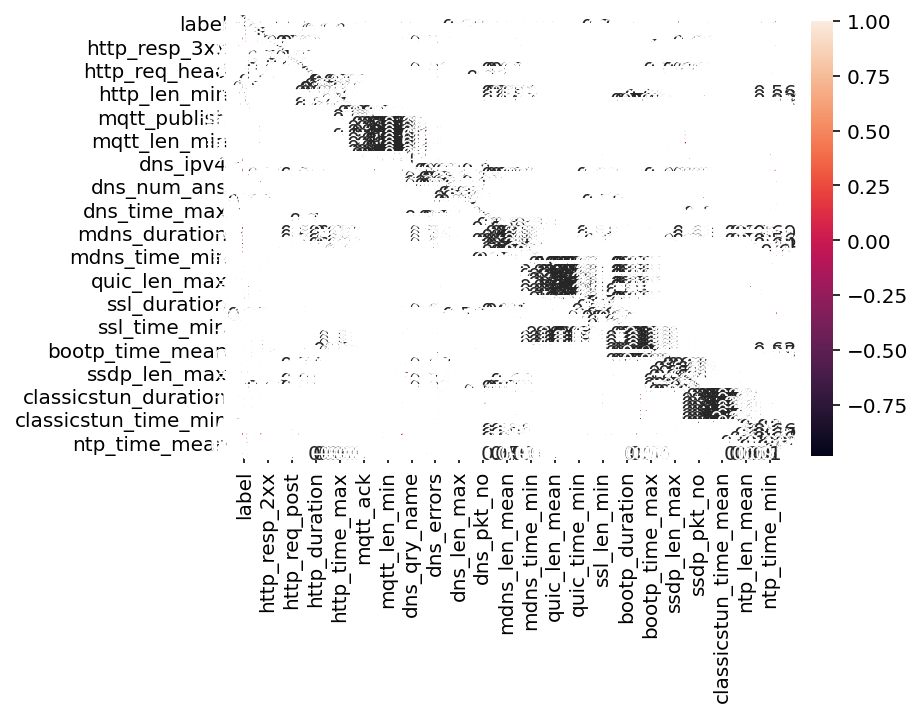

In [110]:
sn.heatmap(corr, annot=True)
plt.show()

In [102]:
lc = [list(i) for i in comb_fv]
lc
str_sc = []
for i in scores:
    str_sc.append([str(j) for j in i])
str_sc[0]

['0.83010425492038',
 '0.827768014059754',
 '0.8337160297698852',
 '0.8277282802137442']

In [106]:
with open('models_acc.csv', 'w') as the_file:
    the_file.write("F1,Accuracy,Precision,Recall,Features\n")
    for i, j in zip(str_sc,lc):
        s = ",".join(i) + "," + ";".join(j) + "\n" 
        the_file.write(s)

In [37]:
models_acc = pd.read_csv('models_acc.csv')
models_acc

,F1,Accuracy,Precision,Recall,Features
0,0.830104,0.827768,0.833716,0.827728,sess
1,0.242421,0.340510,0.290122,0.284568,tcp
2,0.229152,0.317663,0.448802,0.249736,http
3,0.080562,0.159051,0.074423,0.133333,mqtt
4,0.592827,0.644552,0.663117,0.598022,dns
...,...,...,...,...,...
4090,0.969274,0.969684,0.973363,0.968182,sess;tcp;http;dns;mdns;quic;ssl;bootp;ssdp;cla...
4091,0.972936,0.975835,0.978854,0.970345,sess;tcp;mqtt;dns;mdns;quic;ssl;bootp;ssdp;cla...
4092,0.971440,0.971880,0.976858,0.969875,sess;http;mqtt;dns;mdns;quic;ssl;bootp;ssdp;cl...
4093,0.961921,0.960896,0.961622,0.963510,tcp;http;mqtt;dns;mdns;quic;ssl;bootp;ssdp;cla...


In [15]:
data_acc = []


for index, row in models_acc.iterrows():
    if row['F1'] > 0.90 and row['Accuracy'] > 0.95 and row['Precision'] > 0.95 and row['Recall'] > 0.95:
        data_acc.append([row['F1'], row['Accuracy'], row['Precision'], row['Recall'], row['Features']])
        
data_acc

[[0.957823972, 0.95913884, 0.9603580159999999, 0.9559905679999999, 'sess;dns'],
 [0.958877744, 0.96397188, 0.96343583, 0.9576073759999999, 'sess;ssl'],
 [0.9658266809999999, 0.96572935, 0.966147544, 0.965657215, 'sess;tcp;dns'],
 [0.953729345, 0.958260105, 0.95682603, 0.9526300190000001, 'sess;tcp;ssl'],
 [0.962999733, 0.964411248, 0.964790556, 0.962565841, 'sess;http;dns'],
 [0.9569642070000001,
  0.958260105,
  0.9618072870000001,
  0.955374995,
  'sess;http;ssl'],
 [0.95412407, 0.955184534, 0.955657587, 0.954089305, 'sess;mqtt;dns'],
 [0.9596765979999999,
  0.96572935,
  0.967943516,
  0.9576323990000001,
  'sess;mqtt;ssl'],
 [0.961510572, 0.960456942, 0.962907051, 0.960901895, 'sess;dns;mdns'],
 [0.9605477640000001, 0.96397188, 0.962728171, 0.959929822, 'sess;dns;quic'],
 [0.965637537, 0.9666080840000001, 0.970020889, 0.964927278, 'sess;dns;ssl'],
 [0.962187247, 0.963532513, 0.96533414, 0.960526985, 'sess;dns;bootp'],
 [0.967524112, 0.968365554, 0.968376378, 0.966945582, 'sess;dns;

In [16]:
len(data_acc)

1830

In [24]:
x_axis = ['sess', 'tcp', 'http', 'mqtt', 'dns', 'mdns', 'quic', 'ssl', 'bootp', 'ssdp', 'classicstun', 'ntp']
y_axis = [0] * len(x_axis)
for i in data_acc:
    f = i[-1].split(";")
    for j in f:
        y_axis[x_axis.index(j)] += 1

y_axis

[1686, 1012, 975, 931, 1120, 922, 938, 1155, 969, 993, 970, 916]

In [37]:
y_axis_r = [ i - 950 for i in y_axis]
y_axis_r

[736, 62, 25, -19, 170, -28, -12, 205, 19, 43, 20, -34]

<BarContainer object of 12 artists>

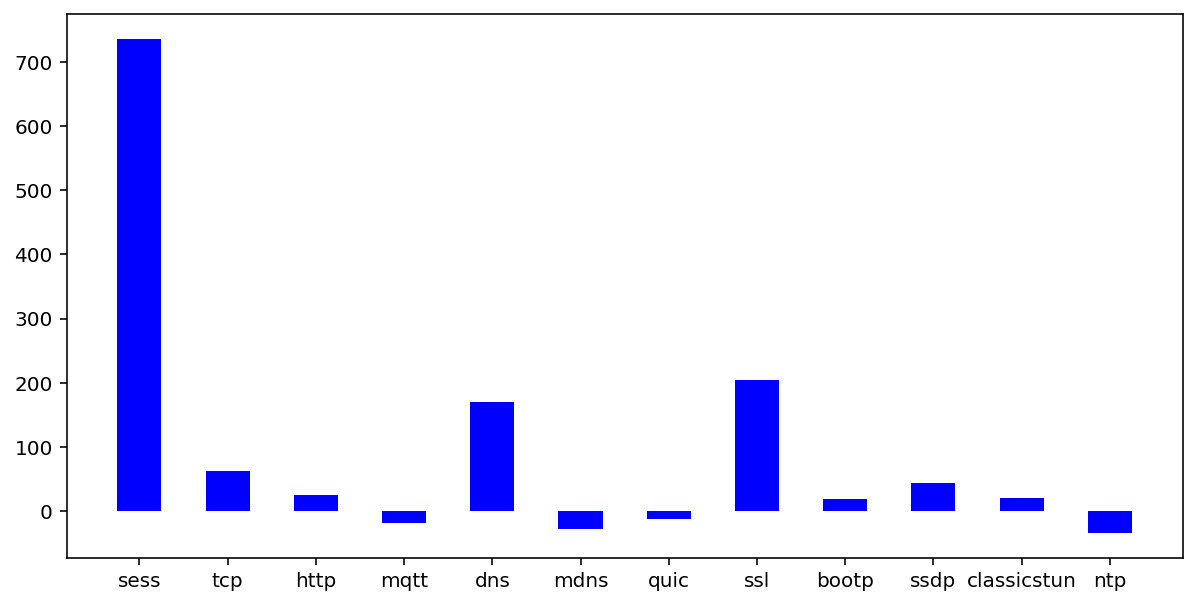

In [38]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(x_axis, y_axis_r, color ='blue', width = 0.5)

In [36]:
# fv = ['sess', 'tcp', 'http', 'mqtt', 'dns', 'mdns', 'quic', 'ssl', 'bootp', 'ssdp', 'classicstun', 'ntp']

ft = ['sess', 'tcp', 'http', 'dns', 'ssl', 'ssdp' ]

In [54]:
# sess;tcp;http;dns;ssl;ssdp  1627
print(models_acc.iloc[[1625]])
dset = [list(models_acc.iloc[[1625]]['F1'])[0], list(models_acc.iloc[[1625]]['Accuracy'])[0], list(models_acc.iloc[[1625]]['Precision'])[0], list(models_acc.iloc[[1625]]['Recall'])[0]]

            F1  Accuracy  Precision    Recall                    Features
1625  0.971337  0.972759   0.976271  0.969636  sess;tcp;http;dns;ssl;ssdp


In [50]:
dset

[0.9713374229999999, 0.9727592270000001, 0.9762705140000001, 0.969635547]

<BarContainer object of 4 artists>

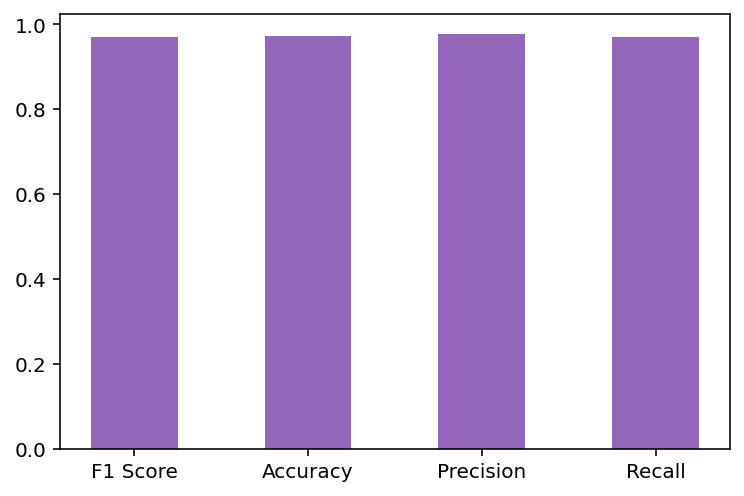

In [52]:
yset = ['F1 Score', 'Accuracy', 'Precision', 'Recall']

plt.bar(yset, dset, color = 'tab:purple', width = 0.5)

In [63]:
temp = [j for j in lables if j.split("_")[0] in ft]
temp.append('label')

In [64]:
len(temp)

55

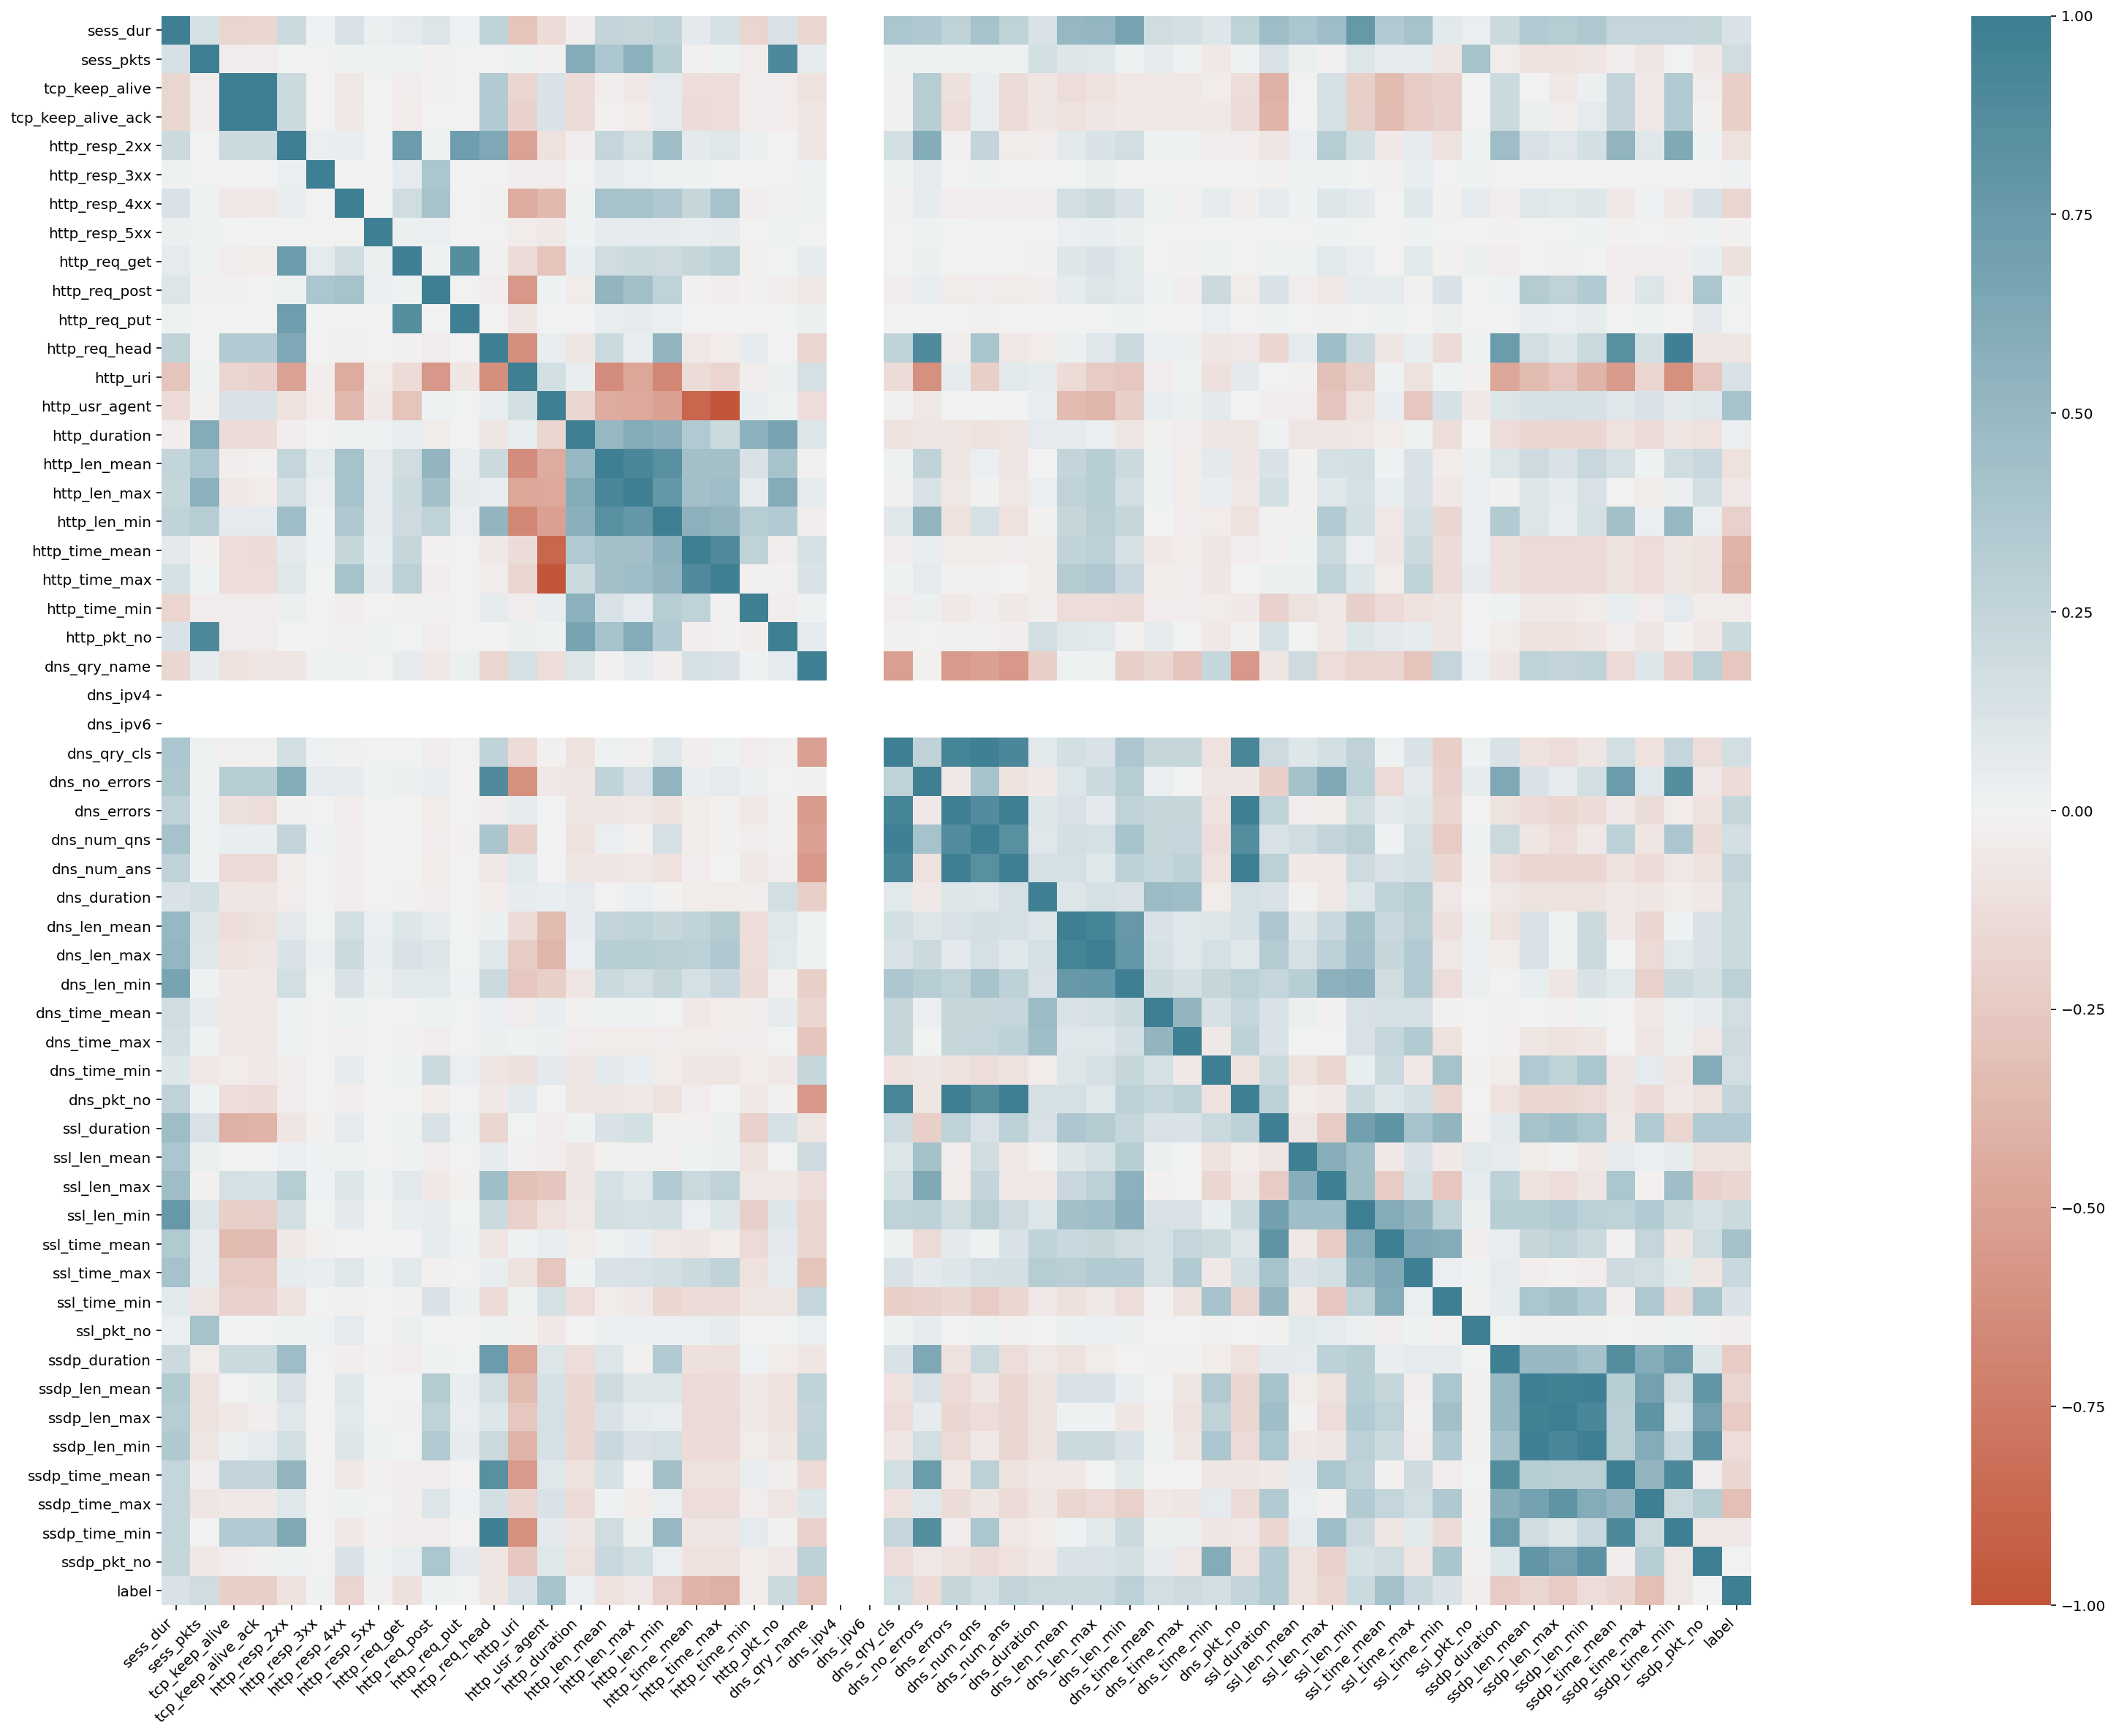

In [65]:
corr = pd_data[temp].corr()
plt.figure(figsize = (54,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [66]:
print(corr)

                    sess_dur  sess_pkts  tcp_keep_alive  tcp_keep_alive_ack  \
sess_dur            1.000000   0.142939       -0.179137           -0.167764   
sess_pkts           0.142939   1.000000       -0.032833           -0.035064   
tcp_keep_alive     -0.179137  -0.032833        1.000000            0.997578   
tcp_keep_alive_ack -0.167764  -0.035064        0.997578            1.000000   
http_resp_2xx       0.205044   0.003135        0.206589            0.205012   
http_resp_3xx       0.008132   0.003963       -0.005288           -0.005425   
http_resp_4xx       0.117220   0.020557       -0.062552           -0.057115   
http_resp_5xx       0.024851   0.016660       -0.002733           -0.002106   
http_req_get        0.062545   0.014595       -0.038850           -0.040027   
http_req_post       0.112354  -0.015619       -0.014313           -0.002005   
http_req_put        0.017349   0.000528       -0.001576           -0.001762   
http_req_head       0.257947  -0.002012        0.347